<a href="https://colab.research.google.com/github/ANG29/COMP5318/blob/main/confusion_matrix_f1_test7_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run if on google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io
import numpy as np 

# Reads the data from file

The following code block ensures this notebook works on both local and Google Colab.

In [3]:
import os

path1 = "data/matlab/emnist-bymerge.mat"
path2 = "/content/drive/MyDrive/COMP5318/emnist-bymerge.mat"

if os.path.exists(path1):
    file_by_merge = path1
else:
    file_by_merge = path2

In [4]:
mat_data_by_merge = scipy.io.loadmat(file_by_merge, mdict=None, appendmat=True)

# reads both train-data and test-data
data_train_by_merge = mat_data_by_merge["dataset"][0][0][0][0][0][0]
label_train_by_merge = mat_data_by_merge["dataset"][0][0][0][0][0][1]
data_test = mat_data_by_merge["dataset"][0][0][1][0][0][0]
label_test = mat_data_by_merge["dataset"][0][0][1][0][0][1]
mapping = mat_data_by_merge["dataset"][0][0][2]

label_map = {}
for label, text in mapping:
    label_map[label] = chr(text)

# Data truncate
Because the original dataset is big, we defined a function that samples some data from the original dataset.

In [5]:
import random

def reduce_data(data, label, target_size, random_order=True):
    if target_size == data.shape[0]:
        return data, label
    if random_order:
        index_list = [i for i in range(data.shape[0])]
        random.shuffle(index_list)  # random index list, make sure that data and labels are in a same order
        rnd_data = data[index_list]
        rnd_label = label[index_list]
        return rnd_data[:target_size], rnd_label[:target_size]
    else:
        return data[:target_size], label[:target_size]

data_train, label_train = reduce_data(data_train_by_merge, label_train_by_merge, 100000)

# Data preview

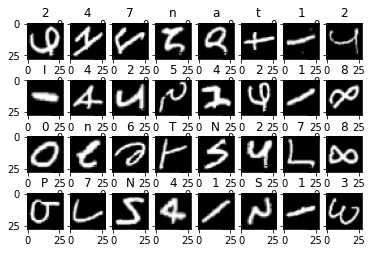

In [6]:
import matplotlib.pyplot as plt

for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(data_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(label_map[label_train[i][0]])
plt.show()

# Import PyTorch

In [7]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as sche
import torchvision.transforms as transforms
import torchvision.transforms.functional as fun
import torch.utils.data as Data

In [8]:
torch.__version__

'1.11.0+cu113'

# Check if GPU is available

In [9]:
USE_GPU = True  # whether to use GPU if GPU is available

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data structure transformation

In [11]:
def create_loader(data, label, device, shuffle, batch_size=64):
    """
    Creates a dataloader that can be used for pytorch.
    """
    data = data.reshape(data.shape[0], 1, 28, 28)  # reshape the data to 1 channel, 28x28

    torch_data = torch.from_numpy(data.astype(np.float32))
    torch_label = torch.from_numpy(label.astype(np.int64))

    # if gpu available, load the data to gpu to accelerate the process
    if USE_GPU and device.type == 'cuda':
        torch_data = torch_data.to(device)
        torch_label = torch_label.to(device)

    flat_labels = torch_label.reshape(-1)
    data_integrate = Data.TensorDataset(torch_data / 255, flat_labels)  # / 255 to make data between 0 to 1

    # a random order batched dataloader
    return Data.DataLoader(
        dataset=data_integrate,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=(0 if device.type == 'cuda' else 4)
    )

# Image distortion

This technique prevents overfitting and improves generalisation.

In [12]:
import random

class Distortion(nn.Module):
    def __init__(self, min_height=24, max_height=32, rotation_limit=15):
        super().__init__()

        self.min_height = min_height
        self.max_height = max_height
        self.rotation_limit = rotation_limit

    def forward(self, x):
        if self.training:
            size = random.randint(self.min_height, self.max_height)  # vertically += 15%
            angle = (random.random() - 0.5) * self.rotation_limit * 2  # += 15 degrees
            resized = fun.resize(x, (size, 28))

            pad_top = (28 - size) // 2
            pad_bot = (28 - size - pad_top)
            resized = fun.pad(resized, [0, pad_top, 0, pad_bot], padding_mode="edge")
            resized = fun.rotate(resized, angle)
            return resized
        else:
            return x
        

In [13]:
class EmptyLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

# LeNet-5 Construction

In [14]:
class LeNet5(nn.Module):
    """
    An implementation of LeNet-5.

    The input is 28x28 single channel image and the output is image labels.
    """
    def __init__(self, n_classes, batch_norm=True, dropout=0.4, distortion=True):
        super().__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            Distortion() if distortion else EmptyLayer(),
            nn.Conv2d(1, 6, kernel_size=5),  # first conv layer
            nn.BatchNorm2d(6, momentum=0.1) if batch_norm else EmptyLayer(),  
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),  # second conv layer
            nn.BatchNorm2d(16, momentum=0.1) if batch_norm else EmptyLayer(),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Full connection layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)  # connect to the final output labels
        )

    def make_distortion(self, distortion):
        if distortion is None:
            return EmptyLayer()
        else:
            return Distortion(distortion)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        output = self.classifier(x)
        return output

# Train process

In [15]:
import copy
import pandas as pd
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def train_model(model: nn.Module, data_loader, train_rate, loss_fn, optimizer, scheduler, n_epochs=30):

    # train with a batch of data
    def train(batch_x, batch_y):
        model.train()
        output = model(batch_x)
        pre_lab = torch.max(output, 1)[1]
        loss = loss_fn(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss = loss.item() * batch_x.size(0)
        batch_corrects = torch.sum(pre_lab == batch_y.data)
        return batch_loss, batch_corrects,pre_lab

    # validation with a batch of data
    def validation(batch_x, batch_y):
        model.eval()
        output = model(batch_x)
        pre_lab = torch.max(output, 1)[1]
        loss = loss_fn(output, batch_y)
        batch_loss = loss.item() * batch_x.size(0)
        batch_corrects = torch.sum(pre_lab == batch_y.data)
        return batch_loss, batch_corrects

    # number of batches used to train
    n_train_batch = round(len(data_loader) * train_rate)
    # need to deep copy the model state dict, otherwise our 'best_state' would only store a reference to the dict
    best_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    begin_time = time.time()

    for epoch in range(n_epochs):
        pre_label_list = []
        true_label_list = []
        cur_lr = scheduler.get_last_lr()[0] if scheduler is not None else float('nan')
        print('----- Epoch {}/{}, lr={:.06f} -----'.format(epoch, n_epochs - 1, cur_lr))
        train_loss = 0.0
        train_corrects = 0
        train_total = 0
        val_loss = 0.0
        val_corrects = 0
        val_total = 0
        for batch_index, (x, y) in enumerate(data_loader):  # enumerate all batches
            # the first 'n_train_batch' batches are the train set, the rest are the validation set
            if batch_index < n_train_batch:
                batch_loss, batch_corrects, pre_label = train(x, y)
                ##
                pre_label_list.append(pre_label.cpu())
                true_label_list.append(y.cpu())
                ##
                train_loss += batch_loss
                train_corrects += batch_corrects
                train_total += x.size(0)
            else:
                batch_loss, batch_corrects = validation(x, y)
                val_loss += batch_loss
                val_corrects += batch_corrects
                val_total += x.size(0)
        
        # loss rate and accuracy of this epoch
        train_loss_rate = train_loss / train_total
        train_acc = train_corrects.double().item() / train_total

        val_loss_rate = val_loss / val_total
        val_acc = val_corrects.double().item() / val_total
        
        time_used = round(time.time() - begin_time)
        print('Time since begun: {:d}m {:d}s'.format(time_used // 60, time_used % 60))
        print('Train Loss: {:.4f}, Train Acc: {:.4f}'.format(
            train_loss_rate, train_acc))
        print('Val Loss: {:.4f}, val Acc: {:.4f}'.format(
            val_loss_rate, val_acc))
        
        #####度量方式
        measure_metohs(np.concatenate(pre_label_list), np.concatenate(true_label_list))
        # f1 = classification_report(pre_label_list,pre_label_list)
        # print('Some other measure:/n',f1)


        # save the best params
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        # record the losses and accuracies for process visualisation
        train_loss_list.append(train_loss_rate)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss_rate)
        val_acc_list.append(val_acc)

        # change the learning rate
        if scheduler is not None:
            scheduler.step()
    
    # Loads the best model states
    model.load_state_dict(best_state)

    print('===== Best: epoch {} ====='.format(best_epoch))
    print('Train Loss: {:.4f}, Train Acc: {:.4f}'.format(
        train_loss_list[best_epoch], train_acc_list[best_epoch]))
    print('Val Loss: {:.4f}, val Acc: {:.4f}'.format(
        val_loss_list[best_epoch], val_acc_list[best_epoch]))

    # make the process a dataframe for easier visualisation
    train_process = pd.DataFrame(
        data = {
            "epoch": range(n_epochs),
            "train_loss": train_loss_list,
            "val_loss": val_loss_list,
            "train_acc": train_acc_list,
            "val_acc": val_acc_list
        })
    return model, train_process

In [41]:
def measure_metohs(pre_label_list, true_label_list):

    f1 = f1_score(pre_label_list,true_label_list,average='macro')
    print('++++++F1+++++:',f1)
    #con_matrix
    confusion = confusion_matrix(true_label_list,pre_label_list)
    confusion= confusion.astype(np.float64)
    lab_dic = {}
    for i in range(len(set(true_label_list))):
      lab_dic[i] = 0
    for i in true_label_list:
      lab_dic[i] += 1
    for i in range(len(confusion)):
      for j in range(len(confusion)):
        confusion[i][j] = confusion[i][j]/lab_dic[i]
    classes = list(set(true_label_list))
    print('Confusion matrix')
    plt.figure(figsize=(7,7))
    plt.imshow(confusion, cmap=plt.cm.Blues)
    indices = range(len(confusion))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    plt.colorbar()
    plt.xlabel('pre')
    # plt.ylabel('ture')
    # for first_index in range(len(confusion)):
    #   for second_index in range(len(confusion[first_index])):
    #       plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.tight_layout()
    plt.show()


# Start training

In [17]:
train_loader = create_loader(data_train, label_train, device, shuffle=True, batch_size=64)
test_loader = create_loader(data_test, label_test, device, shuffle=False, batch_size=64)

# Testing

In [54]:
def test_one_model(batch_norm: bool, dropout: float, distortion: bool, optimizer_class, init_lr, lr_factor=1.0):
    """
    :param batch_norm:      是否BatchNorm
    :param dropout:         dropout rate
    :param distortion: 
    :param optimizer_class: optimizer's class, not object
    :param init_lr:         最初的lr
    :param lr_factor:       每个epoch lr的变化, 1.0=不变
    """
    model = LeNet5(47, batch_norm, dropout, distortion)

    optimizer = optimizer_class(model.parameters(), init_lr)

    loss_fn = nn.CrossEntropyLoss()   # Loss function
    
    if lr_factor != 1.0:
        scheduler = sche.StepLR(optimizer, 1, lr_factor)  # decay learning rate in every epoch
    else:
        scheduler = None

    if USE_GPU and device.type == 'cuda':
        model = model.to(device)
        loss_fn = loss_fn.to(device)

    model, train_process = train_model(
        model, train_loader, 0.8,
        loss_fn, optimizer, scheduler, n_epochs=30)

    model.eval()
    test_corrects = 0
    test_num = 0
    results = []
    for _, (x, y) in enumerate(test_loader):
        output = model(x)
        pre_lab = torch.max(output, 1)[1]

        results.append(pre_lab.cpu())
        test_corrects += torch.sum(pre_lab == y.data) 
        test_num += x.size(0)
    y_pred, acc = np.concatenate(results), test_corrects.item() / test_num

    print("Accuracy on test set is {:.2f} %".format(acc * 100))

    return model, train_process, acc

## Test 1

----- Epoch 0/29, lr=0.001000 -----
Time since begun: 0m 5s
Train Loss: 1.0949, Train Acc: 0.6772
Val Loss: 0.5444, val Acc: 0.8209
++++++F1+++++: 0.5700918274653627
Confusion matrix


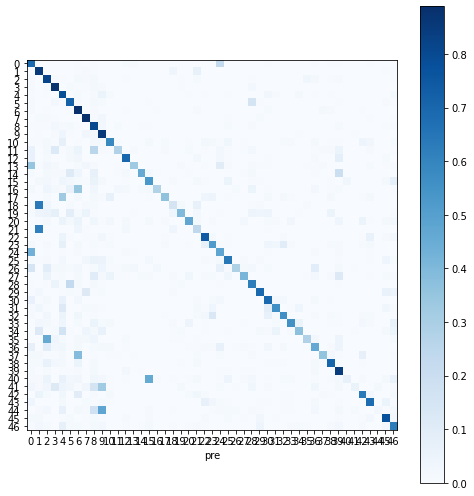

----- Epoch 1/29, lr=0.000900 -----
Time since begun: 0m 10s
Train Loss: 0.6748, Train Acc: 0.7789
Val Loss: 0.4412, val Acc: 0.8508
++++++F1+++++: 0.705026725265123
Confusion matrix


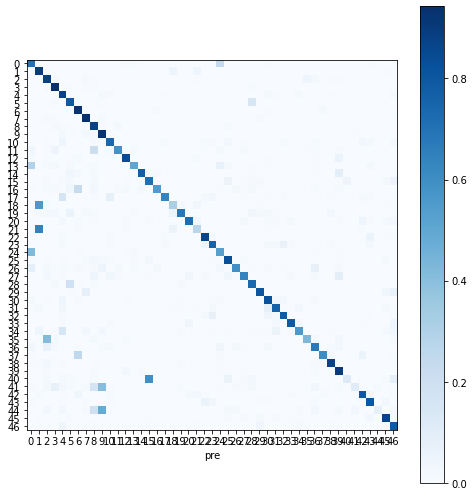

----- Epoch 2/29, lr=0.000810 -----
Time since begun: 0m 16s
Train Loss: 0.5934, Train Acc: 0.8027
Val Loss: 0.4107, val Acc: 0.8575
++++++F1+++++: 0.7399356007981307
Confusion matrix


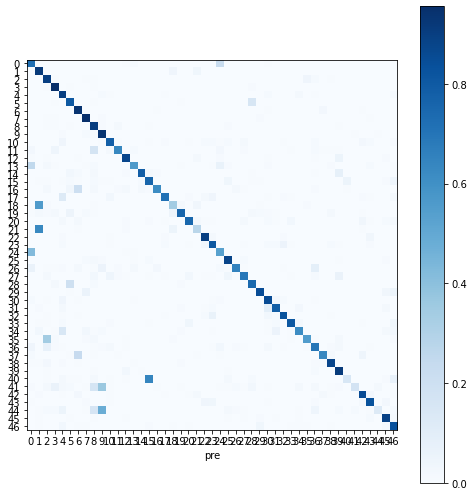

----- Epoch 3/29, lr=0.000729 -----
Time since begun: 0m 22s
Train Loss: 0.5575, Train Acc: 0.8128
Val Loss: 0.3908, val Acc: 0.8620
++++++F1+++++: 0.7517392315883877
Confusion matrix


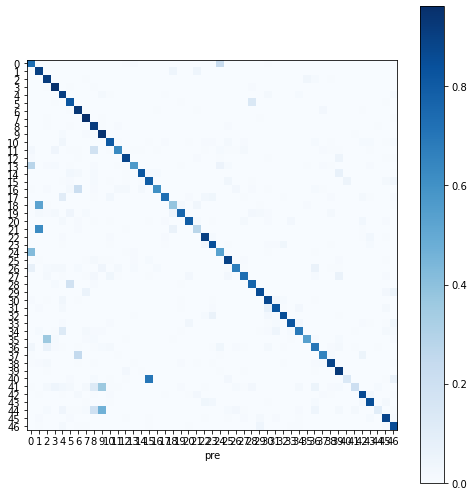

----- Epoch 4/29, lr=0.000656 -----
Time since begun: 0m 27s
Train Loss: 0.5317, Train Acc: 0.8204
Val Loss: 0.3615, val Acc: 0.8714
++++++F1+++++: 0.7632782704334464
Confusion matrix


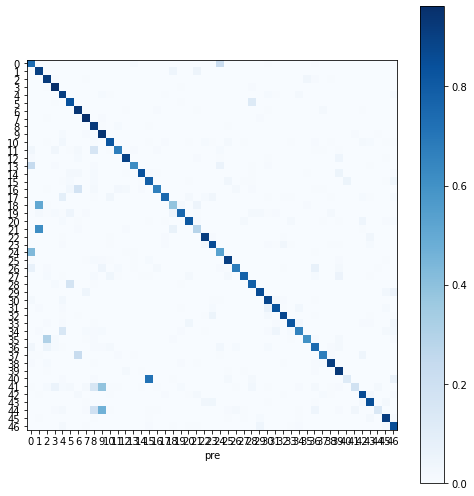

----- Epoch 5/29, lr=0.000590 -----
Time since begun: 0m 33s
Train Loss: 0.5114, Train Acc: 0.8262
Val Loss: 0.3590, val Acc: 0.8709
++++++F1+++++: 0.7722698845531022
Confusion matrix


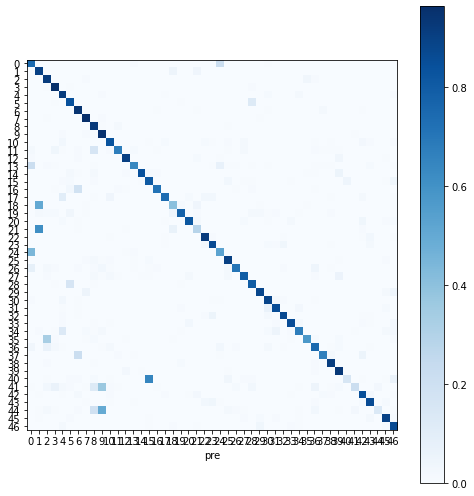

----- Epoch 6/29, lr=0.000531 -----
Time since begun: 0m 38s
Train Loss: 0.4927, Train Acc: 0.8310
Val Loss: 0.3493, val Acc: 0.8751
++++++F1+++++: 0.7814461162904288
Confusion matrix


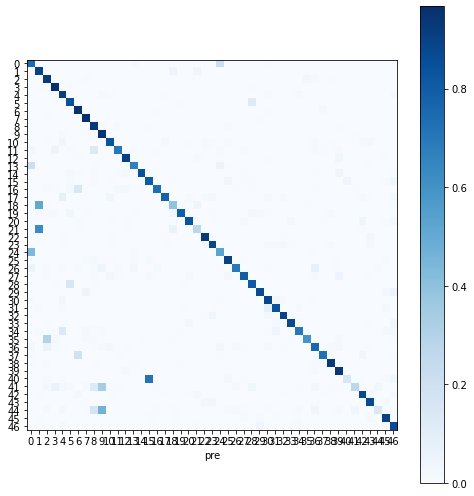

----- Epoch 7/29, lr=0.000478 -----
Time since begun: 0m 44s
Train Loss: 0.4825, Train Acc: 0.8341
Val Loss: 0.3476, val Acc: 0.8777
++++++F1+++++: 0.7835959017939444
Confusion matrix


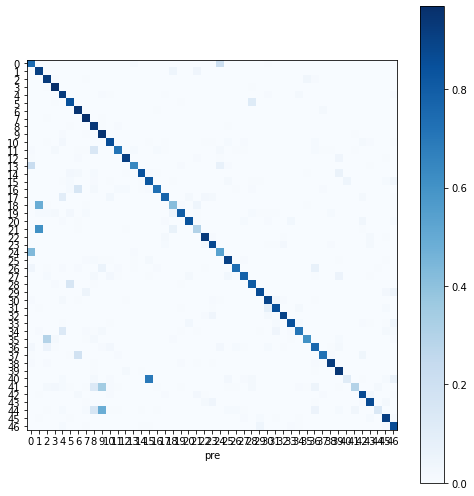

----- Epoch 8/29, lr=0.000430 -----
Time since begun: 0m 50s
Train Loss: 0.4706, Train Acc: 0.8370
Val Loss: 0.3299, val Acc: 0.8839
++++++F1+++++: 0.7864922690639966
Confusion matrix


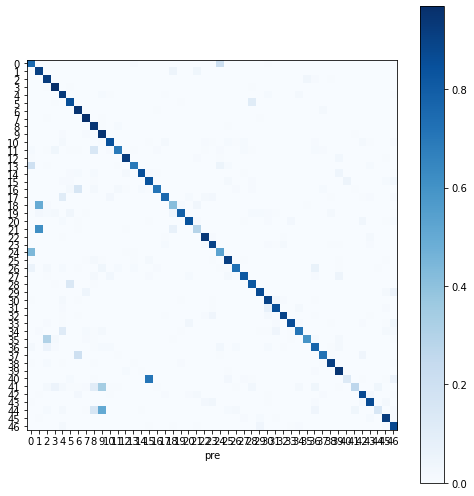

----- Epoch 9/29, lr=0.000387 -----
Time since begun: 0m 55s
Train Loss: 0.4614, Train Acc: 0.8400
Val Loss: 0.3222, val Acc: 0.8829
++++++F1+++++: 0.7929691085460032
Confusion matrix


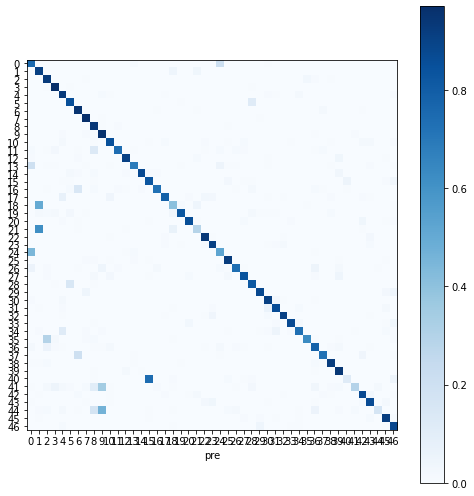

----- Epoch 10/29, lr=0.000349 -----
Time since begun: 1m 1s
Train Loss: 0.4566, Train Acc: 0.8416
Val Loss: 0.3385, val Acc: 0.8799
++++++F1+++++: 0.7937535756289361
Confusion matrix


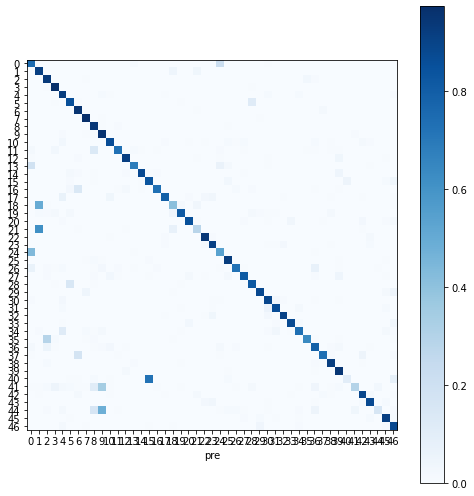

----- Epoch 11/29, lr=0.000314 -----
Time since begun: 1m 6s
Train Loss: 0.4508, Train Acc: 0.8429
Val Loss: 0.3281, val Acc: 0.8821
++++++F1+++++: 0.7978584784505672
Confusion matrix


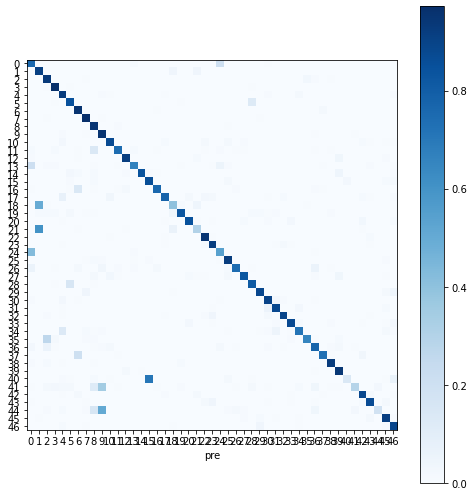

----- Epoch 12/29, lr=0.000282 -----
Time since begun: 1m 12s
Train Loss: 0.4505, Train Acc: 0.8439
Val Loss: 0.3136, val Acc: 0.8855
++++++F1+++++: 0.7982696161044334
Confusion matrix


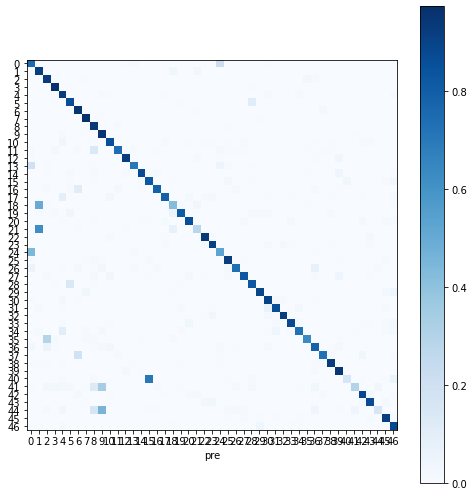

----- Epoch 13/29, lr=0.000254 -----
Time since begun: 1m 17s
Train Loss: 0.4403, Train Acc: 0.8460
Val Loss: 0.3131, val Acc: 0.8860
++++++F1+++++: 0.8019798008622363
Confusion matrix


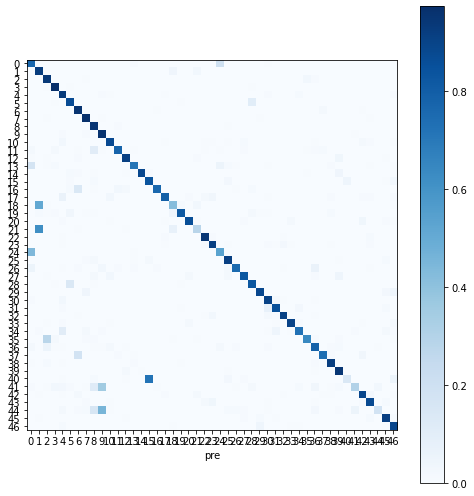

----- Epoch 14/29, lr=0.000229 -----
Time since begun: 1m 23s
Train Loss: 0.4339, Train Acc: 0.8480
Val Loss: 0.3115, val Acc: 0.8892
++++++F1+++++: 0.8037922943202662
Confusion matrix


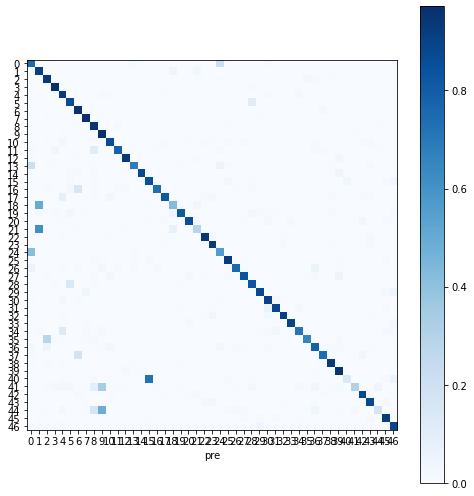

----- Epoch 15/29, lr=0.000206 -----
Time since begun: 1m 29s
Train Loss: 0.4385, Train Acc: 0.8465
Val Loss: 0.3102, val Acc: 0.8861
++++++F1+++++: 0.8021802529851829
Confusion matrix


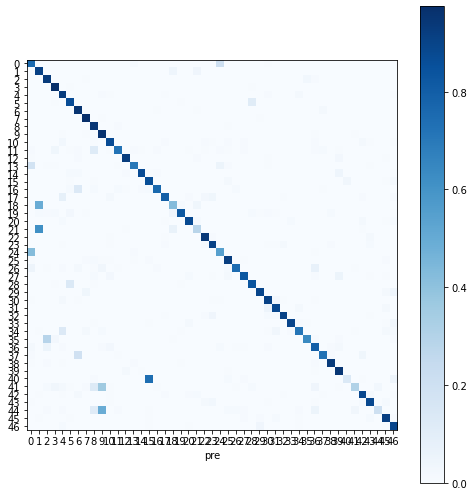

----- Epoch 16/29, lr=0.000185 -----
Time since begun: 1m 34s
Train Loss: 0.4299, Train Acc: 0.8502
Val Loss: 0.3080, val Acc: 0.8888
++++++F1+++++: 0.8074047981657712
Confusion matrix


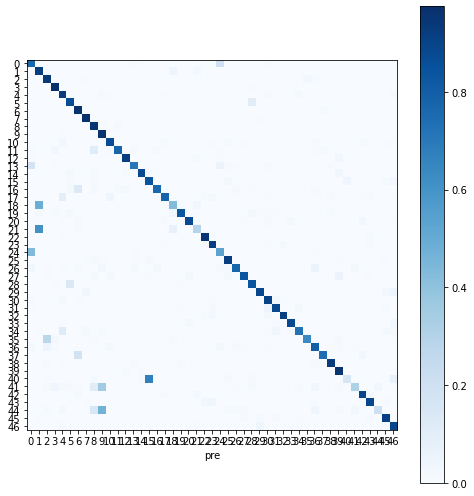

----- Epoch 17/29, lr=0.000167 -----
Time since begun: 1m 40s
Train Loss: 0.4294, Train Acc: 0.8509
Val Loss: 0.3016, val Acc: 0.8888
++++++F1+++++: 0.8079719153311209
Confusion matrix


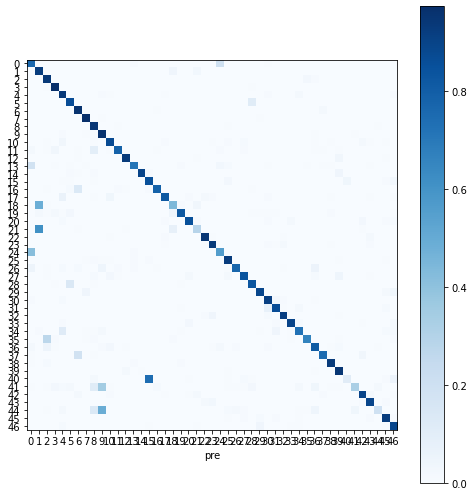

----- Epoch 18/29, lr=0.000150 -----
Time since begun: 1m 45s
Train Loss: 0.4272, Train Acc: 0.8504
Val Loss: 0.3026, val Acc: 0.8926
++++++F1+++++: 0.8075663519618882
Confusion matrix


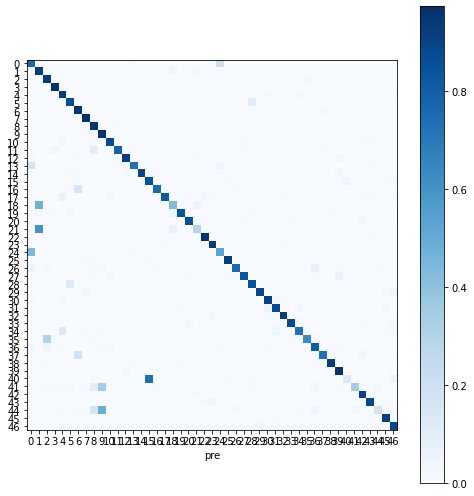

----- Epoch 19/29, lr=0.000135 -----
Time since begun: 1m 51s
Train Loss: 0.4222, Train Acc: 0.8522
Val Loss: 0.3051, val Acc: 0.8892
++++++F1+++++: 0.8096285069784068
Confusion matrix


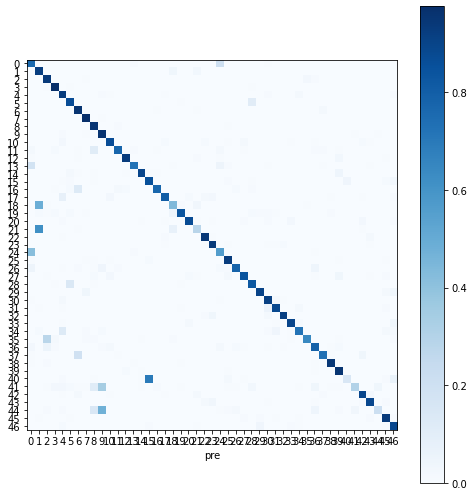

----- Epoch 20/29, lr=0.000122 -----
Time since begun: 1m 56s
Train Loss: 0.4214, Train Acc: 0.8520
Val Loss: 0.3121, val Acc: 0.8896
++++++F1+++++: 0.8098992002741563
Confusion matrix


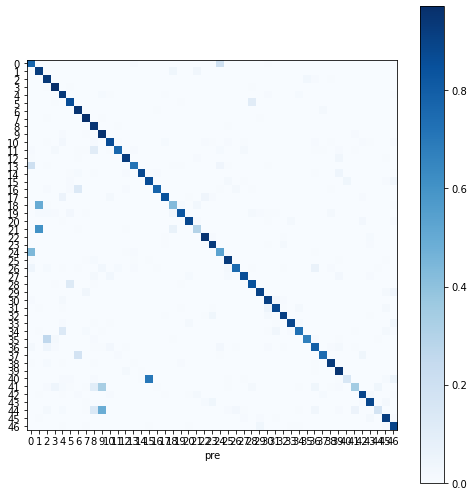

----- Epoch 21/29, lr=0.000109 -----
Time since begun: 2m 2s
Train Loss: 0.4190, Train Acc: 0.8528
Val Loss: 0.3019, val Acc: 0.8900
++++++F1+++++: 0.810911683877002
Confusion matrix


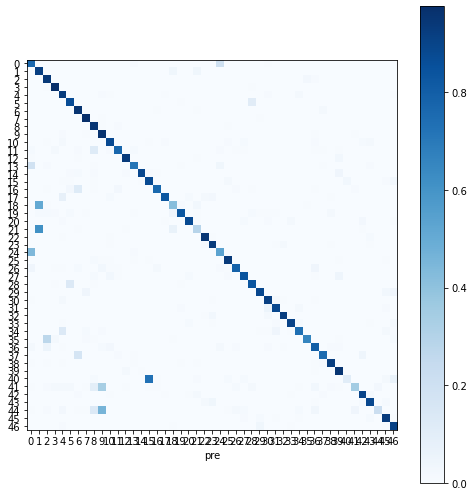

----- Epoch 22/29, lr=0.000098 -----
Time since begun: 2m 7s
Train Loss: 0.4233, Train Acc: 0.8524
Val Loss: 0.2892, val Acc: 0.8932
++++++F1+++++: 0.8125412814168991
Confusion matrix


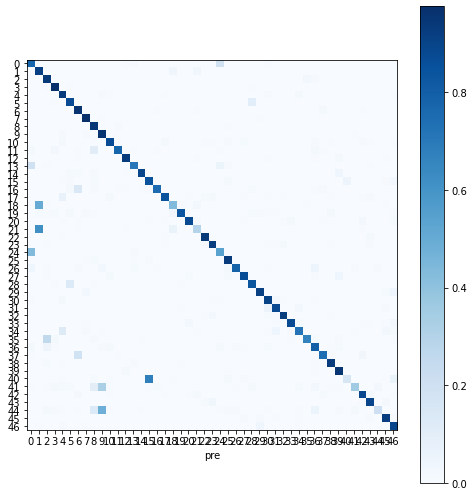

----- Epoch 23/29, lr=0.000089 -----
Time since begun: 2m 13s
Train Loss: 0.4185, Train Acc: 0.8527
Val Loss: 0.2899, val Acc: 0.8959
++++++F1+++++: 0.8112728862146543
Confusion matrix


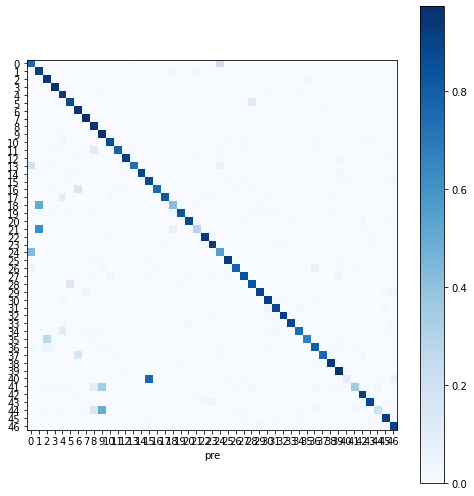

----- Epoch 24/29, lr=0.000080 -----
Time since begun: 2m 19s
Train Loss: 0.4179, Train Acc: 0.8530
Val Loss: 0.2977, val Acc: 0.8916
++++++F1+++++: 0.8121718777046298
Confusion matrix


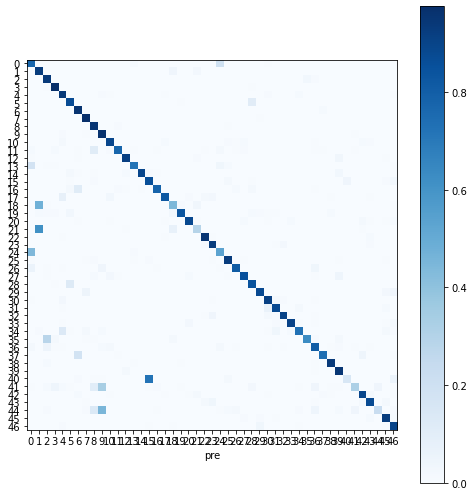

----- Epoch 25/29, lr=0.000072 -----
Time since begun: 2m 24s
Train Loss: 0.4158, Train Acc: 0.8547
Val Loss: 0.2905, val Acc: 0.8943
++++++F1+++++: 0.81389968570773
Confusion matrix


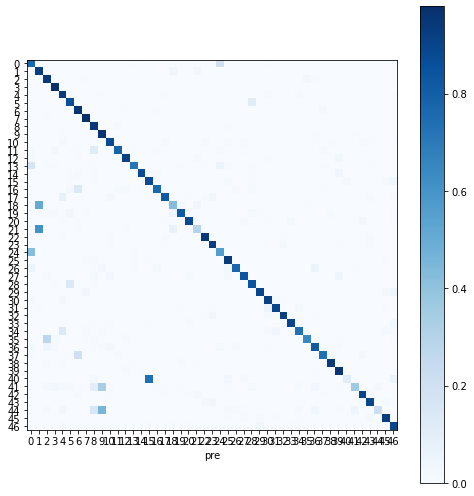

----- Epoch 26/29, lr=0.000065 -----
Time since begun: 2m 30s
Train Loss: 0.4115, Train Acc: 0.8562
Val Loss: 0.2981, val Acc: 0.8904
++++++F1+++++: 0.8161744542238134
Confusion matrix


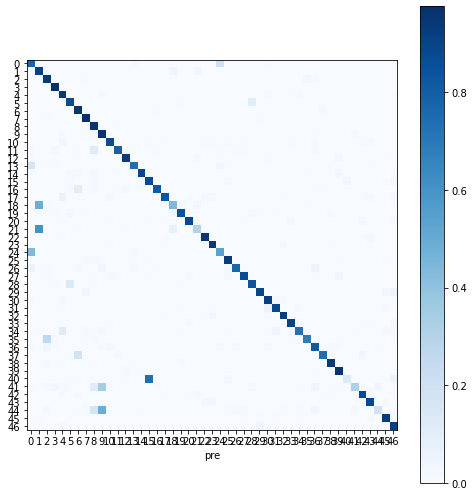

----- Epoch 27/29, lr=0.000058 -----
Time since begun: 2m 35s
Train Loss: 0.4167, Train Acc: 0.8527
Val Loss: 0.2865, val Acc: 0.8932
++++++F1+++++: 0.8083245516386119
Confusion matrix


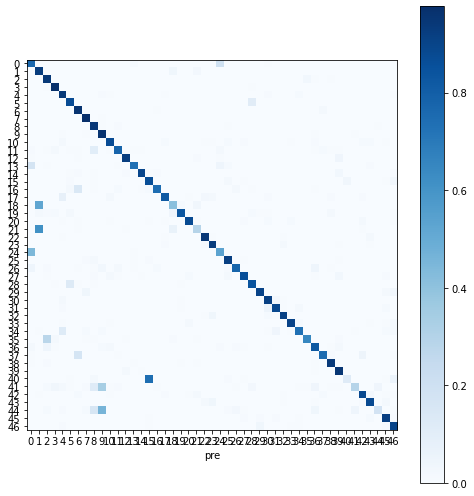

----- Epoch 28/29, lr=0.000052 -----
Time since begun: 2m 41s
Train Loss: 0.4160, Train Acc: 0.8532
Val Loss: 0.2886, val Acc: 0.8923
++++++F1+++++: 0.8144002605964714
Confusion matrix


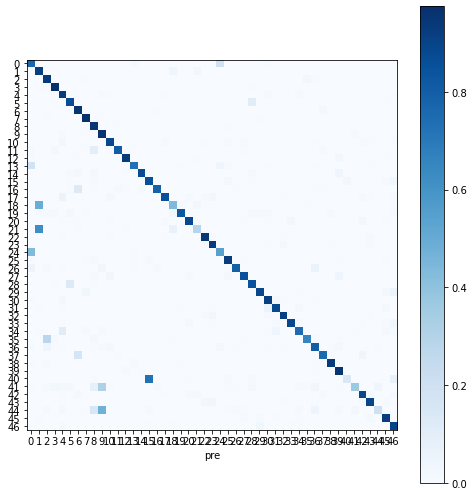

----- Epoch 29/29, lr=0.000047 -----
Time since begun: 2m 46s
Train Loss: 0.4151, Train Acc: 0.8557
Val Loss: 0.2883, val Acc: 0.8926
++++++F1+++++: 0.8138346642448825
Confusion matrix


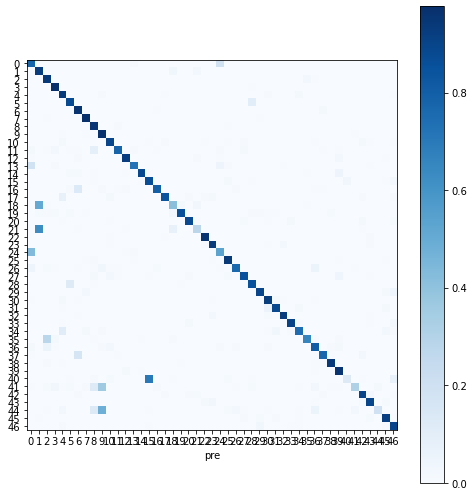

===== Best: epoch 23 =====
Train Loss: 0.4185, Train Acc: 0.8527
Val Loss: 0.2899, val Acc: 0.8959
Accuracy on test set is 88.26 %


In [58]:
cnn, train_process, acc = test_one_model(True, 0.4, True, torch.optim.Adam, 0.001, lr_factor=0.9)

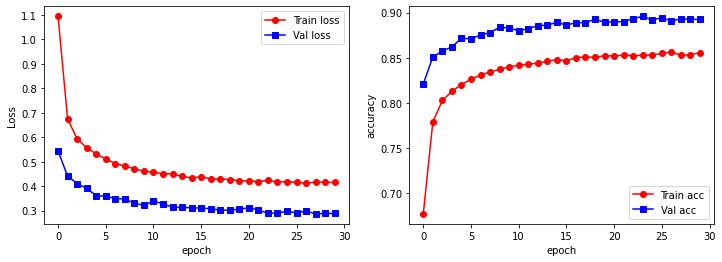

In [59]:
acc_plot(train_process)

In [60]:
# optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0003)  
# loss_fn = nn.CrossEntropyLoss()   # Loss function

# if USE_GPU and device.type == 'cuda':
#     cnn = cnn.to(device)
#     loss_fn = loss_fn.to(device)

# cnn, train_process = train_model(
#     cnn, train_loader, 0.8,
#     loss_fn, optimizer, n_epochs=30)

## Test2

----- Epoch 0/29, lr=0.001000 -----
Time since begun: 0m 4s
Train Loss: 1.2452, Train Acc: 0.6399
Val Loss: 0.5759, val Acc: 0.8060
++++++F1+++++: 0.5303406315496345
Confusion matrix


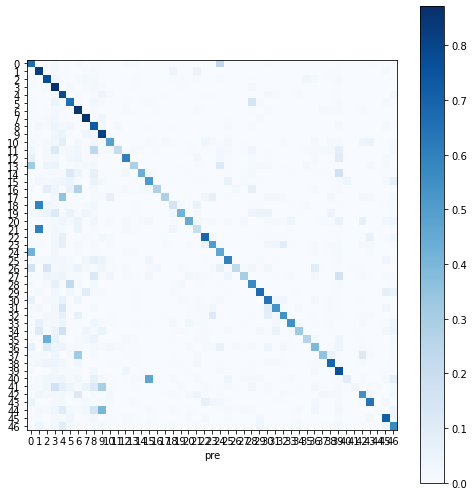

----- Epoch 1/29, lr=0.000900 -----
Time since begun: 0m 9s
Train Loss: 0.7339, Train Acc: 0.7635
Val Loss: 0.4568, val Acc: 0.8458
++++++F1+++++: 0.6841395677566755
Confusion matrix


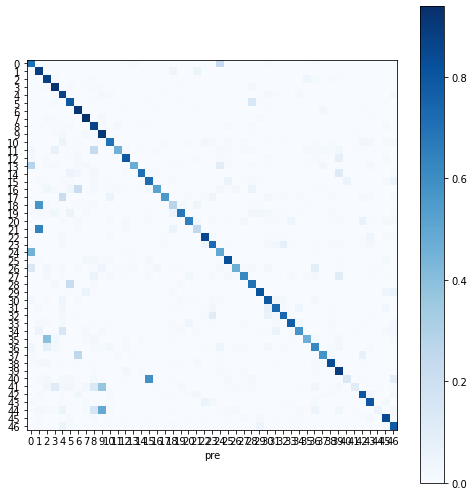

----- Epoch 2/29, lr=0.000810 -----
Time since begun: 0m 14s
Train Loss: 0.6362, Train Acc: 0.7911
Val Loss: 0.4447, val Acc: 0.8454
++++++F1+++++: 0.7190432012483786
Confusion matrix


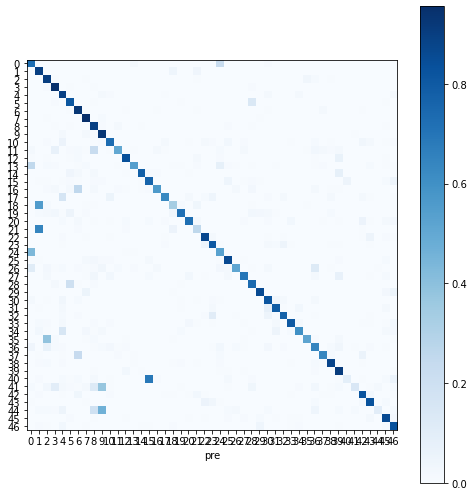

----- Epoch 3/29, lr=0.000729 -----
Time since begun: 0m 19s
Train Loss: 0.5945, Train Acc: 0.8023
Val Loss: 0.4123, val Acc: 0.8506
++++++F1+++++: 0.7373440949636862
Confusion matrix


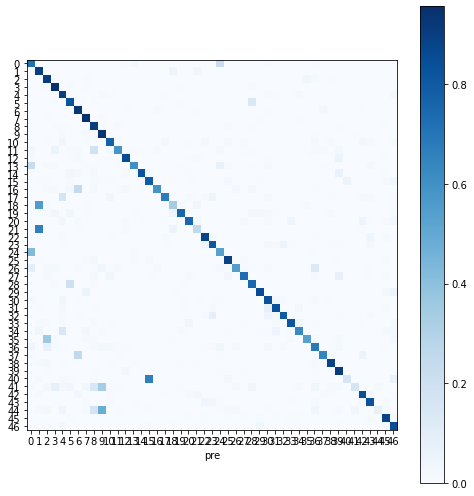

----- Epoch 4/29, lr=0.000656 -----
Time since begun: 0m 24s
Train Loss: 0.5669, Train Acc: 0.8097
Val Loss: 0.3894, val Acc: 0.8609
++++++F1+++++: 0.7477232733441017
Confusion matrix


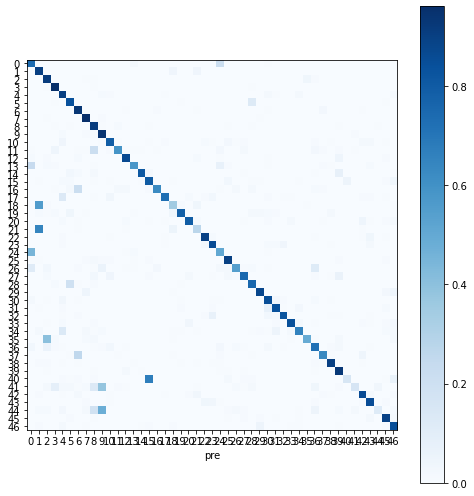

----- Epoch 5/29, lr=0.000590 -----
Time since begun: 0m 29s
Train Loss: 0.5387, Train Acc: 0.8176
Val Loss: 0.3687, val Acc: 0.8687
++++++F1+++++: 0.7587079615926986
Confusion matrix


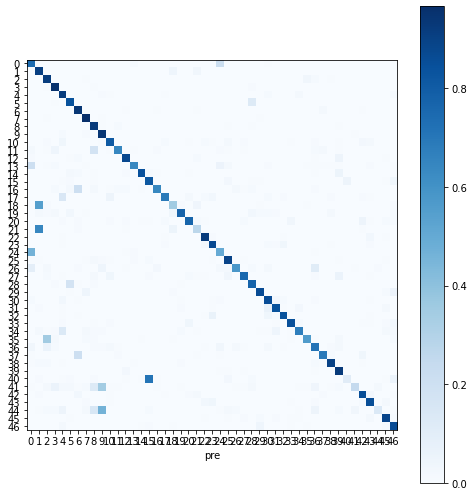

----- Epoch 6/29, lr=0.000531 -----
Time since begun: 0m 33s
Train Loss: 0.5203, Train Acc: 0.8237
Val Loss: 0.3719, val Acc: 0.8702
++++++F1+++++: 0.7687642352340952
Confusion matrix


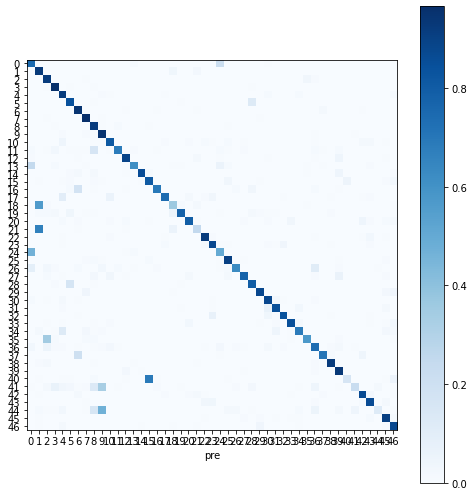

----- Epoch 7/29, lr=0.000478 -----
Time since begun: 0m 38s
Train Loss: 0.5076, Train Acc: 0.8266
Val Loss: 0.3657, val Acc: 0.8707
++++++F1+++++: 0.7727001464362707
Confusion matrix


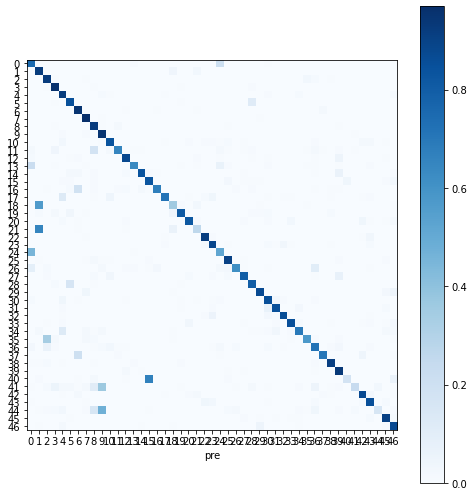

----- Epoch 8/29, lr=0.000430 -----
Time since begun: 0m 43s
Train Loss: 0.4997, Train Acc: 0.8289
Val Loss: 0.3483, val Acc: 0.8760
++++++F1+++++: 0.7798482085725661
Confusion matrix


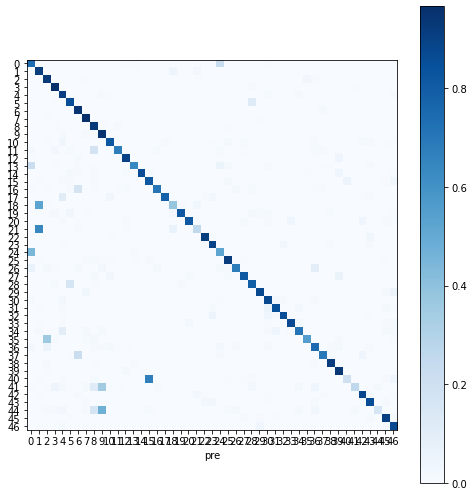

----- Epoch 9/29, lr=0.000387 -----
Time since begun: 0m 48s
Train Loss: 0.4838, Train Acc: 0.8335
Val Loss: 0.3609, val Acc: 0.8703
++++++F1+++++: 0.7808854224187305
Confusion matrix


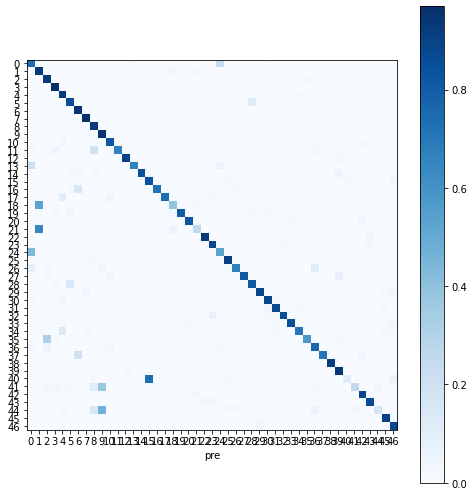

----- Epoch 10/29, lr=0.000349 -----
Time since begun: 0m 53s
Train Loss: 0.4790, Train Acc: 0.8350
Val Loss: 0.3436, val Acc: 0.8806
++++++F1+++++: 0.7857449491513682
Confusion matrix


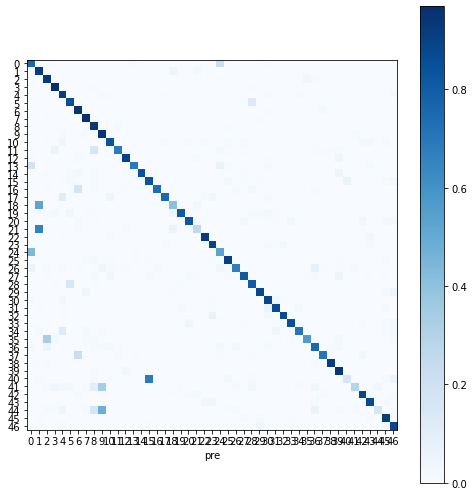

----- Epoch 11/29, lr=0.000314 -----
Time since begun: 0m 57s
Train Loss: 0.4729, Train Acc: 0.8378
Val Loss: 0.3386, val Acc: 0.8818
++++++F1+++++: 0.7896256652598862
Confusion matrix


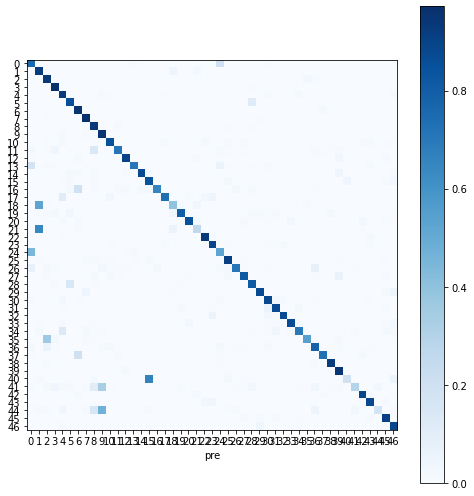

----- Epoch 12/29, lr=0.000282 -----
Time since begun: 1m 2s
Train Loss: 0.4672, Train Acc: 0.8378
Val Loss: 0.3265, val Acc: 0.8842
++++++F1+++++: 0.7893916876921856
Confusion matrix


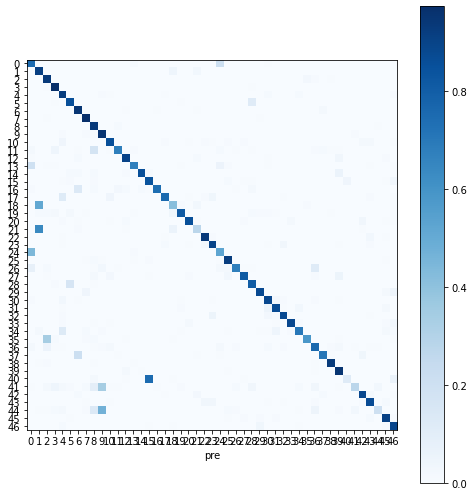

----- Epoch 13/29, lr=0.000254 -----
Time since begun: 1m 7s
Train Loss: 0.4600, Train Acc: 0.8416
Val Loss: 0.3245, val Acc: 0.8818
++++++F1+++++: 0.7935889928184399
Confusion matrix


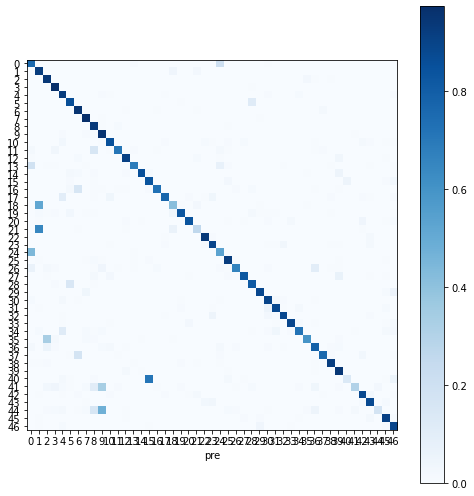

----- Epoch 14/29, lr=0.000229 -----
Time since begun: 1m 12s
Train Loss: 0.4641, Train Acc: 0.8391
Val Loss: 0.3218, val Acc: 0.8840
++++++F1+++++: 0.7896771576378127
Confusion matrix


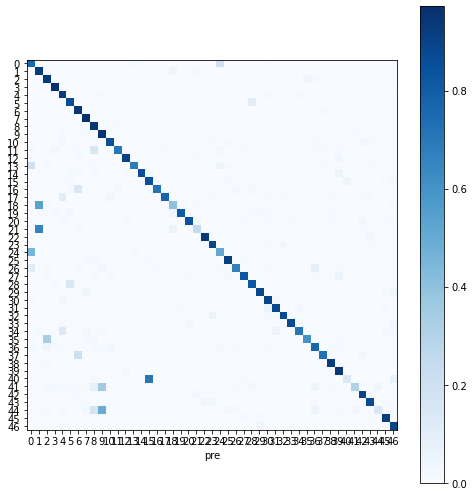

----- Epoch 15/29, lr=0.000206 -----
Time since begun: 1m 17s
Train Loss: 0.4527, Train Acc: 0.8439
Val Loss: 0.3216, val Acc: 0.8855
++++++F1+++++: 0.7974808209535331
Confusion matrix


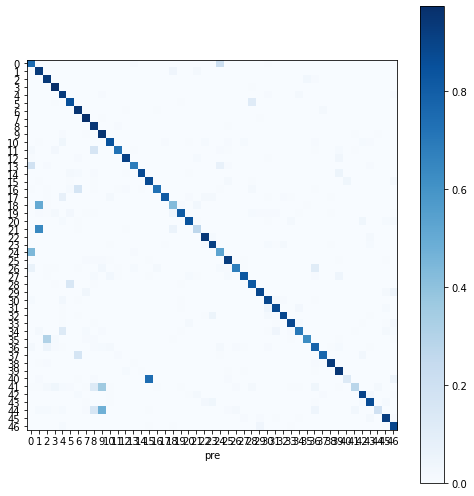

----- Epoch 16/29, lr=0.000185 -----
Time since begun: 1m 22s
Train Loss: 0.4546, Train Acc: 0.8431
Val Loss: 0.3116, val Acc: 0.8871
++++++F1+++++: 0.7977510514034918
Confusion matrix


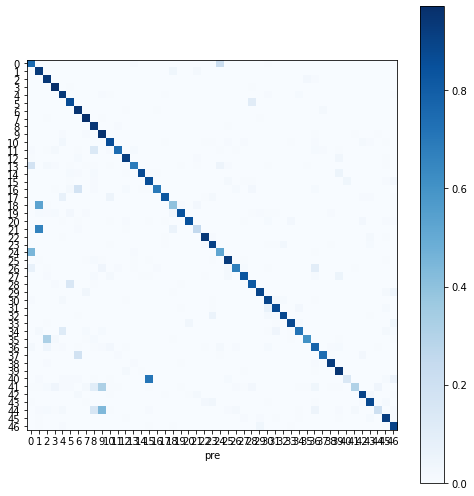

----- Epoch 17/29, lr=0.000167 -----
Time since begun: 1m 26s
Train Loss: 0.4467, Train Acc: 0.8445
Val Loss: 0.3235, val Acc: 0.8826
++++++F1+++++: 0.7973935813558959
Confusion matrix


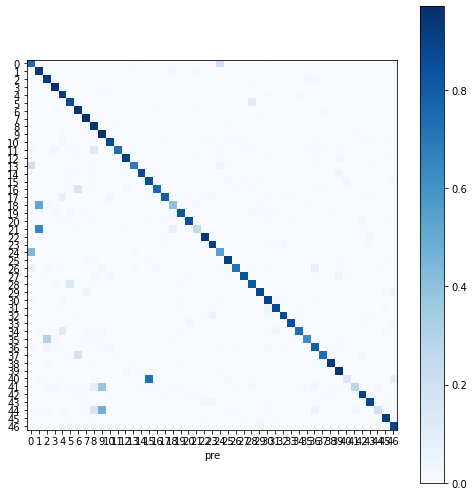

----- Epoch 18/29, lr=0.000150 -----
Time since begun: 1m 31s
Train Loss: 0.4489, Train Acc: 0.8440
Val Loss: 0.3109, val Acc: 0.8864
++++++F1+++++: 0.7990882809099218
Confusion matrix


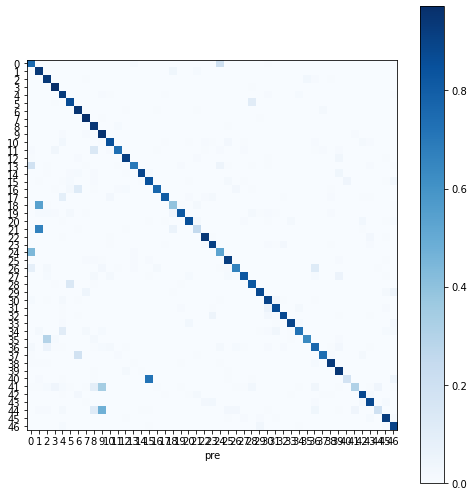

----- Epoch 19/29, lr=0.000135 -----
Time since begun: 1m 36s
Train Loss: 0.4448, Train Acc: 0.8441
Val Loss: 0.3123, val Acc: 0.8869
++++++F1+++++: 0.7990921657895581
Confusion matrix


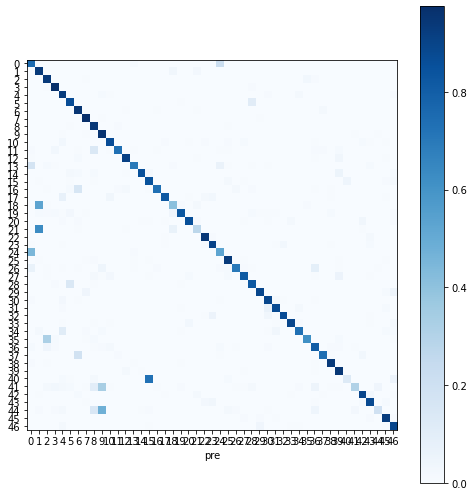

----- Epoch 20/29, lr=0.000122 -----
Time since begun: 1m 41s
Train Loss: 0.4423, Train Acc: 0.8454
Val Loss: 0.3134, val Acc: 0.8850
++++++F1+++++: 0.8008984937114133
Confusion matrix


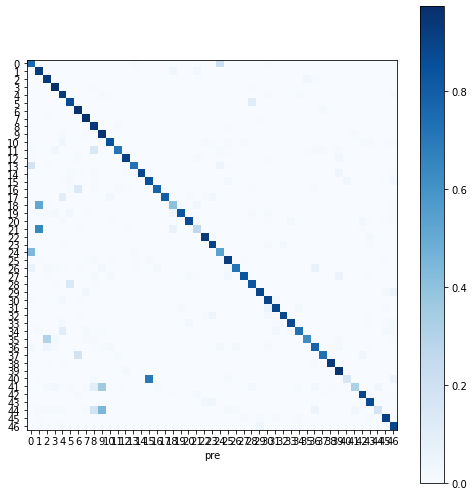

----- Epoch 21/29, lr=0.000109 -----
Time since begun: 1m 46s
Train Loss: 0.4373, Train Acc: 0.8485
Val Loss: 0.3135, val Acc: 0.8854
++++++F1+++++: 0.8043171882317164
Confusion matrix


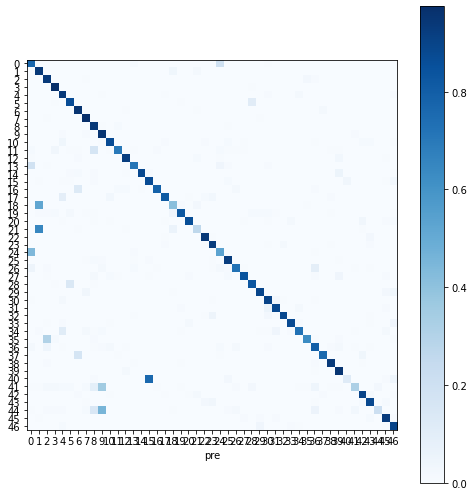

----- Epoch 22/29, lr=0.000098 -----
Time since begun: 1m 51s
Train Loss: 0.4409, Train Acc: 0.8478
Val Loss: 0.3197, val Acc: 0.8847
++++++F1+++++: 0.800267761902659
Confusion matrix


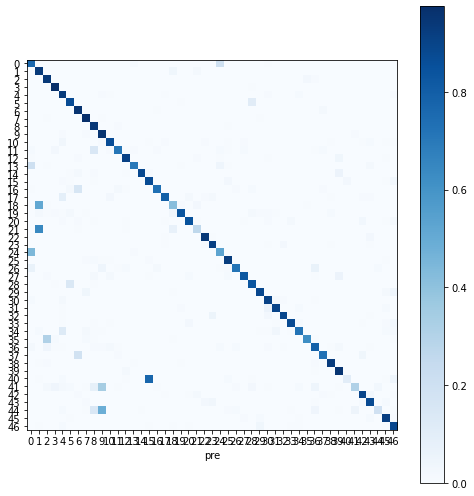

----- Epoch 23/29, lr=0.000089 -----
Time since begun: 1m 55s
Train Loss: 0.4357, Train Acc: 0.8469
Val Loss: 0.3100, val Acc: 0.8865
++++++F1+++++: 0.8019846594933889
Confusion matrix


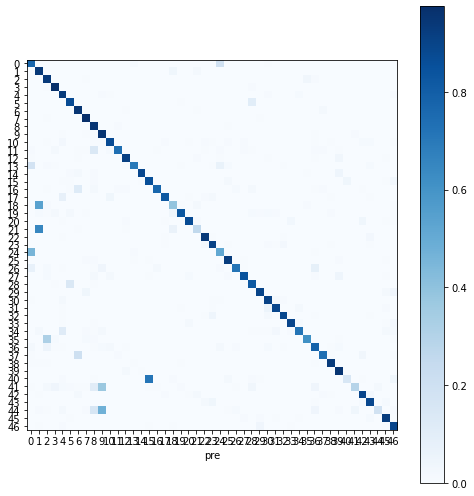

----- Epoch 24/29, lr=0.000080 -----
Time since begun: 2m 0s
Train Loss: 0.4398, Train Acc: 0.8464
Val Loss: 0.3043, val Acc: 0.8884
++++++F1+++++: 0.8004313127118073
Confusion matrix


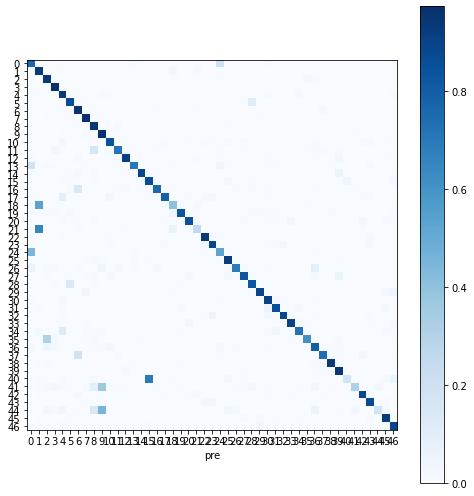

----- Epoch 25/29, lr=0.000072 -----
Time since begun: 2m 5s
Train Loss: 0.4317, Train Acc: 0.8497
Val Loss: 0.3061, val Acc: 0.8869
++++++F1+++++: 0.8062290936874428
Confusion matrix


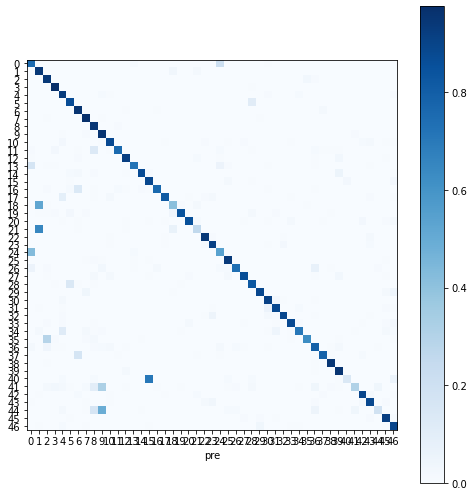

----- Epoch 26/29, lr=0.000065 -----
Time since begun: 2m 10s
Train Loss: 0.4331, Train Acc: 0.8507
Val Loss: 0.3108, val Acc: 0.8842
++++++F1+++++: 0.8082029251153775
Confusion matrix


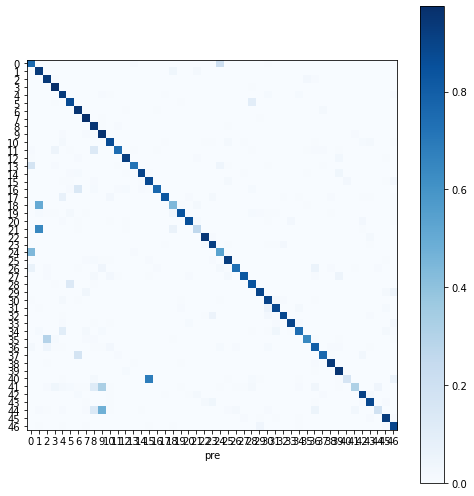

----- Epoch 27/29, lr=0.000058 -----
Time since begun: 2m 15s
Train Loss: 0.4278, Train Acc: 0.8500
Val Loss: 0.3132, val Acc: 0.8857
++++++F1+++++: 0.8042685737002355
Confusion matrix


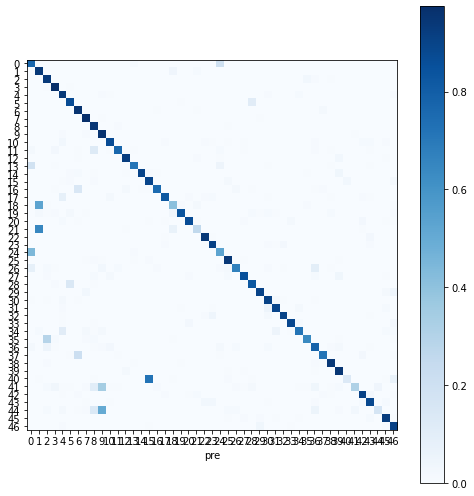

----- Epoch 28/29, lr=0.000052 -----
Time since begun: 2m 20s
Train Loss: 0.4307, Train Acc: 0.8501
Val Loss: 0.3027, val Acc: 0.8885
++++++F1+++++: 0.8060833225885398
Confusion matrix


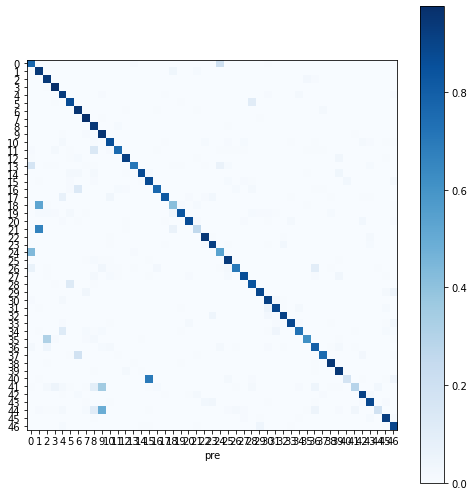

----- Epoch 29/29, lr=0.000047 -----
Time since begun: 2m 25s
Train Loss: 0.4284, Train Acc: 0.8501
Val Loss: 0.3052, val Acc: 0.8847
++++++F1+++++: 0.806980439739628
Confusion matrix


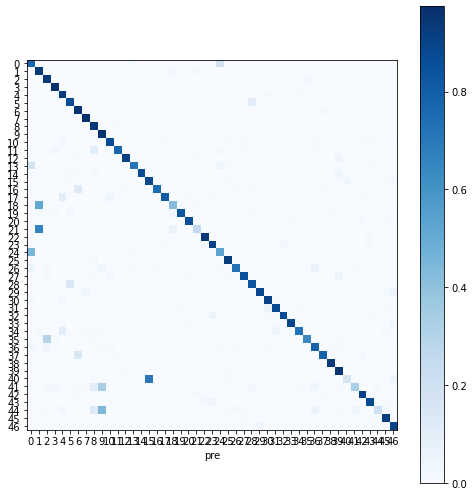

===== Best: epoch 28 =====
Train Loss: 0.4307, Train Acc: 0.8501
Val Loss: 0.3027, val Acc: 0.8885
Accuracy on test set is 87.96 %


In [61]:
cnn, train_process, acc = test_one_model(False, 0.4, True, torch.optim.Adam, 0.001, lr_factor=0.9)#batch_norm=False

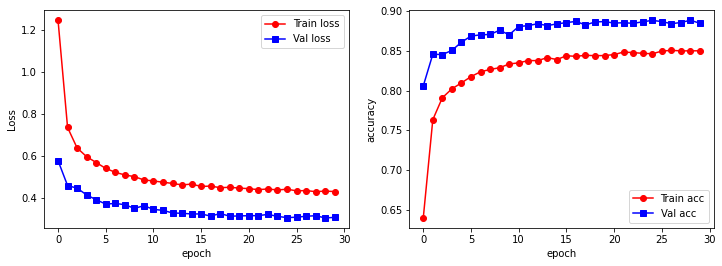

In [62]:
acc_plot(train_process)

## Test3

----- Epoch 0/29, lr=0.001000 -----
Time since begun: 0m 5s
Train Loss: 0.8574, Train Acc: 0.7439
Val Loss: 0.4863, val Acc: 0.8329
++++++F1+++++: 0.6616260687080722
Confusion matrix


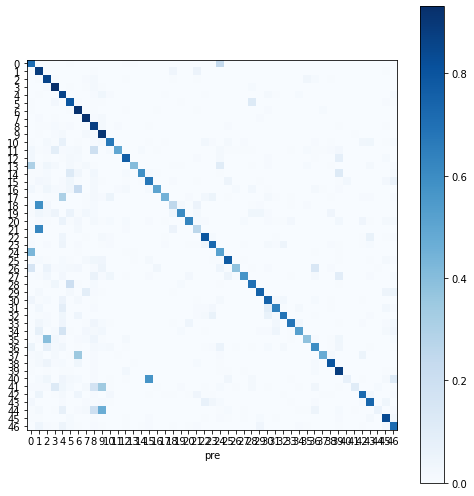

----- Epoch 1/29, lr=0.000900 -----
Time since begun: 0m 10s
Train Loss: 0.5024, Train Acc: 0.8317
Val Loss: 0.4175, val Acc: 0.8565
++++++F1+++++: 0.7799490298536782
Confusion matrix


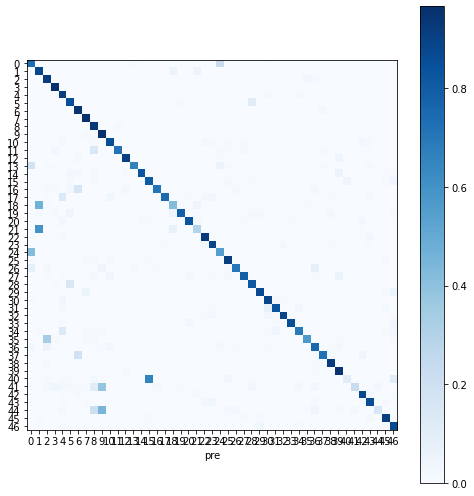

----- Epoch 2/29, lr=0.000810 -----
Time since begun: 0m 16s
Train Loss: 0.4474, Train Acc: 0.8474
Val Loss: 0.3923, val Acc: 0.8652
++++++F1+++++: 0.8012891559094918
Confusion matrix


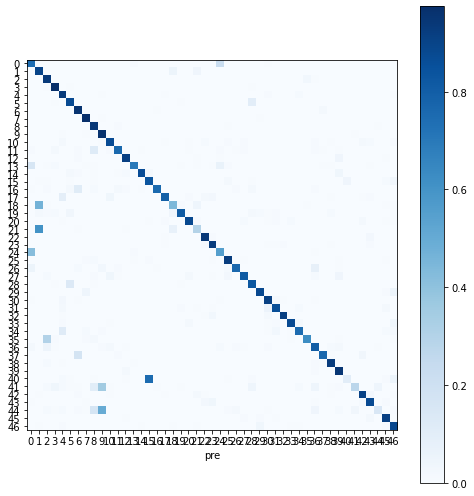

----- Epoch 3/29, lr=0.000729 -----
Time since begun: 0m 21s
Train Loss: 0.4120, Train Acc: 0.8577
Val Loss: 0.3757, val Acc: 0.8689
++++++F1+++++: 0.8166479399775418
Confusion matrix


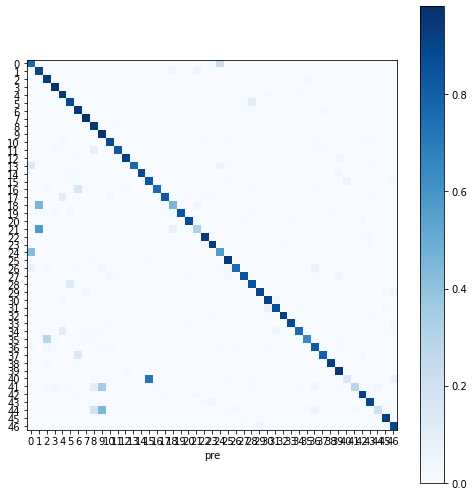

----- Epoch 4/29, lr=0.000656 -----
Time since begun: 0m 27s
Train Loss: 0.3951, Train Acc: 0.8617
Val Loss: 0.3426, val Acc: 0.8784
++++++F1+++++: 0.8234878040304857
Confusion matrix


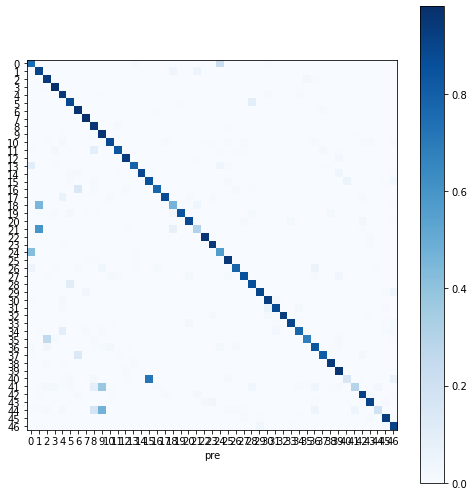

----- Epoch 5/29, lr=0.000590 -----
Time since begun: 0m 32s
Train Loss: 0.3821, Train Acc: 0.8662
Val Loss: 0.3235, val Acc: 0.8838
++++++F1+++++: 0.8303431382388562
Confusion matrix


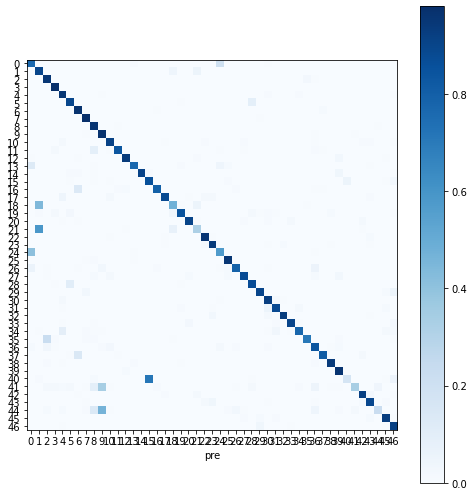

----- Epoch 6/29, lr=0.000531 -----
Time since begun: 0m 38s
Train Loss: 0.3662, Train Acc: 0.8713
Val Loss: 0.3243, val Acc: 0.8802
++++++F1+++++: 0.8367376148069396
Confusion matrix


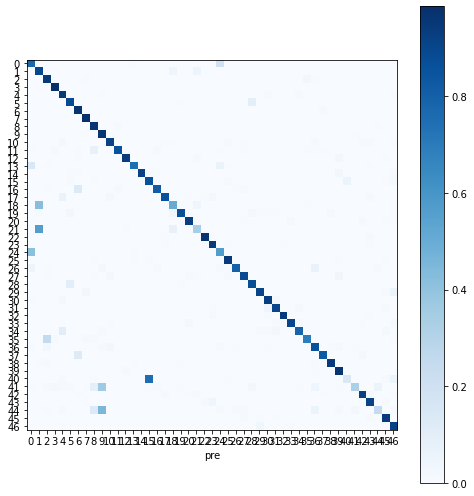

----- Epoch 7/29, lr=0.000478 -----
Time since begun: 0m 43s
Train Loss: 0.3554, Train Acc: 0.8739
Val Loss: 0.3130, val Acc: 0.8854
++++++F1+++++: 0.8406696876187928
Confusion matrix


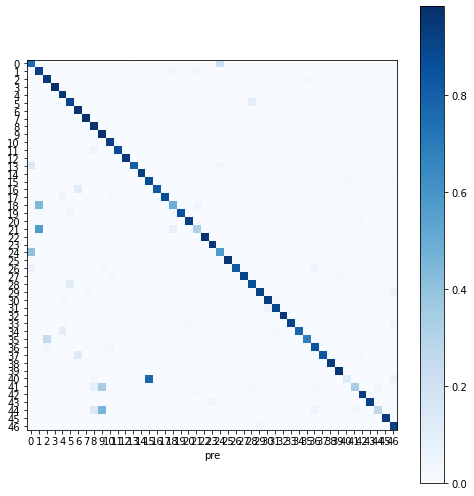

----- Epoch 8/29, lr=0.000430 -----
Time since begun: 0m 49s
Train Loss: 0.3470, Train Acc: 0.8773
Val Loss: 0.3174, val Acc: 0.8806
++++++F1+++++: 0.8471664672621843
Confusion matrix


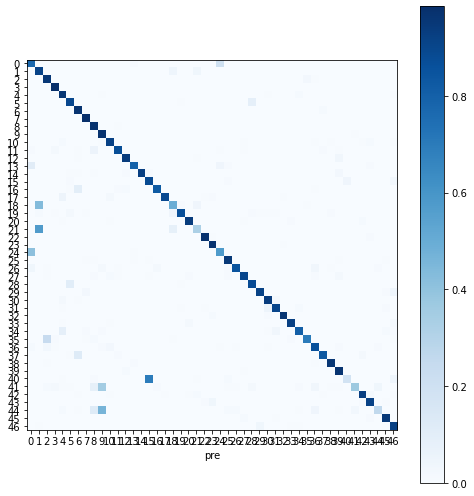

----- Epoch 9/29, lr=0.000387 -----
Time since begun: 0m 54s
Train Loss: 0.3400, Train Acc: 0.8774
Val Loss: 0.2972, val Acc: 0.8911
++++++F1+++++: 0.8473994078047185
Confusion matrix


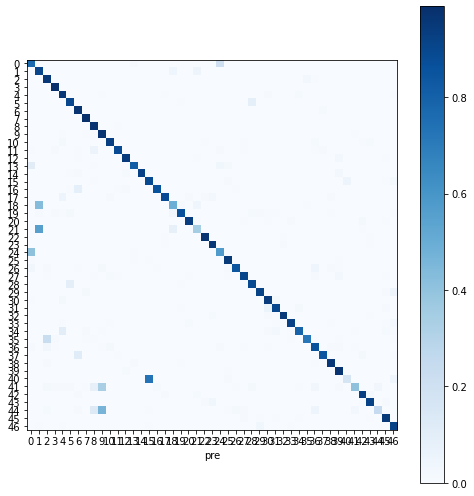

----- Epoch 10/29, lr=0.000349 -----
Time since begun: 1m 0s
Train Loss: 0.3360, Train Acc: 0.8788
Val Loss: 0.3042, val Acc: 0.8915
++++++F1+++++: 0.8488068005540551
Confusion matrix


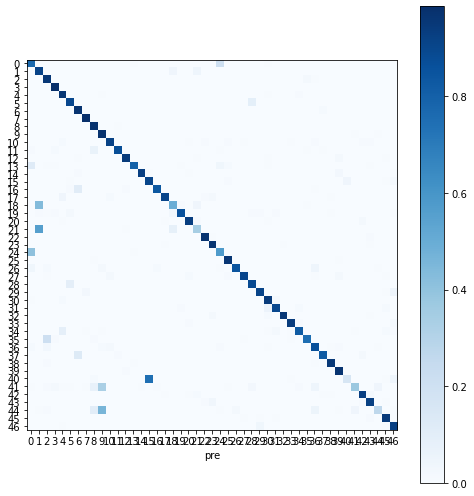

----- Epoch 11/29, lr=0.000314 -----
Time since begun: 1m 5s
Train Loss: 0.3301, Train Acc: 0.8808
Val Loss: 0.2950, val Acc: 0.8922
++++++F1+++++: 0.8533612436032042
Confusion matrix


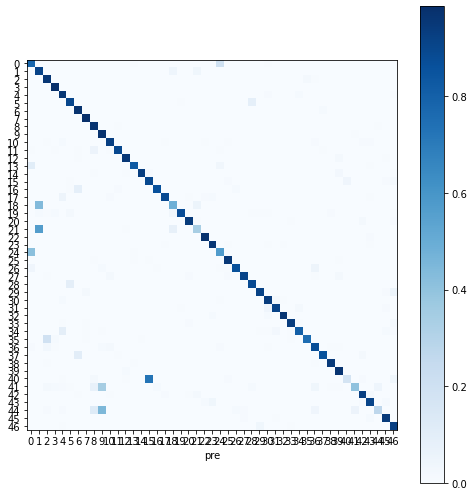

----- Epoch 12/29, lr=0.000282 -----
Time since begun: 1m 11s
Train Loss: 0.3254, Train Acc: 0.8820
Val Loss: 0.2911, val Acc: 0.8908
++++++F1+++++: 0.8547899785242329
Confusion matrix


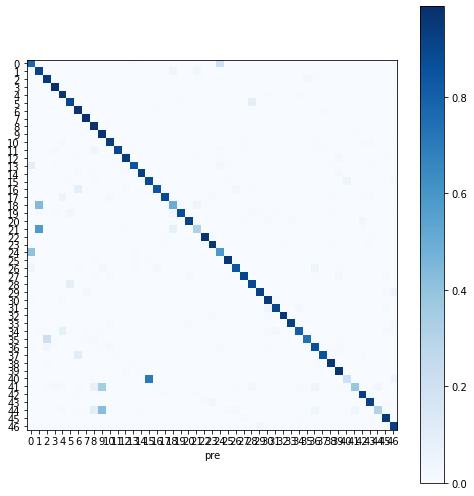

----- Epoch 13/29, lr=0.000254 -----
Time since begun: 1m 16s
Train Loss: 0.3203, Train Acc: 0.8838
Val Loss: 0.2889, val Acc: 0.8920
++++++F1+++++: 0.8547029373241855
Confusion matrix


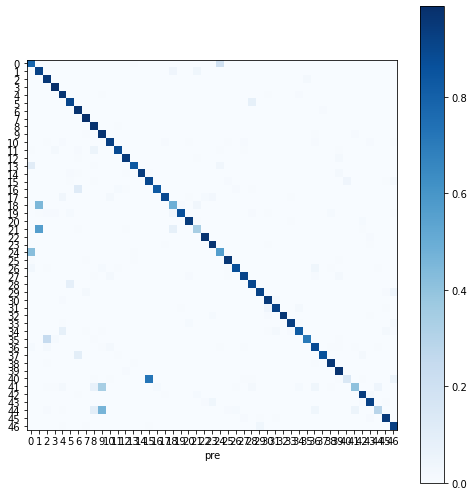

----- Epoch 14/29, lr=0.000229 -----
Time since begun: 1m 22s
Train Loss: 0.3185, Train Acc: 0.8843
Val Loss: 0.2754, val Acc: 0.8989
++++++F1+++++: 0.85663133943805
Confusion matrix


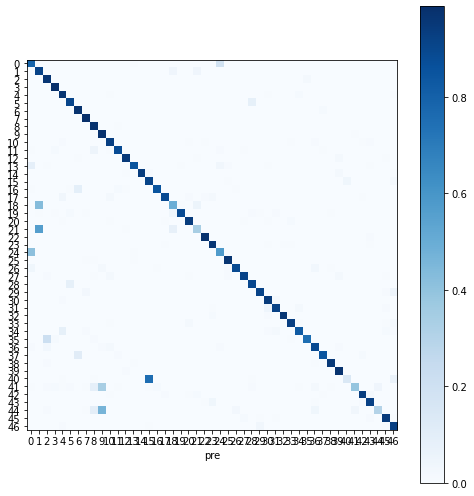

----- Epoch 15/29, lr=0.000206 -----
Time since begun: 1m 27s
Train Loss: 0.3133, Train Acc: 0.8855
Val Loss: 0.2844, val Acc: 0.8920
++++++F1+++++: 0.8583960981948137
Confusion matrix


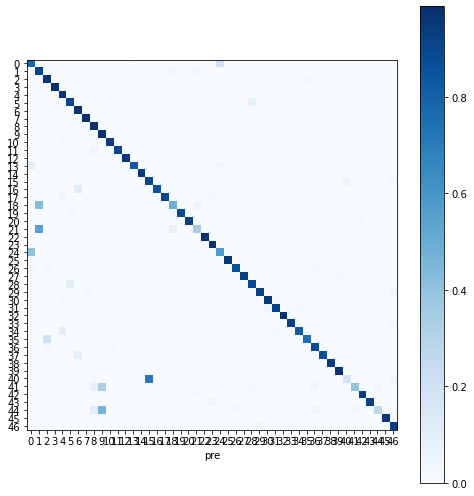

----- Epoch 16/29, lr=0.000185 -----
Time since begun: 1m 33s
Train Loss: 0.3135, Train Acc: 0.8864
Val Loss: 0.2706, val Acc: 0.8983
++++++F1+++++: 0.8582302213984392
Confusion matrix


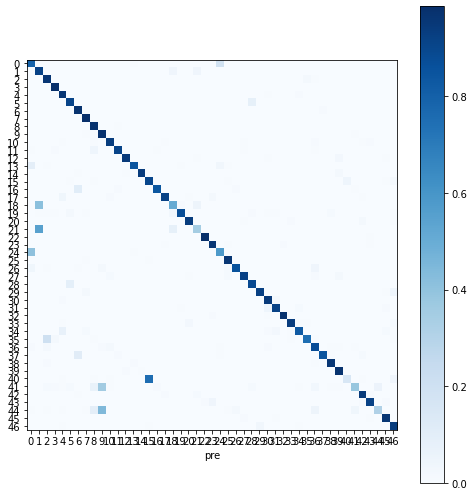

----- Epoch 17/29, lr=0.000167 -----
Time since begun: 1m 38s
Train Loss: 0.3122, Train Acc: 0.8861
Val Loss: 0.2676, val Acc: 0.8992
++++++F1+++++: 0.8600640927923204
Confusion matrix


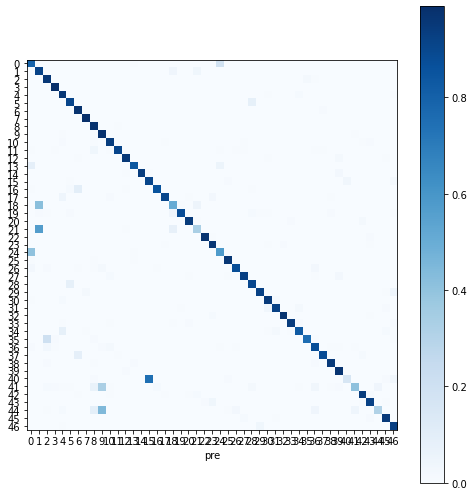

----- Epoch 18/29, lr=0.000150 -----
Time since begun: 1m 44s
Train Loss: 0.3081, Train Acc: 0.8879
Val Loss: 0.2708, val Acc: 0.8991
++++++F1+++++: 0.8633800784911801
Confusion matrix


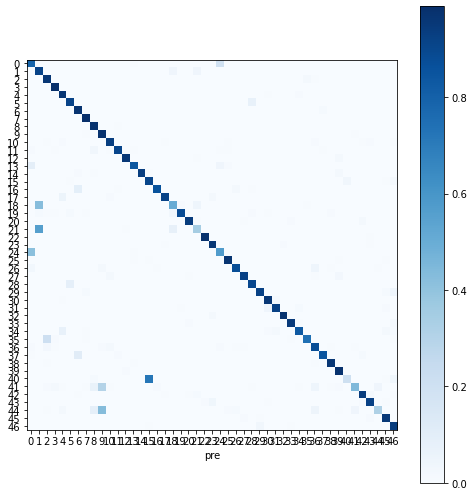

----- Epoch 19/29, lr=0.000135 -----
Time since begun: 1m 49s
Train Loss: 0.3061, Train Acc: 0.8887
Val Loss: 0.2648, val Acc: 0.8996
++++++F1+++++: 0.8636164179219843
Confusion matrix


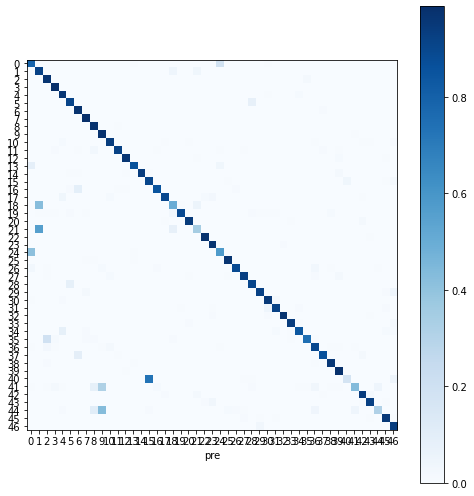

----- Epoch 20/29, lr=0.000122 -----
Time since begun: 1m 55s
Train Loss: 0.3017, Train Acc: 0.8891
Val Loss: 0.2766, val Acc: 0.8951
++++++F1+++++: 0.8652150144044725
Confusion matrix


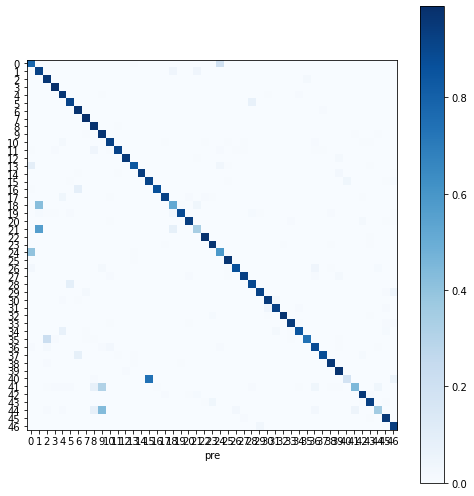

----- Epoch 21/29, lr=0.000109 -----
Time since begun: 2m 0s
Train Loss: 0.2973, Train Acc: 0.8906
Val Loss: 0.2722, val Acc: 0.8965
++++++F1+++++: 0.8655638104009455
Confusion matrix


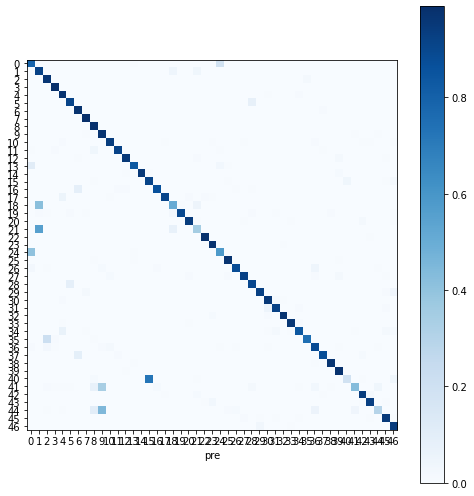

----- Epoch 22/29, lr=0.000098 -----
Time since begun: 2m 6s
Train Loss: 0.2991, Train Acc: 0.8899
Val Loss: 0.2712, val Acc: 0.8996
++++++F1+++++: 0.8649434666276308
Confusion matrix


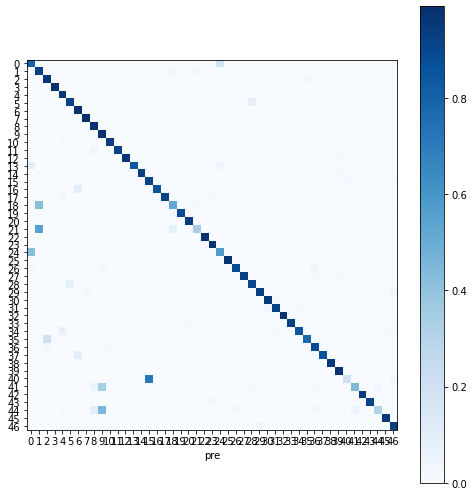

----- Epoch 23/29, lr=0.000089 -----
Time since begun: 2m 11s
Train Loss: 0.2972, Train Acc: 0.8905
Val Loss: 0.2712, val Acc: 0.8989
++++++F1+++++: 0.8639337029205273
Confusion matrix


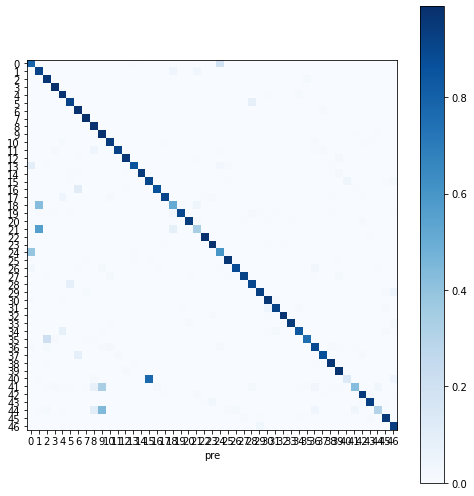

----- Epoch 24/29, lr=0.000080 -----
Time since begun: 2m 17s
Train Loss: 0.3004, Train Acc: 0.8890
Val Loss: 0.2549, val Acc: 0.9032
++++++F1+++++: 0.8646613556577792
Confusion matrix


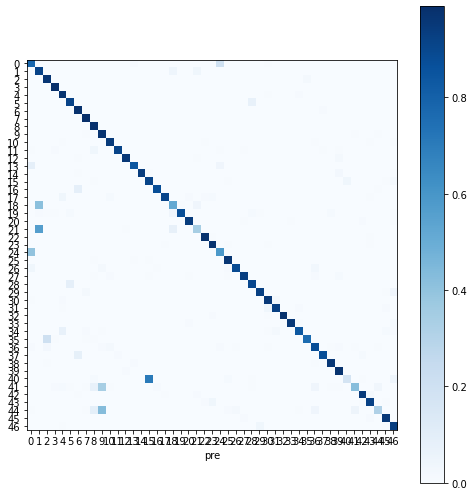

----- Epoch 25/29, lr=0.000072 -----
Time since begun: 2m 22s
Train Loss: 0.2995, Train Acc: 0.8904
Val Loss: 0.2643, val Acc: 0.8996
++++++F1+++++: 0.8643491998478017
Confusion matrix


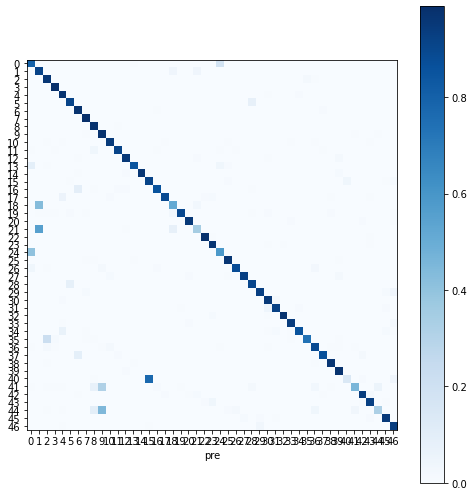

----- Epoch 26/29, lr=0.000065 -----
Time since begun: 2m 28s
Train Loss: 0.2956, Train Acc: 0.8909
Val Loss: 0.2616, val Acc: 0.9026
++++++F1+++++: 0.8674920822316139
Confusion matrix


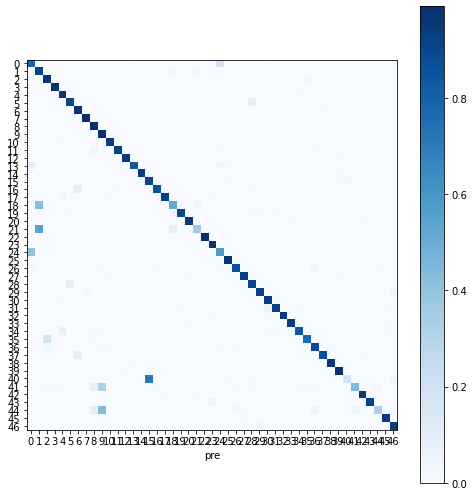

----- Epoch 27/29, lr=0.000058 -----
Time since begun: 2m 33s
Train Loss: 0.2958, Train Acc: 0.8907
Val Loss: 0.2573, val Acc: 0.9052
++++++F1+++++: 0.8671522887590478
Confusion matrix


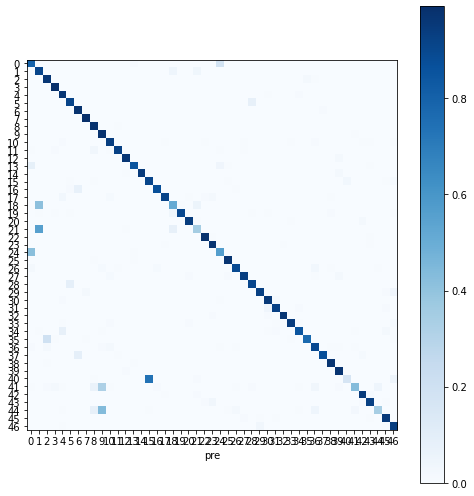

----- Epoch 28/29, lr=0.000052 -----
Time since begun: 2m 39s
Train Loss: 0.2944, Train Acc: 0.8914
Val Loss: 0.2576, val Acc: 0.9021
++++++F1+++++: 0.868044482718925
Confusion matrix


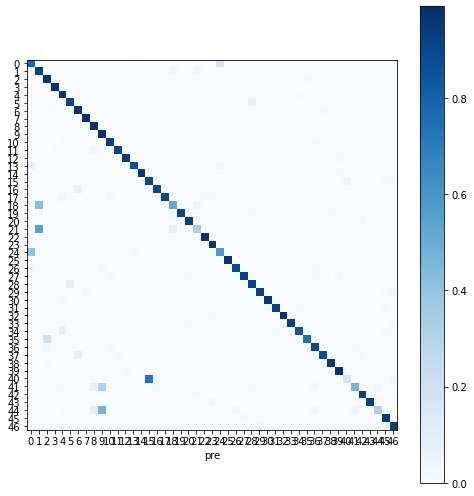

----- Epoch 29/29, lr=0.000047 -----
Time since begun: 2m 44s
Train Loss: 0.2950, Train Acc: 0.8912
Val Loss: 0.2536, val Acc: 0.9008
++++++F1+++++: 0.8671165051600043
Confusion matrix


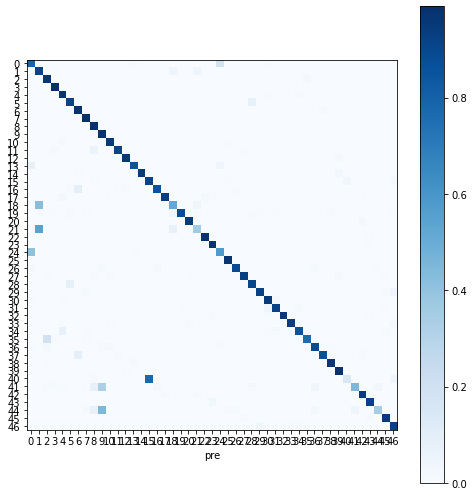

===== Best: epoch 27 =====
Train Loss: 0.2958, Train Acc: 0.8907
Val Loss: 0.2573, val Acc: 0.9052
Accuracy on test set is 88.83 %


In [63]:
cnn, train_process, acc = test_one_model(True, 0, True,torch.optim.Adam, 0.001, lr_factor=0.9)#dropout=0

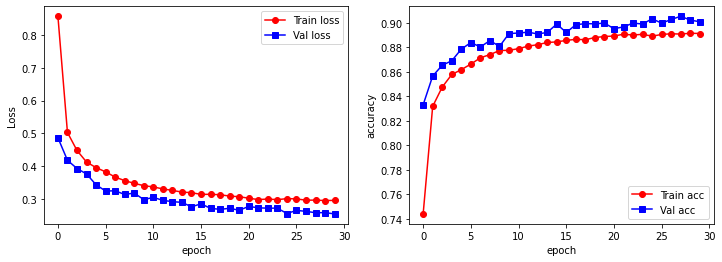

In [64]:
acc_plot(train_process)

## Test4

----- Epoch 0/29, lr=0.001000 -----
Time since begun: 0m 4s
Train Loss: 0.7644, Train Acc: 0.7707
Val Loss: 0.4716, val Acc: 0.8408
++++++F1+++++: 0.6990471035341825
Confusion matrix


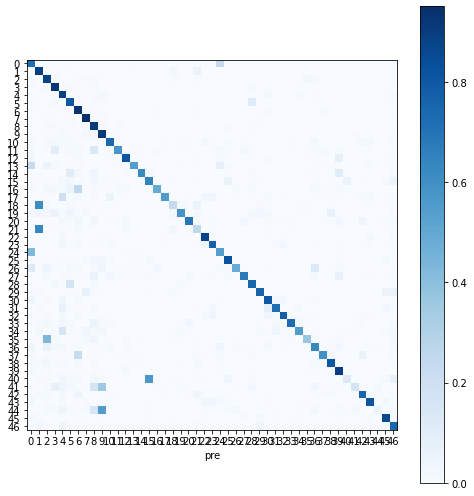

----- Epoch 1/29, lr=0.000900 -----
Time since begun: 0m 9s
Train Loss: 0.4255, Train Acc: 0.8560
Val Loss: 0.3829, val Acc: 0.8651
++++++F1+++++: 0.8154592902665732
Confusion matrix


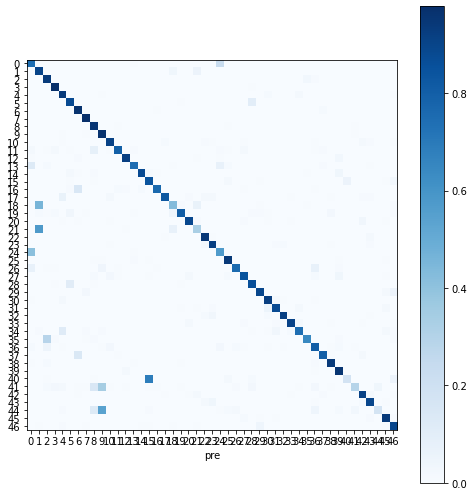

----- Epoch 2/29, lr=0.000810 -----
Time since begun: 0m 14s
Train Loss: 0.3708, Train Acc: 0.8700
Val Loss: 0.3848, val Acc: 0.8653
++++++F1+++++: 0.8360119042314693
Confusion matrix


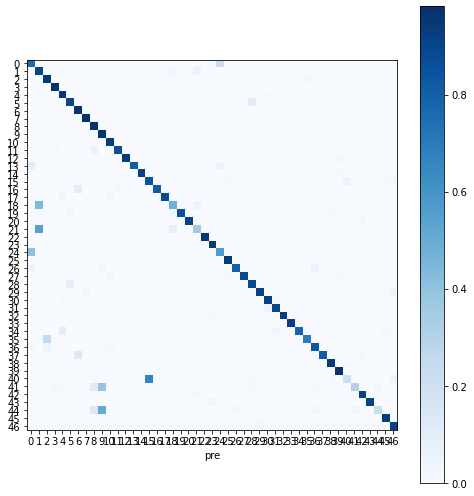

----- Epoch 3/29, lr=0.000729 -----
Time since begun: 0m 19s
Train Loss: 0.3474, Train Acc: 0.8766
Val Loss: 0.3426, val Acc: 0.8776
++++++F1+++++: 0.8470913074336862
Confusion matrix


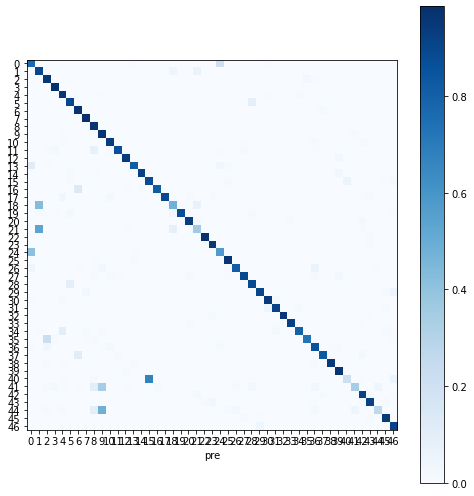

----- Epoch 4/29, lr=0.000656 -----
Time since begun: 0m 24s
Train Loss: 0.3295, Train Acc: 0.8818
Val Loss: 0.3309, val Acc: 0.8800
++++++F1+++++: 0.8553873466503635
Confusion matrix


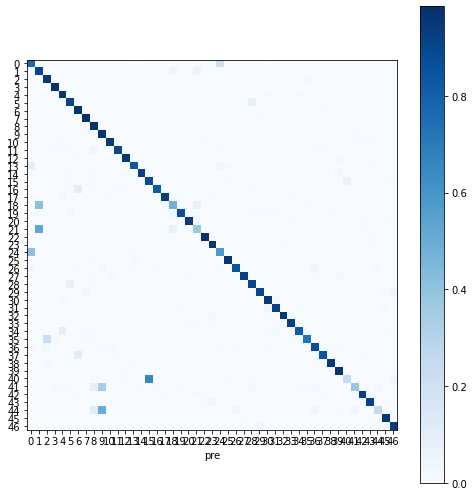

----- Epoch 5/29, lr=0.000590 -----
Time since begun: 0m 29s
Train Loss: 0.3152, Train Acc: 0.8857
Val Loss: 0.3050, val Acc: 0.8901
++++++F1+++++: 0.8590150102692894
Confusion matrix


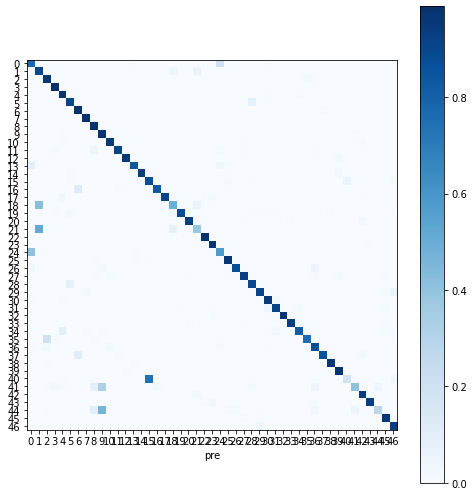

----- Epoch 6/29, lr=0.000531 -----
Time since begun: 0m 34s
Train Loss: 0.3018, Train Acc: 0.8907
Val Loss: 0.2960, val Acc: 0.8898
++++++F1+++++: 0.8662281851538326
Confusion matrix


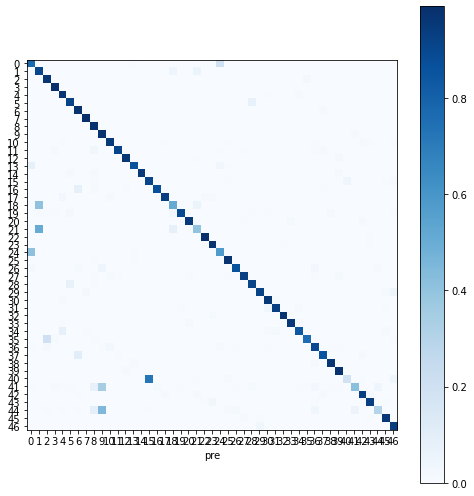

----- Epoch 7/29, lr=0.000478 -----
Time since begun: 0m 39s
Train Loss: 0.2894, Train Acc: 0.8939
Val Loss: 0.2900, val Acc: 0.8925
++++++F1+++++: 0.873288574378957
Confusion matrix


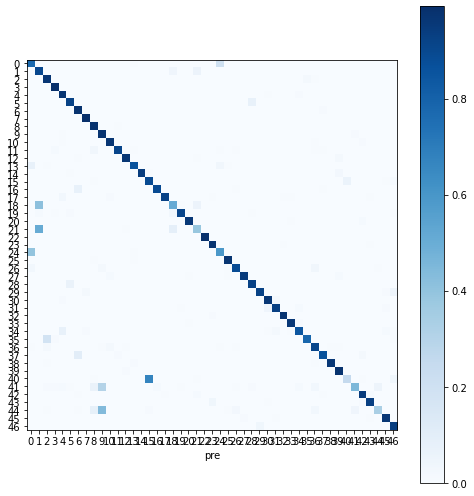

----- Epoch 8/29, lr=0.000430 -----
Time since begun: 0m 44s
Train Loss: 0.2836, Train Acc: 0.8946
Val Loss: 0.2808, val Acc: 0.8961
++++++F1+++++: 0.8750191421958264
Confusion matrix


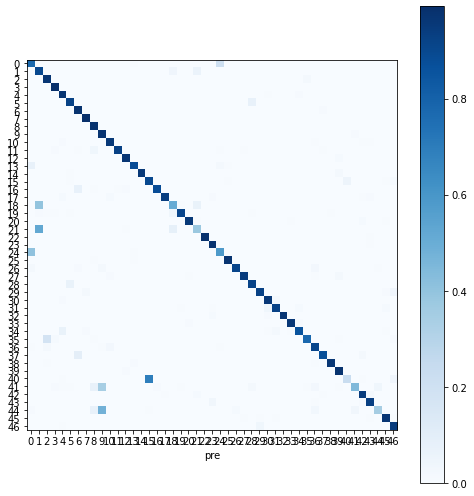

----- Epoch 9/29, lr=0.000387 -----
Time since begun: 0m 49s
Train Loss: 0.2765, Train Acc: 0.8984
Val Loss: 0.2704, val Acc: 0.8998
++++++F1+++++: 0.8787686351597974
Confusion matrix


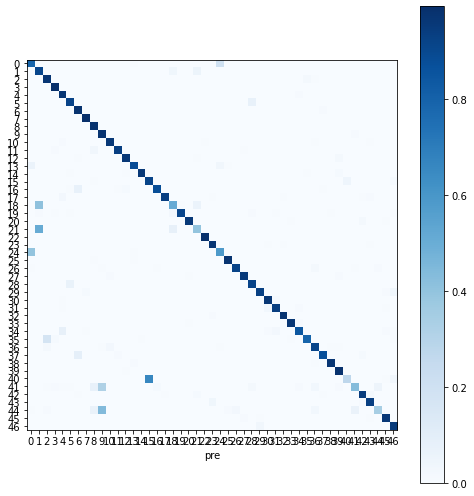

----- Epoch 10/29, lr=0.000349 -----
Time since begun: 0m 54s
Train Loss: 0.2683, Train Acc: 0.9009
Val Loss: 0.2771, val Acc: 0.8968
++++++F1+++++: 0.8835805648085207
Confusion matrix


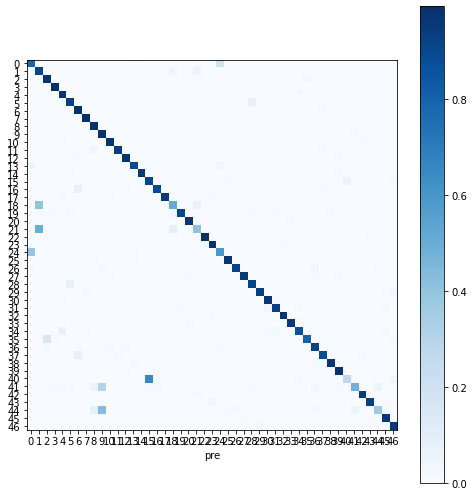

----- Epoch 11/29, lr=0.000314 -----
Time since begun: 0m 59s
Train Loss: 0.2615, Train Acc: 0.9013
Val Loss: 0.2653, val Acc: 0.9026
++++++F1+++++: 0.885837486809828
Confusion matrix


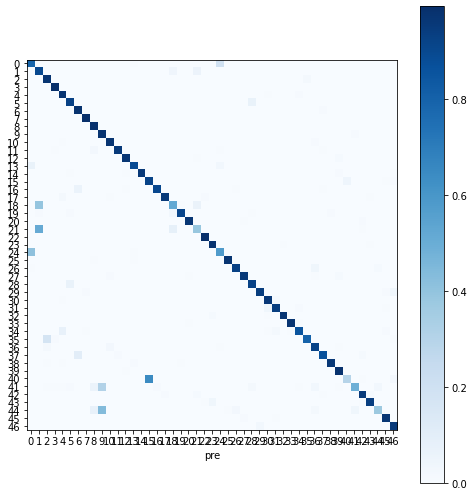

----- Epoch 12/29, lr=0.000282 -----
Time since begun: 1m 4s
Train Loss: 0.2582, Train Acc: 0.9041
Val Loss: 0.2598, val Acc: 0.9011
++++++F1+++++: 0.8885038916568722
Confusion matrix


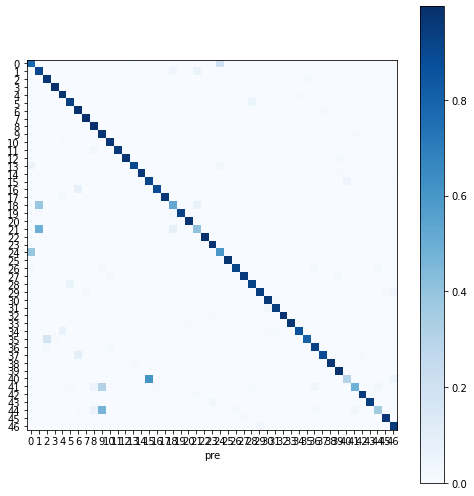

----- Epoch 13/29, lr=0.000254 -----
Time since begun: 1m 9s
Train Loss: 0.2533, Train Acc: 0.9051
Val Loss: 0.2532, val Acc: 0.9056
++++++F1+++++: 0.8913865537743735
Confusion matrix


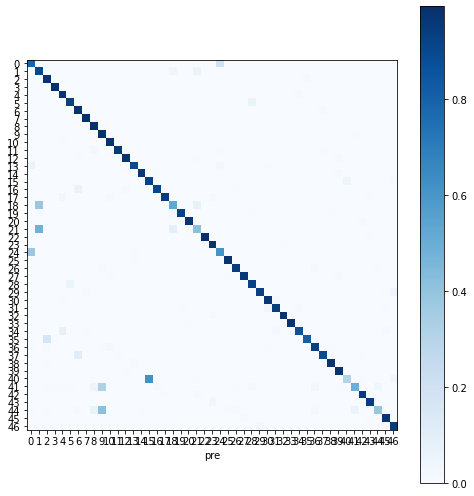

----- Epoch 14/29, lr=0.000229 -----
Time since begun: 1m 14s
Train Loss: 0.2499, Train Acc: 0.9049
Val Loss: 0.2493, val Acc: 0.9063
++++++F1+++++: 0.89171208199594
Confusion matrix


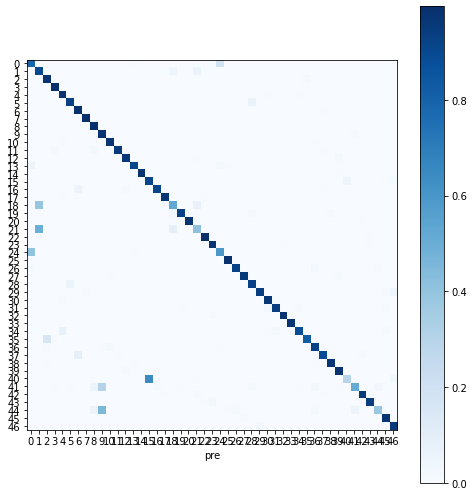

----- Epoch 15/29, lr=0.000206 -----
Time since begun: 1m 19s
Train Loss: 0.2458, Train Acc: 0.9072
Val Loss: 0.2454, val Acc: 0.9087
++++++F1+++++: 0.8930078080736175
Confusion matrix


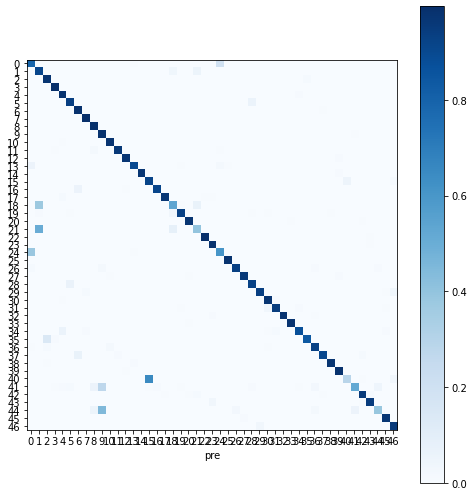

----- Epoch 16/29, lr=0.000185 -----
Time since begun: 1m 24s
Train Loss: 0.2430, Train Acc: 0.9089
Val Loss: 0.2418, val Acc: 0.9067
++++++F1+++++: 0.8974760827294533
Confusion matrix


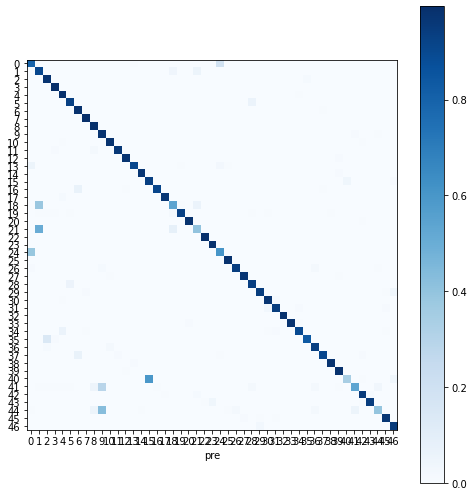

----- Epoch 17/29, lr=0.000167 -----
Time since begun: 1m 29s
Train Loss: 0.2403, Train Acc: 0.9096
Val Loss: 0.2360, val Acc: 0.9085
++++++F1+++++: 0.8969956110555332
Confusion matrix


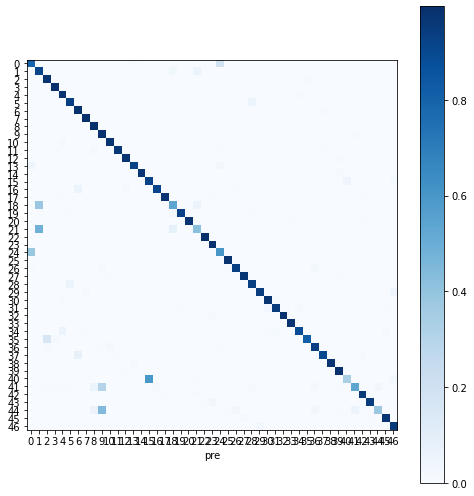

----- Epoch 18/29, lr=0.000150 -----
Time since begun: 1m 34s
Train Loss: 0.2368, Train Acc: 0.9107
Val Loss: 0.2388, val Acc: 0.9105
++++++F1+++++: 0.9007610283778527
Confusion matrix


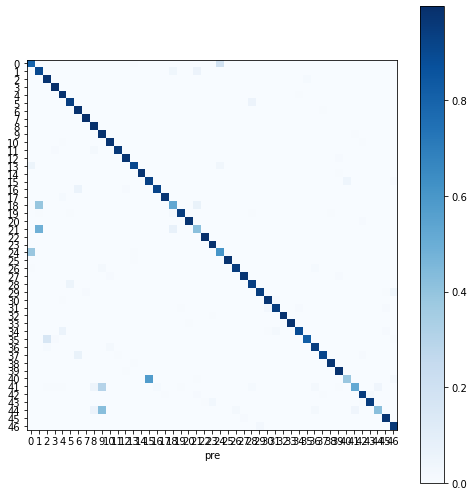

----- Epoch 19/29, lr=0.000135 -----
Time since begun: 1m 39s
Train Loss: 0.2346, Train Acc: 0.9111
Val Loss: 0.2348, val Acc: 0.9125
++++++F1+++++: 0.9012390717664359
Confusion matrix


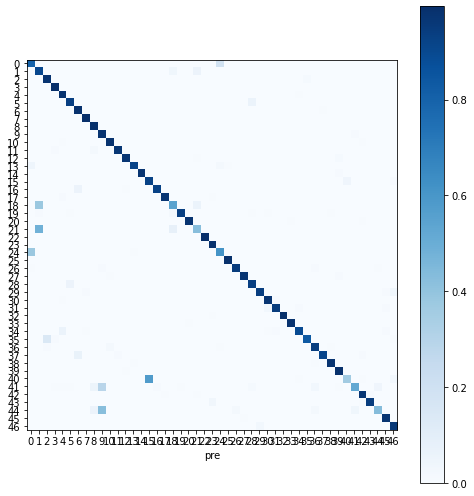

----- Epoch 20/29, lr=0.000122 -----
Time since begun: 1m 44s
Train Loss: 0.2341, Train Acc: 0.9114
Val Loss: 0.2296, val Acc: 0.9140
++++++F1+++++: 0.901580297987635
Confusion matrix


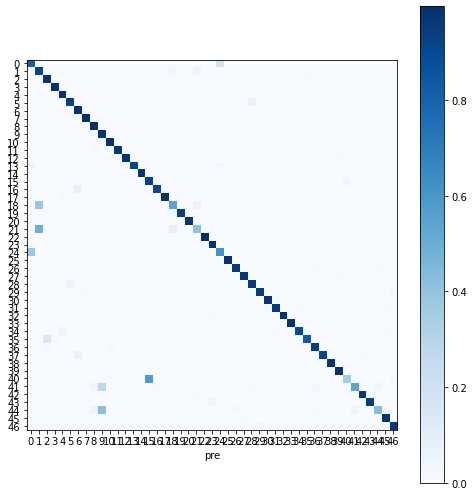

----- Epoch 21/29, lr=0.000109 -----
Time since begun: 1m 49s
Train Loss: 0.2307, Train Acc: 0.9126
Val Loss: 0.2291, val Acc: 0.9133
++++++F1+++++: 0.9027941426710079
Confusion matrix


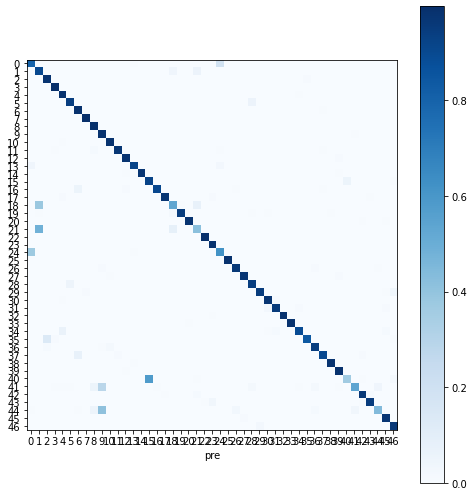

----- Epoch 22/29, lr=0.000098 -----
Time since begun: 1m 54s
Train Loss: 0.2276, Train Acc: 0.9130
Val Loss: 0.2333, val Acc: 0.9130
++++++F1+++++: 0.9037141033258842
Confusion matrix


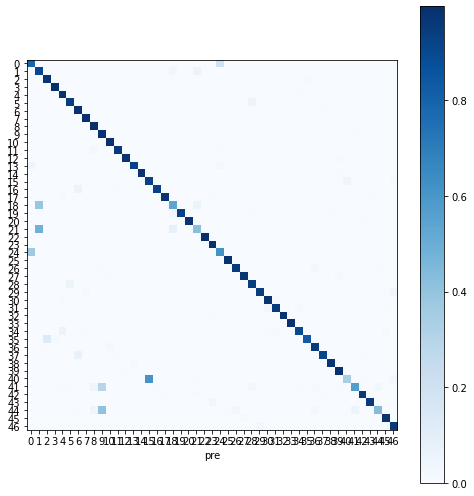

----- Epoch 23/29, lr=0.000089 -----
Time since begun: 1m 59s
Train Loss: 0.2280, Train Acc: 0.9128
Val Loss: 0.2251, val Acc: 0.9152
++++++F1+++++: 0.9030279849428511
Confusion matrix


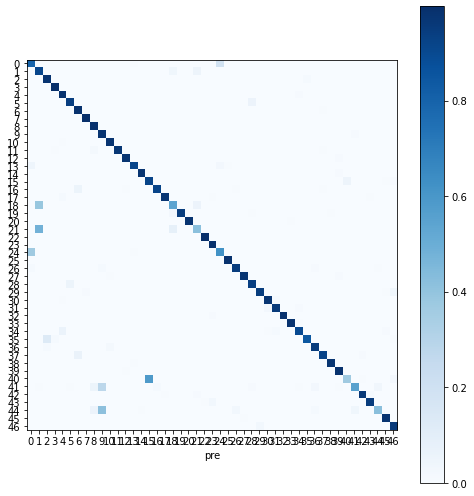

----- Epoch 24/29, lr=0.000080 -----
Time since begun: 2m 4s
Train Loss: 0.2261, Train Acc: 0.9140
Val Loss: 0.2244, val Acc: 0.9143
++++++F1+++++: 0.9049804824407003
Confusion matrix


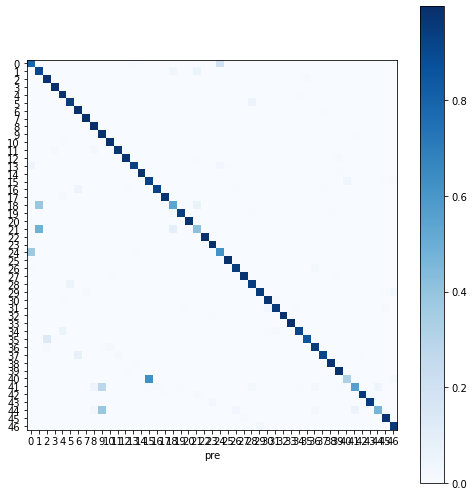

----- Epoch 25/29, lr=0.000072 -----
Time since begun: 2m 9s
Train Loss: 0.2233, Train Acc: 0.9149
Val Loss: 0.2286, val Acc: 0.9138
++++++F1+++++: 0.9055110086415059
Confusion matrix


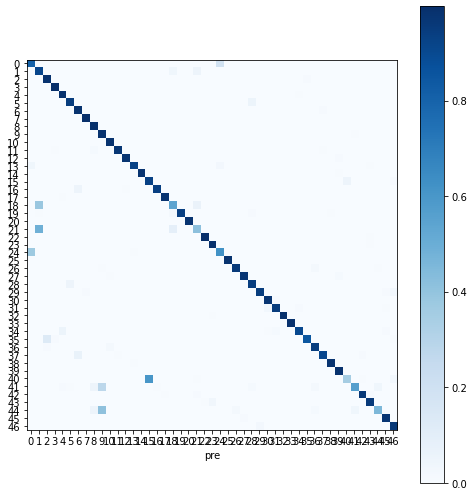

----- Epoch 26/29, lr=0.000065 -----
Time since begun: 2m 14s
Train Loss: 0.2231, Train Acc: 0.9156
Val Loss: 0.2238, val Acc: 0.9140
++++++F1+++++: 0.9071958350827714
Confusion matrix


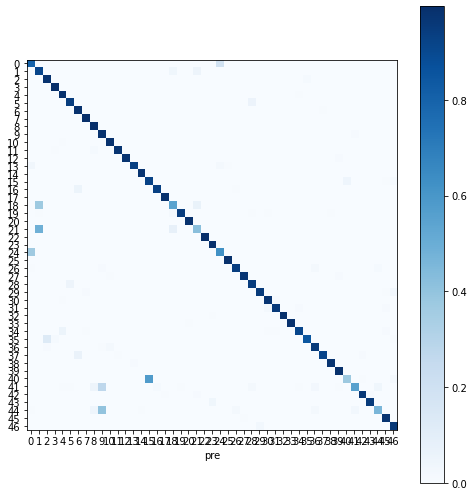

----- Epoch 27/29, lr=0.000058 -----
Time since begun: 2m 19s
Train Loss: 0.2222, Train Acc: 0.9151
Val Loss: 0.2215, val Acc: 0.9170
++++++F1+++++: 0.9072680912288955
Confusion matrix


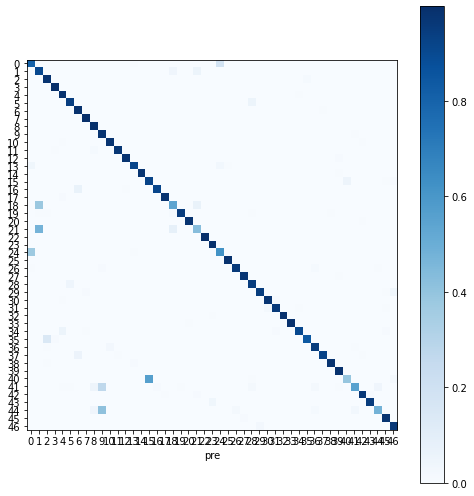

----- Epoch 28/29, lr=0.000052 -----
Time since begun: 2m 24s
Train Loss: 0.2219, Train Acc: 0.9156
Val Loss: 0.2173, val Acc: 0.9181
++++++F1+++++: 0.9064934426913135
Confusion matrix


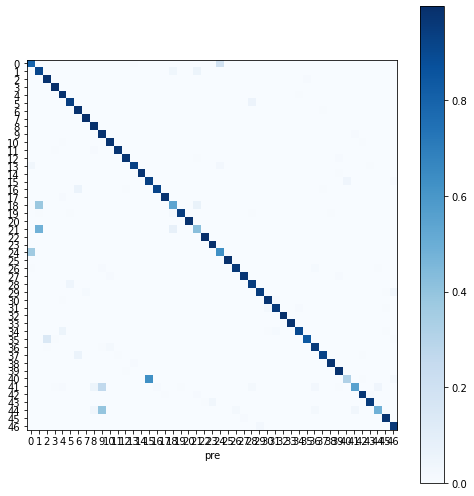

----- Epoch 29/29, lr=0.000047 -----
Time since begun: 2m 29s
Train Loss: 0.2211, Train Acc: 0.9157
Val Loss: 0.2163, val Acc: 0.9191
++++++F1+++++: 0.9077580763366446
Confusion matrix


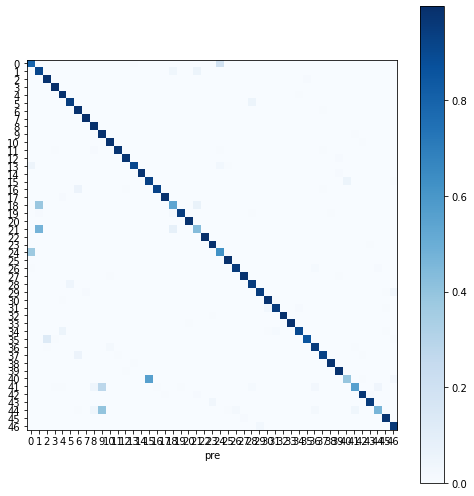

===== Best: epoch 29 =====
Train Loss: 0.2211, Train Acc: 0.9157
Val Loss: 0.2163, val Acc: 0.9191
Accuracy on test set is 88.70 %


In [65]:
cnn, train_process, acc = test_one_model(True, 0, False,torch.optim.Adam, 0.001, lr_factor=0.9)#dropout=0,distortion False

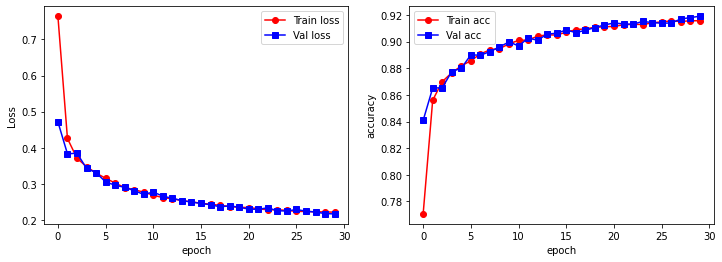

In [66]:
acc_plot(train_process)

## Test5

----- Epoch 0/29, lr=0.001000 -----
Time since begun: 0m 5s
Train Loss: 0.8198, Train Acc: 0.7525
Val Loss: 0.4599, val Acc: 0.8460
++++++F1+++++: 0.6752730388484252
Confusion matrix


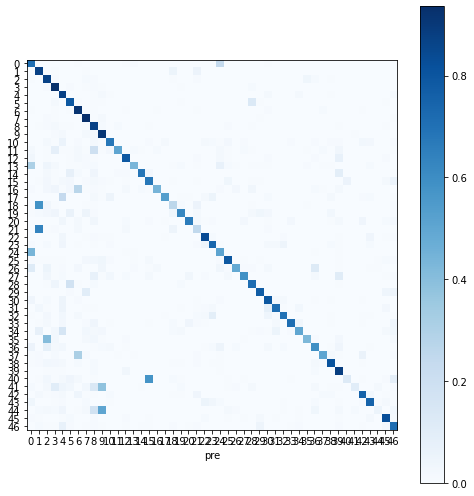

----- Epoch 1/29, lr=0.000900 -----
Time since begun: 0m 10s
Train Loss: 0.4793, Train Acc: 0.8395
Val Loss: 0.3995, val Acc: 0.8637
++++++F1+++++: 0.7889156415469735
Confusion matrix


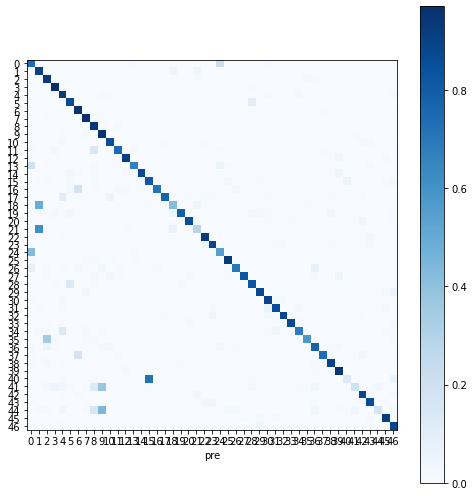

----- Epoch 2/29, lr=0.000810 -----
Time since begun: 0m 16s
Train Loss: 0.4235, Train Acc: 0.8538
Val Loss: 0.3693, val Acc: 0.8713
++++++F1+++++: 0.81120809346508
Confusion matrix


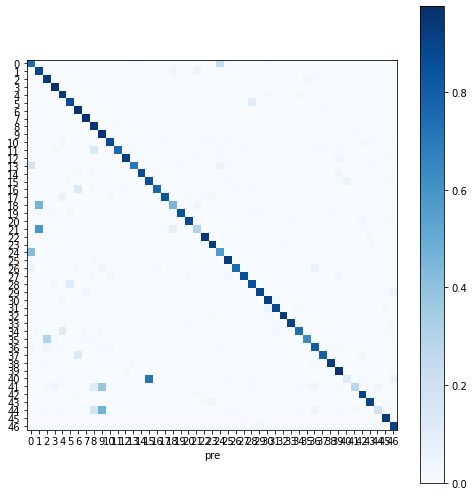

----- Epoch 3/29, lr=0.000729 -----
Time since begun: 0m 22s
Train Loss: 0.3974, Train Acc: 0.8616
Val Loss: 0.3543, val Acc: 0.8744
++++++F1+++++: 0.8225211932773746
Confusion matrix


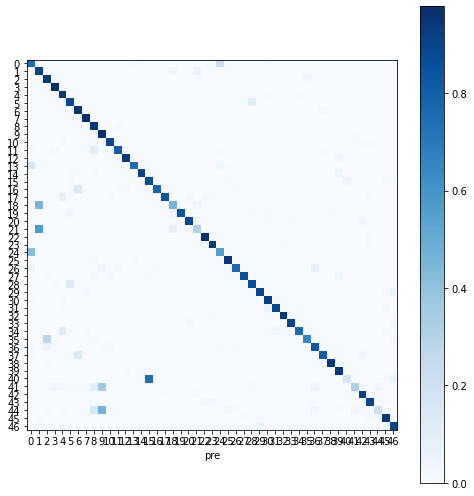

----- Epoch 4/29, lr=0.000656 -----
Time since begun: 0m 27s
Train Loss: 0.3826, Train Acc: 0.8655
Val Loss: 0.3314, val Acc: 0.8801
++++++F1+++++: 0.830037449260662
Confusion matrix


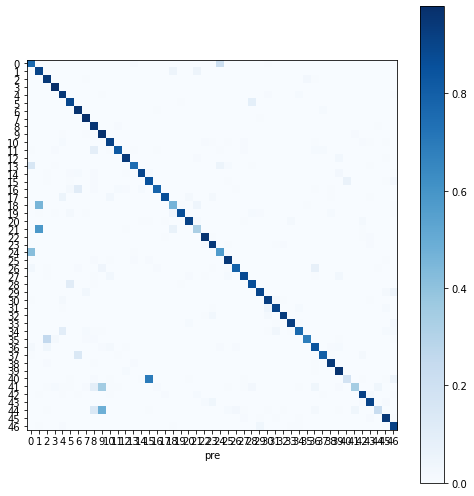

----- Epoch 5/29, lr=0.000590 -----
Time since begun: 0m 33s
Train Loss: 0.3670, Train Acc: 0.8702
Val Loss: 0.3249, val Acc: 0.8838
++++++F1+++++: 0.8354006129982656
Confusion matrix


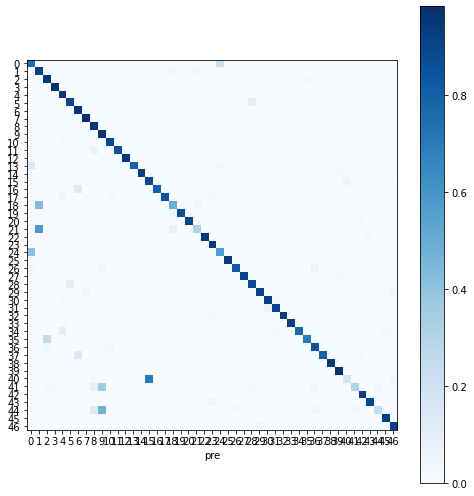

----- Epoch 6/29, lr=0.000531 -----
Time since begun: 0m 39s
Train Loss: 0.3563, Train Acc: 0.8724
Val Loss: 0.3154, val Acc: 0.8858
++++++F1+++++: 0.8390549098947977
Confusion matrix


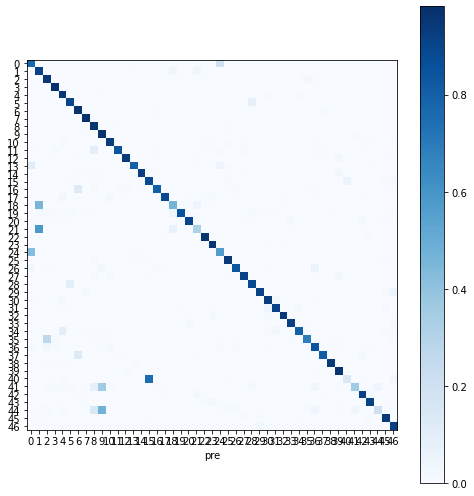

----- Epoch 7/29, lr=0.000478 -----
Time since begun: 0m 44s
Train Loss: 0.3484, Train Acc: 0.8753
Val Loss: 0.3034, val Acc: 0.8901
++++++F1+++++: 0.8438004738642769
Confusion matrix


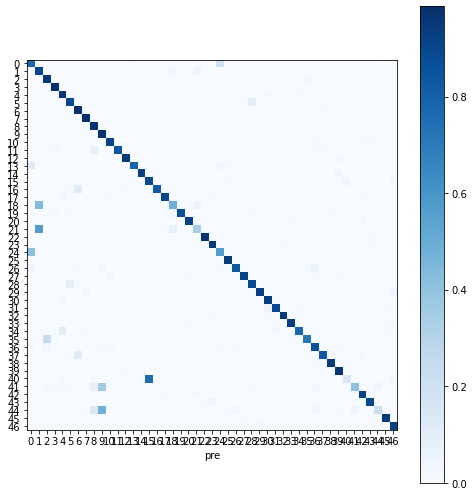

----- Epoch 8/29, lr=0.000430 -----
Time since begun: 0m 50s
Train Loss: 0.3389, Train Acc: 0.8779
Val Loss: 0.3072, val Acc: 0.8871
++++++F1+++++: 0.8474914540887991
Confusion matrix


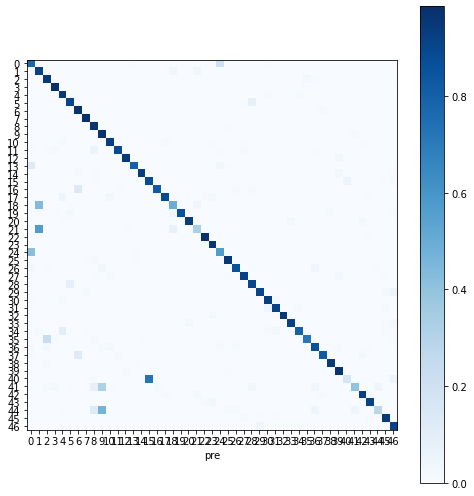

----- Epoch 9/29, lr=0.000387 -----
Time since begun: 0m 55s
Train Loss: 0.3319, Train Acc: 0.8792
Val Loss: 0.2943, val Acc: 0.8940
++++++F1+++++: 0.8489594415100333
Confusion matrix


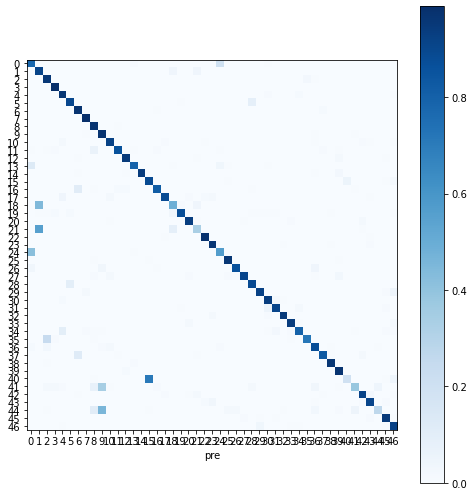

----- Epoch 10/29, lr=0.000349 -----
Time since begun: 1m 1s
Train Loss: 0.3261, Train Acc: 0.8812
Val Loss: 0.2902, val Acc: 0.8951
++++++F1+++++: 0.852539517725879
Confusion matrix


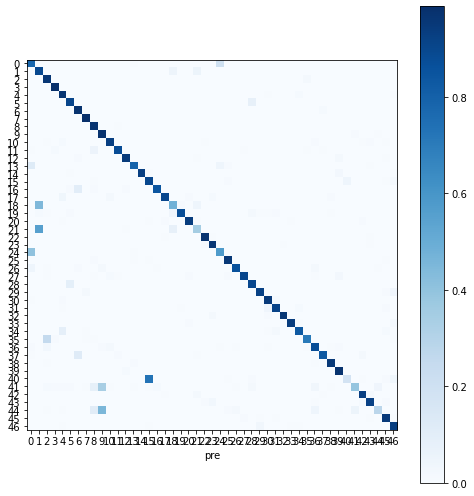

----- Epoch 11/29, lr=0.000314 -----
Time since begun: 1m 7s
Train Loss: 0.3218, Train Acc: 0.8813
Val Loss: 0.2852, val Acc: 0.8965
++++++F1+++++: 0.8535976736195784
Confusion matrix


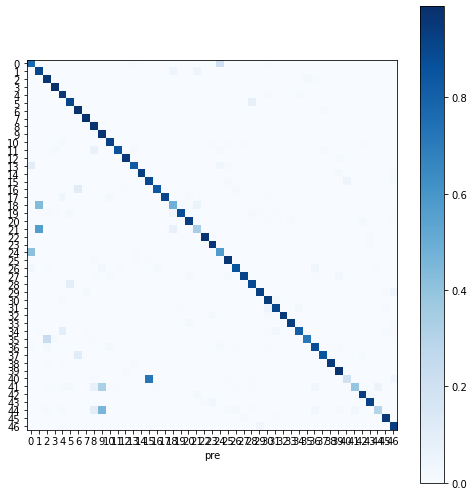

----- Epoch 12/29, lr=0.000282 -----
Time since begun: 1m 12s
Train Loss: 0.3173, Train Acc: 0.8832
Val Loss: 0.2793, val Acc: 0.8964
++++++F1+++++: 0.8581035707337026
Confusion matrix


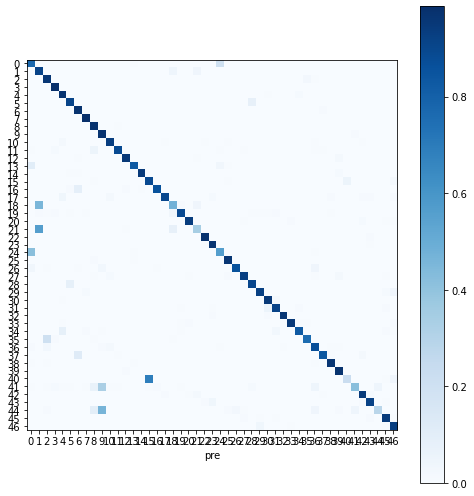

----- Epoch 13/29, lr=0.000254 -----
Time since begun: 1m 18s
Train Loss: 0.3126, Train Acc: 0.8853
Val Loss: 0.2799, val Acc: 0.8959
++++++F1+++++: 0.8603608716552523
Confusion matrix


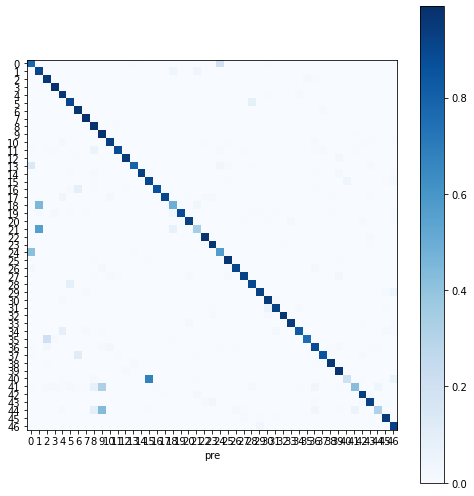

----- Epoch 14/29, lr=0.000229 -----
Time since begun: 1m 23s
Train Loss: 0.3094, Train Acc: 0.8861
Val Loss: 0.2695, val Acc: 0.8996
++++++F1+++++: 0.8615936480625024
Confusion matrix


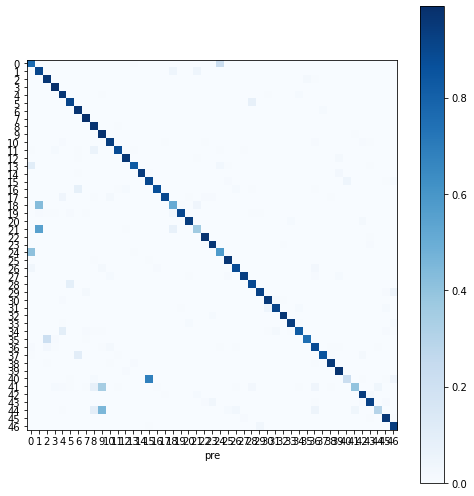

----- Epoch 15/29, lr=0.000206 -----
Time since begun: 1m 29s
Train Loss: 0.3040, Train Acc: 0.8887
Val Loss: 0.2701, val Acc: 0.8992
++++++F1+++++: 0.8635930053049716
Confusion matrix


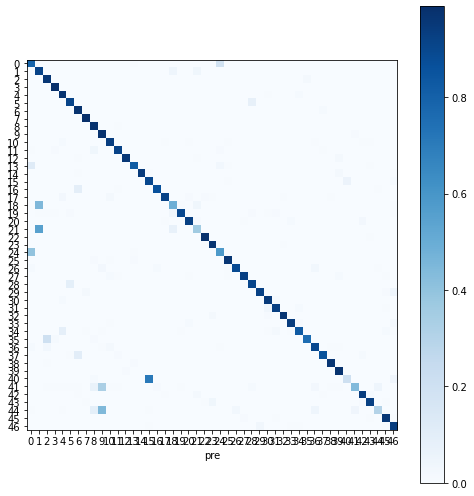

----- Epoch 16/29, lr=0.000185 -----
Time since begun: 1m 35s
Train Loss: 0.3004, Train Acc: 0.8895
Val Loss: 0.2696, val Acc: 0.8993
++++++F1+++++: 0.8655734924132683
Confusion matrix


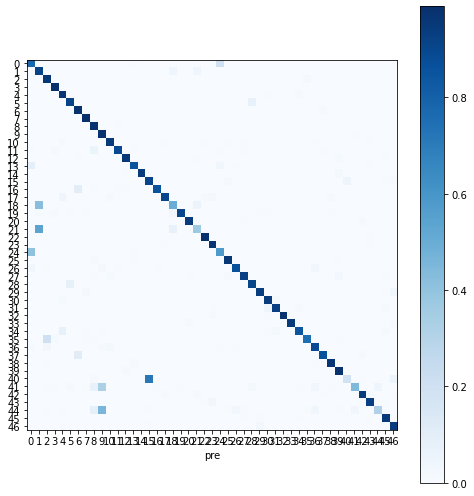

----- Epoch 17/29, lr=0.000167 -----
Time since begun: 1m 40s
Train Loss: 0.3009, Train Acc: 0.8893
Val Loss: 0.2668, val Acc: 0.9004
++++++F1+++++: 0.864977170548451
Confusion matrix


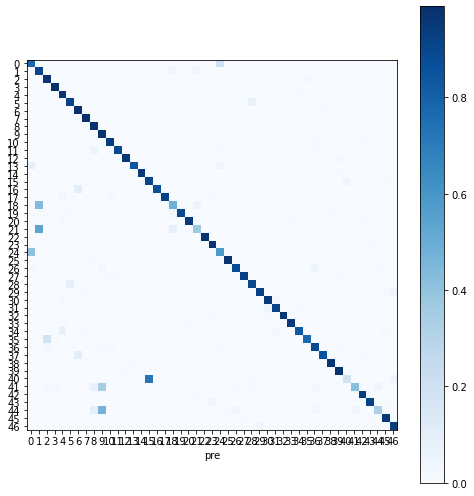

----- Epoch 18/29, lr=0.000150 -----
Time since begun: 1m 46s
Train Loss: 0.2986, Train Acc: 0.8891
Val Loss: 0.2606, val Acc: 0.9039
++++++F1+++++: 0.8663181512755671
Confusion matrix


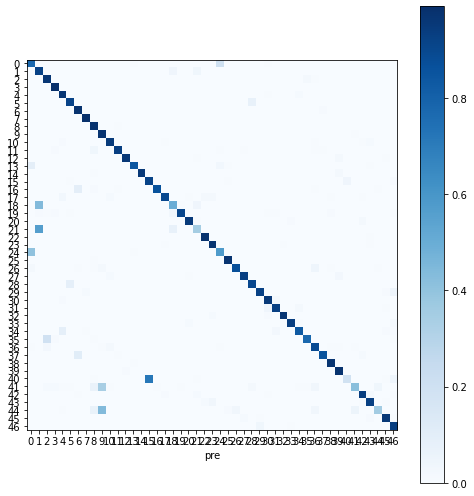

----- Epoch 19/29, lr=0.000135 -----
Time since begun: 1m 52s
Train Loss: 0.2957, Train Acc: 0.8912
Val Loss: 0.2626, val Acc: 0.9014
++++++F1+++++: 0.8681484560446919
Confusion matrix


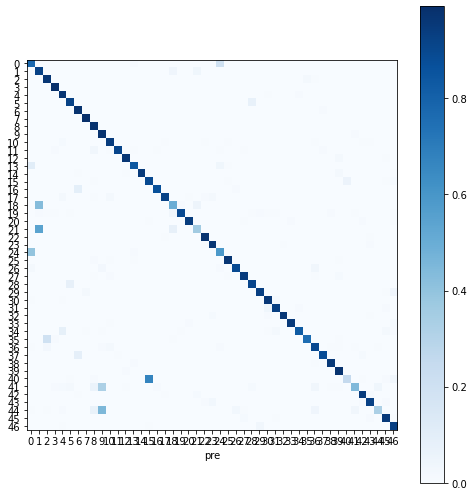

----- Epoch 20/29, lr=0.000122 -----
Time since begun: 1m 57s
Train Loss: 0.2973, Train Acc: 0.8898
Val Loss: 0.2571, val Acc: 0.9042
++++++F1+++++: 0.8661458993076963
Confusion matrix


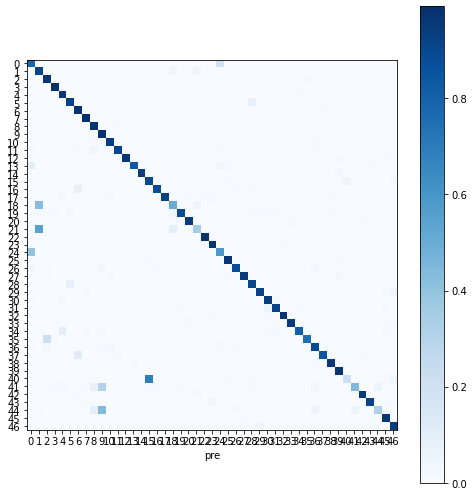

----- Epoch 21/29, lr=0.000109 -----
Time since begun: 2m 3s
Train Loss: 0.2936, Train Acc: 0.8909
Val Loss: 0.2490, val Acc: 0.9065
++++++F1+++++: 0.8694245860279892
Confusion matrix


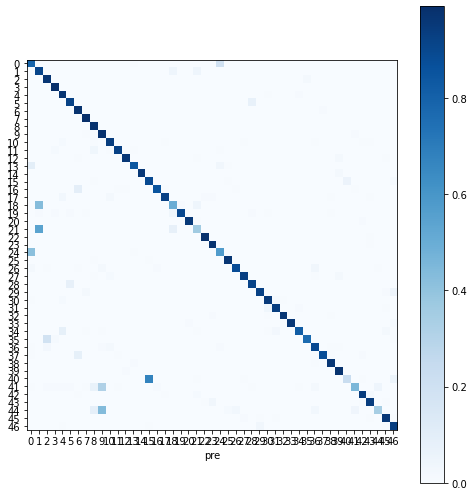

----- Epoch 22/29, lr=0.000098 -----
Time since begun: 2m 8s
Train Loss: 0.2926, Train Acc: 0.8921
Val Loss: 0.2493, val Acc: 0.9056
++++++F1+++++: 0.8698281773491203
Confusion matrix


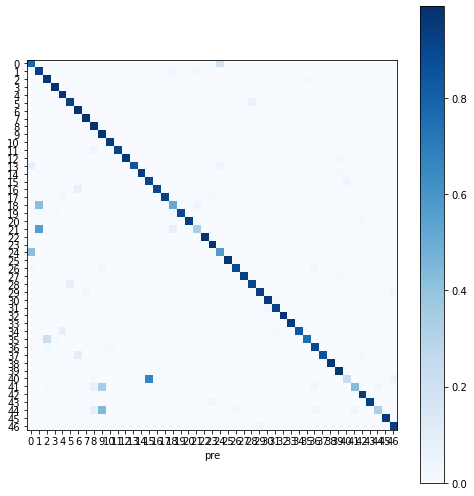

----- Epoch 23/29, lr=0.000089 -----
Time since begun: 2m 14s
Train Loss: 0.2906, Train Acc: 0.8912
Val Loss: 0.2517, val Acc: 0.9061
++++++F1+++++: 0.8689190399541257
Confusion matrix


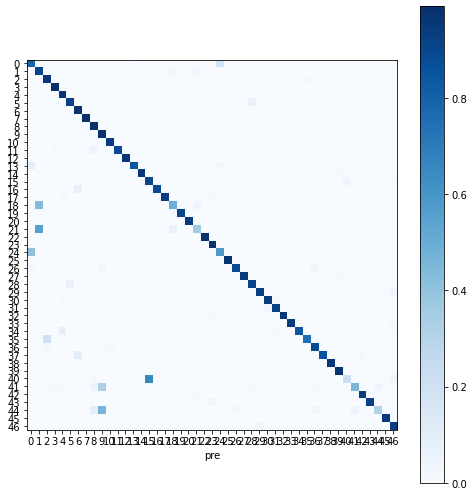

----- Epoch 24/29, lr=0.000080 -----
Time since begun: 2m 20s
Train Loss: 0.2879, Train Acc: 0.8929
Val Loss: 0.2565, val Acc: 0.9032
++++++F1+++++: 0.87033303450929
Confusion matrix


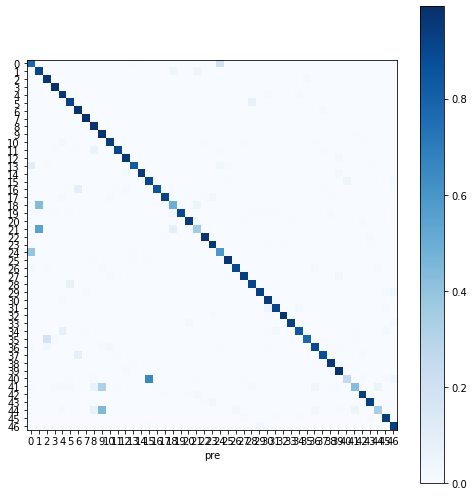

----- Epoch 25/29, lr=0.000072 -----
Time since begun: 2m 25s
Train Loss: 0.2906, Train Acc: 0.8914
Val Loss: 0.2464, val Acc: 0.9063
++++++F1+++++: 0.8703350041131842
Confusion matrix


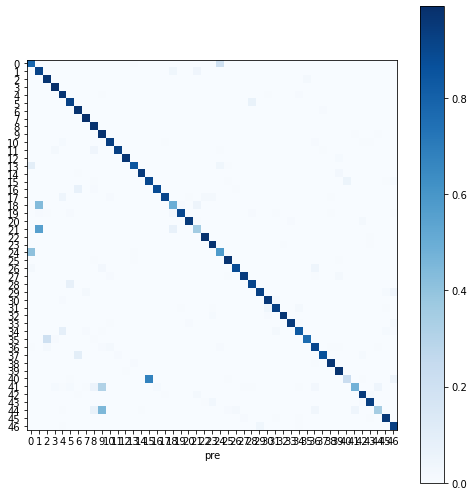

----- Epoch 26/29, lr=0.000065 -----
Time since begun: 2m 31s
Train Loss: 0.2870, Train Acc: 0.8932
Val Loss: 0.2553, val Acc: 0.9030
++++++F1+++++: 0.8713729969084576
Confusion matrix


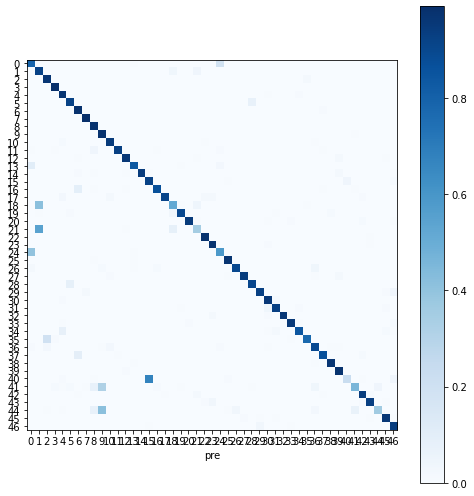

----- Epoch 27/29, lr=0.000058 -----
Time since begun: 2m 37s
Train Loss: 0.2853, Train Acc: 0.8943
Val Loss: 0.2526, val Acc: 0.9036
++++++F1+++++: 0.8735877063418096
Confusion matrix


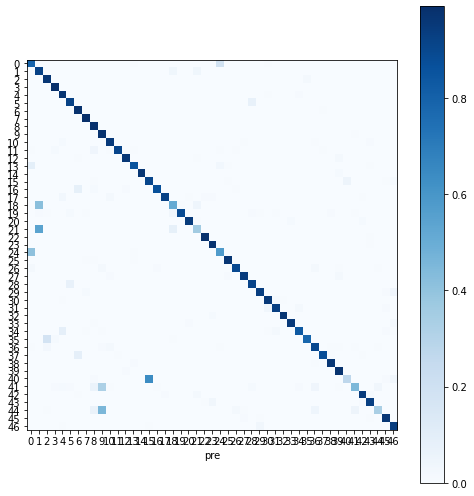

----- Epoch 28/29, lr=0.000052 -----
Time since begun: 2m 42s
Train Loss: 0.2860, Train Acc: 0.8933
Val Loss: 0.2489, val Acc: 0.9074
++++++F1+++++: 0.872915918712476
Confusion matrix


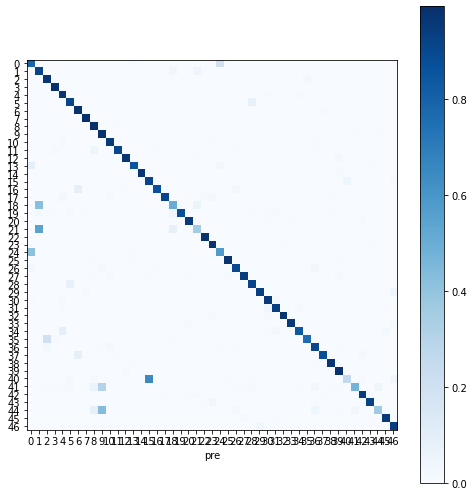

----- Epoch 29/29, lr=0.000047 -----
Time since begun: 2m 48s
Train Loss: 0.2822, Train Acc: 0.8935
Val Loss: 0.2552, val Acc: 0.9025
++++++F1+++++: 0.8729279893322208
Confusion matrix


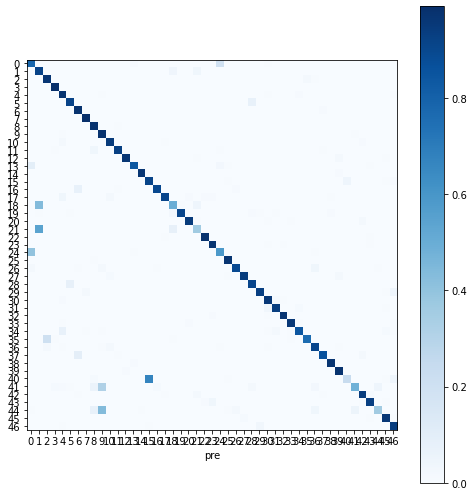

===== Best: epoch 28 =====
Train Loss: 0.2860, Train Acc: 0.8933
Val Loss: 0.2489, val Acc: 0.9074
Accuracy on test set is 89.08 %


In [67]:
cnn, train_process, acc = test_one_model(True, 0, True,torch.optim.NAdam, 0.001, lr_factor=0.9)#dropout=0,NAdam

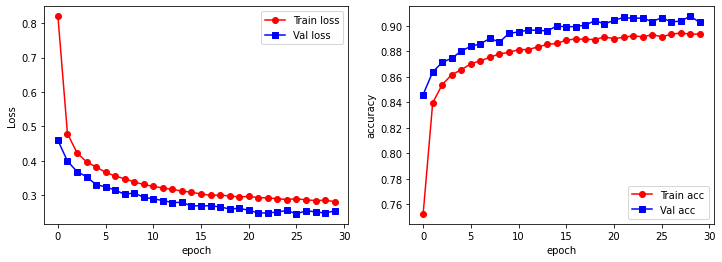

In [68]:
acc_plot(train_process)

## Test6

----- Epoch 0/29, lr=0.001000 -----
Time since begun: 0m 4s
Train Loss: 3.4235, Train Acc: 0.2100
Val Loss: 3.0478, val Acc: 0.3694
++++++F1+++++: 0.06412030174430028
Confusion matrix


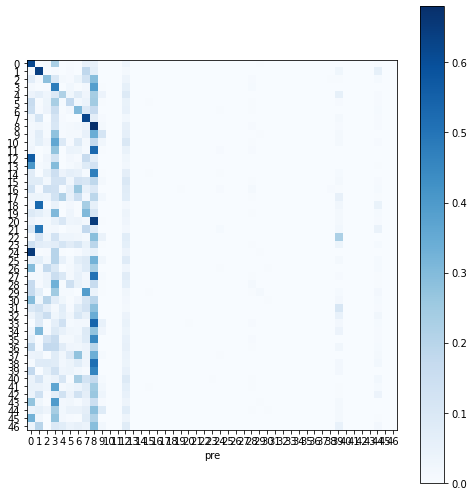

----- Epoch 1/29, lr=0.000900 -----
Time since begun: 0m 9s
Train Loss: 2.7770, Train Acc: 0.4031
Val Loss: 2.4454, val Acc: 0.4531
++++++F1+++++: 0.12997633135575076
Confusion matrix


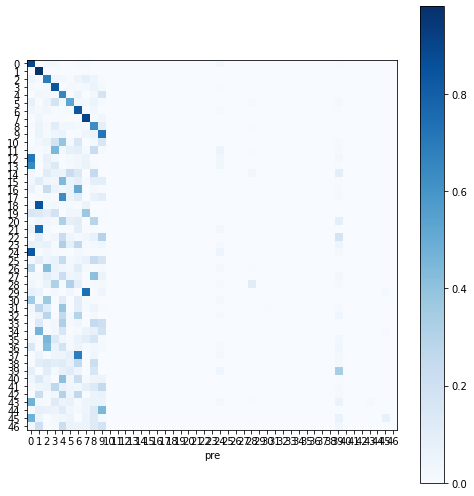

----- Epoch 2/29, lr=0.000810 -----
Time since begun: 0m 14s
Train Loss: 2.2994, Train Acc: 0.4684
Val Loss: 2.0269, val Acc: 0.5160
++++++F1+++++: 0.1798276898236943
Confusion matrix


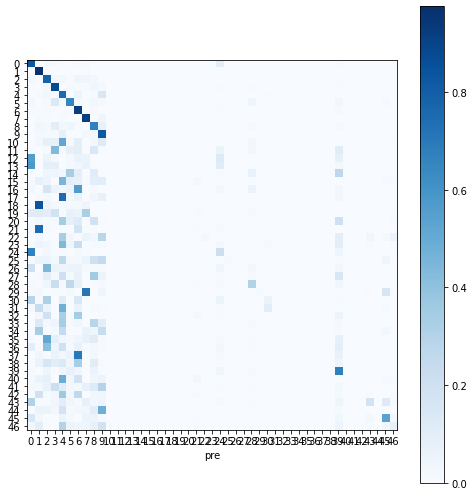

----- Epoch 3/29, lr=0.000729 -----
Time since begun: 0m 19s
Train Loss: 1.9811, Train Acc: 0.5171
Val Loss: 1.7807, val Acc: 0.5443
++++++F1+++++: 0.23012142946261813
Confusion matrix


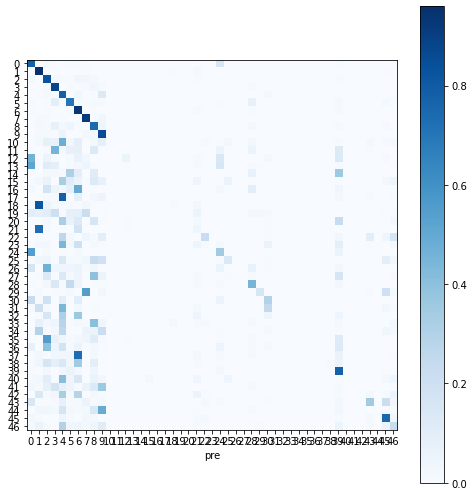

----- Epoch 4/29, lr=0.000656 -----
Time since begun: 0m 24s
Train Loss: 1.7677, Train Acc: 0.5511
Val Loss: 1.5833, val Acc: 0.5876
++++++F1+++++: 0.2743080767969884
Confusion matrix


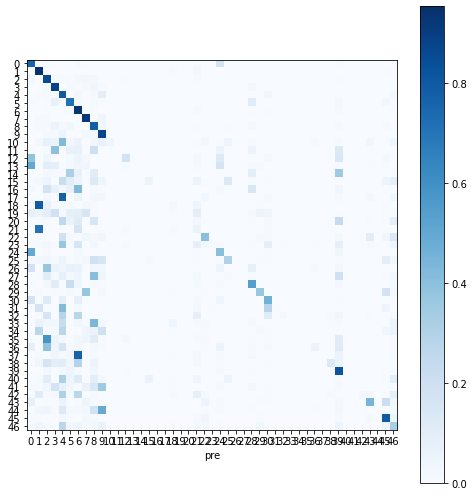

----- Epoch 5/29, lr=0.000590 -----
Time since begun: 0m 29s
Train Loss: 1.6221, Train Acc: 0.5797
Val Loss: 1.4699, val Acc: 0.6105
++++++F1+++++: 0.31759699028575794
Confusion matrix


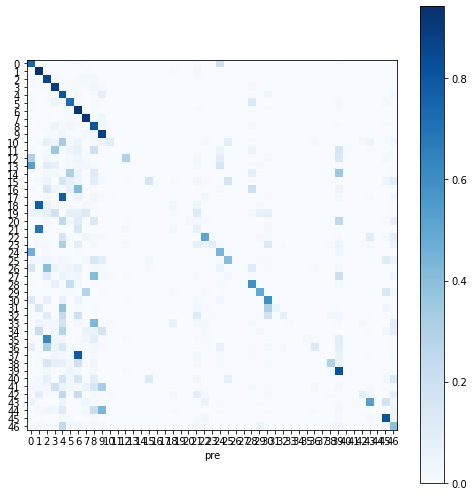

----- Epoch 6/29, lr=0.000531 -----
Time since begun: 0m 33s
Train Loss: 1.5111, Train Acc: 0.6036
Val Loss: 1.3567, val Acc: 0.6385
++++++F1+++++: 0.3548458031979208
Confusion matrix


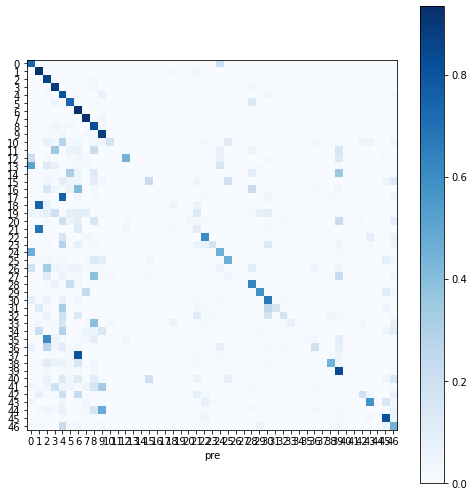

----- Epoch 7/29, lr=0.000478 -----
Time since begun: 0m 38s
Train Loss: 1.4306, Train Acc: 0.6213
Val Loss: 1.2784, val Acc: 0.6565
++++++F1+++++: 0.3844242116517285
Confusion matrix


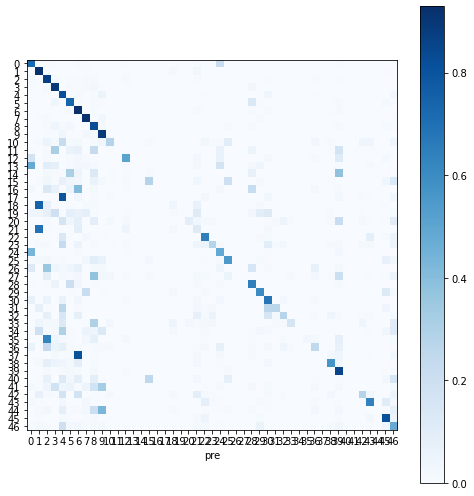

----- Epoch 8/29, lr=0.000430 -----
Time since begun: 0m 43s
Train Loss: 1.3538, Train Acc: 0.6357
Val Loss: 1.2173, val Acc: 0.6683
++++++F1+++++: 0.4072092622335199
Confusion matrix


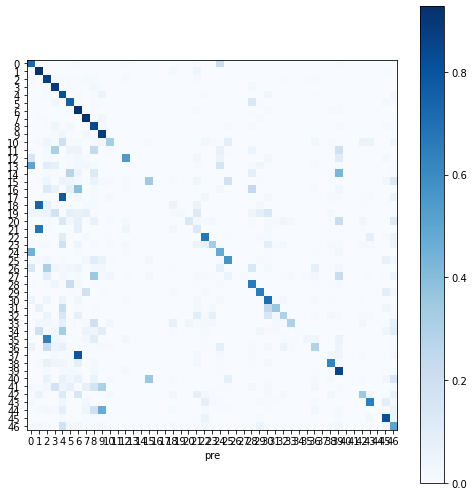

----- Epoch 9/29, lr=0.000387 -----
Time since begun: 0m 48s
Train Loss: 1.2974, Train Acc: 0.6501
Val Loss: 1.1747, val Acc: 0.6792
++++++F1+++++: 0.42807819801514796
Confusion matrix


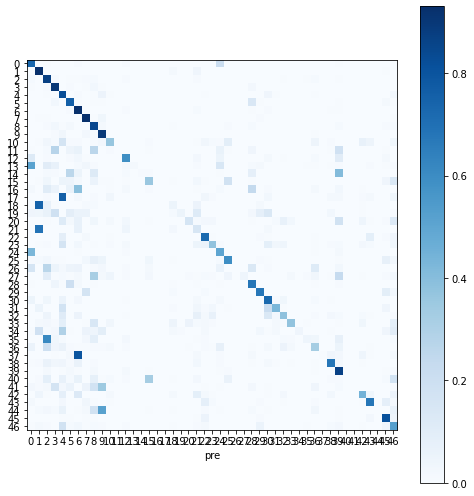

----- Epoch 10/29, lr=0.000349 -----
Time since begun: 0m 53s
Train Loss: 1.2536, Train Acc: 0.6583
Val Loss: 1.1336, val Acc: 0.6836
++++++F1+++++: 0.4431931914473309
Confusion matrix


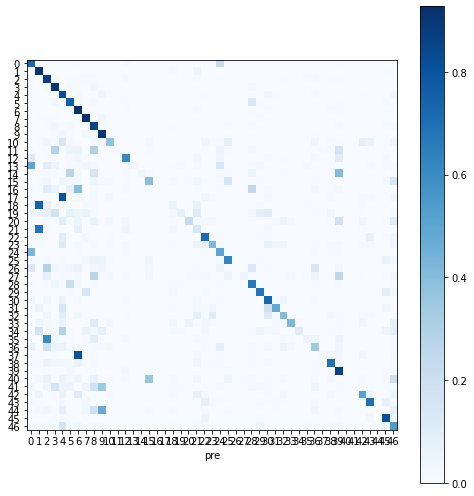

----- Epoch 11/29, lr=0.000314 -----
Time since begun: 0m 58s
Train Loss: 1.2241, Train Acc: 0.6639
Val Loss: 1.0994, val Acc: 0.6954
++++++F1+++++: 0.4524908978906454
Confusion matrix


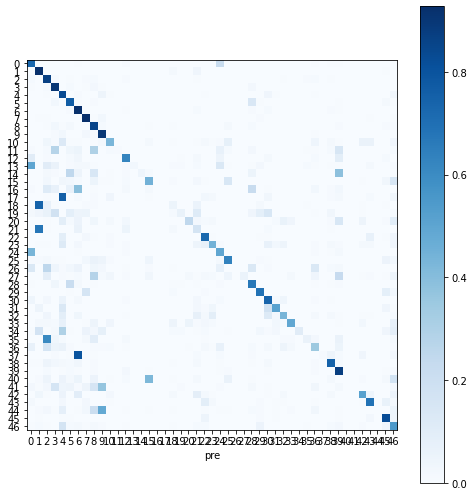

----- Epoch 12/29, lr=0.000282 -----
Time since begun: 1m 3s
Train Loss: 1.1888, Train Acc: 0.6726
Val Loss: 1.0667, val Acc: 0.6988
++++++F1+++++: 0.46964856941782934
Confusion matrix


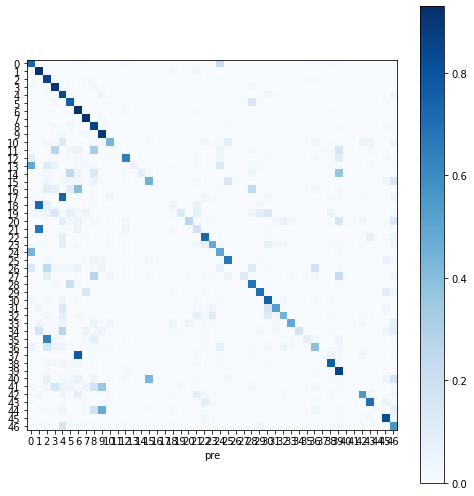

----- Epoch 13/29, lr=0.000254 -----
Time since begun: 1m 8s
Train Loss: 1.1648, Train Acc: 0.6784
Val Loss: 1.0284, val Acc: 0.7097
++++++F1+++++: 0.4787451464193905
Confusion matrix


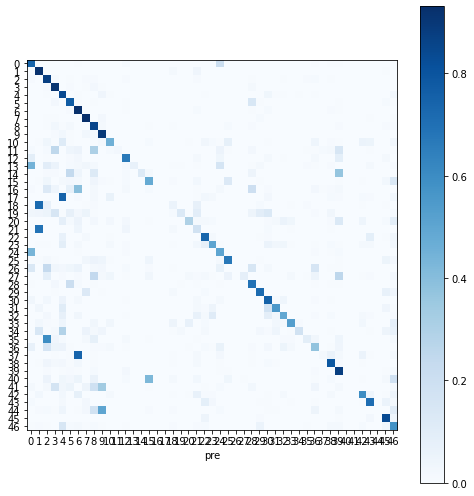

----- Epoch 14/29, lr=0.000229 -----
Time since begun: 1m 13s
Train Loss: 1.1382, Train Acc: 0.6826
Val Loss: 1.0280, val Acc: 0.7058
++++++F1+++++: 0.4846861413118346
Confusion matrix


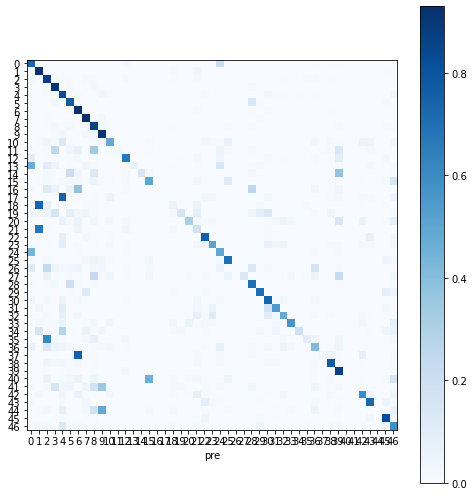

----- Epoch 15/29, lr=0.000206 -----
Time since begun: 1m 17s
Train Loss: 1.1207, Train Acc: 0.6853
Val Loss: 0.9967, val Acc: 0.7186
++++++F1+++++: 0.4932483248422125
Confusion matrix


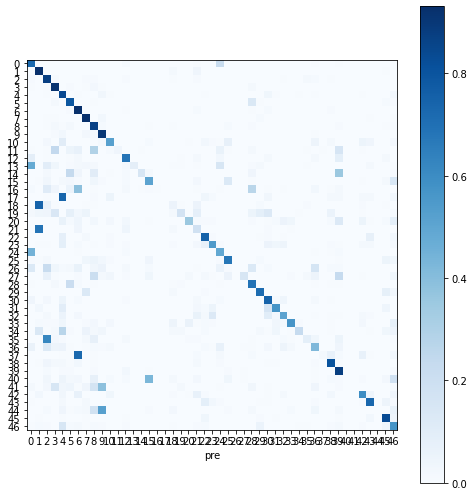

----- Epoch 16/29, lr=0.000185 -----
Time since begun: 1m 22s
Train Loss: 1.1031, Train Acc: 0.6894
Val Loss: 0.9792, val Acc: 0.7210
++++++F1+++++: 0.5000512680351815
Confusion matrix


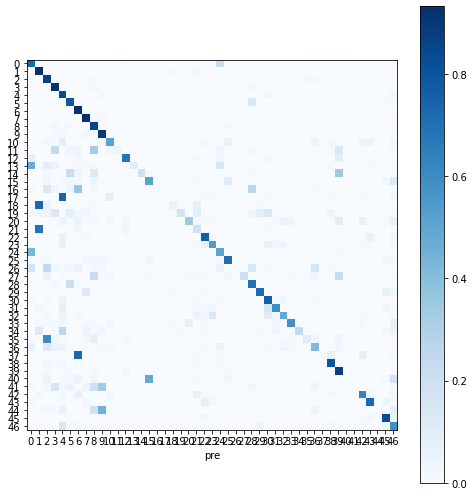

----- Epoch 17/29, lr=0.000167 -----
Time since begun: 1m 27s
Train Loss: 1.0866, Train Acc: 0.6945
Val Loss: 0.9803, val Acc: 0.7187
++++++F1+++++: 0.5089795131860425
Confusion matrix


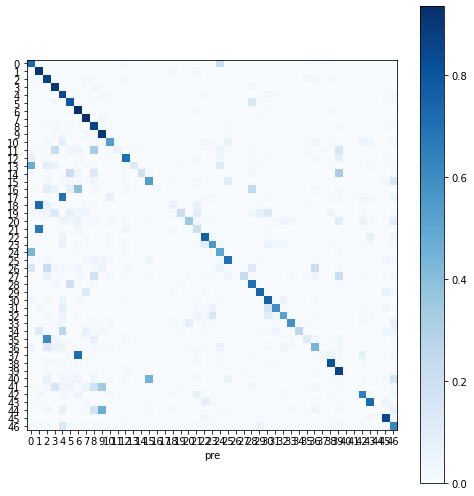

----- Epoch 18/29, lr=0.000150 -----
Time since begun: 1m 32s
Train Loss: 1.0779, Train Acc: 0.6954
Val Loss: 0.9634, val Acc: 0.7244
++++++F1+++++: 0.5109460388393159
Confusion matrix


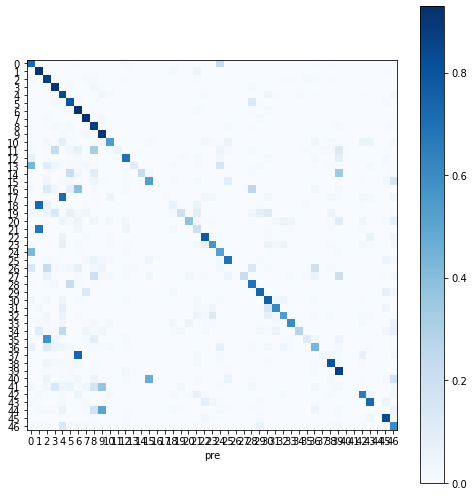

----- Epoch 19/29, lr=0.000135 -----
Time since begun: 1m 37s
Train Loss: 1.0679, Train Acc: 0.6964
Val Loss: 0.9782, val Acc: 0.7197
++++++F1+++++: 0.5131955887408903
Confusion matrix


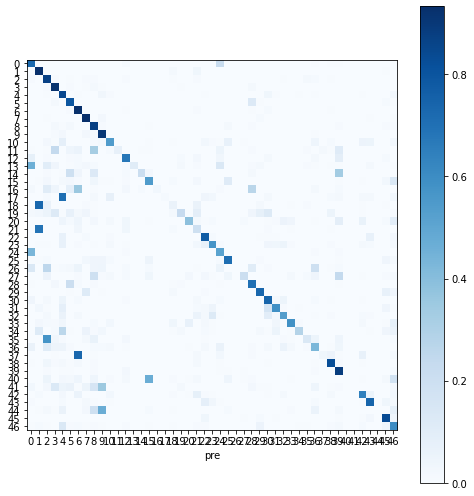

----- Epoch 20/29, lr=0.000122 -----
Time since begun: 1m 42s
Train Loss: 1.0603, Train Acc: 0.6980
Val Loss: 0.9490, val Acc: 0.7237
++++++F1+++++: 0.5164171461665953
Confusion matrix


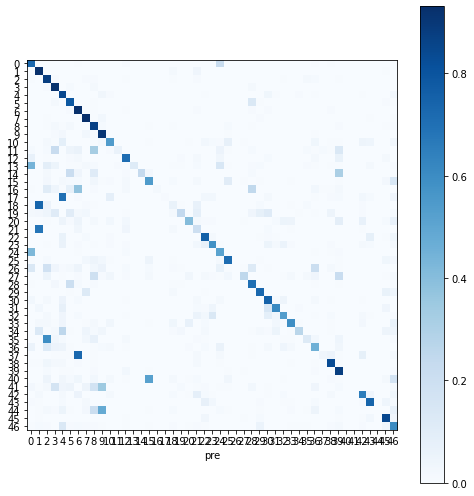

----- Epoch 21/29, lr=0.000109 -----
Time since begun: 1m 47s
Train Loss: 1.0440, Train Acc: 0.7013
Val Loss: 0.9504, val Acc: 0.7249
++++++F1+++++: 0.5231656374777216
Confusion matrix


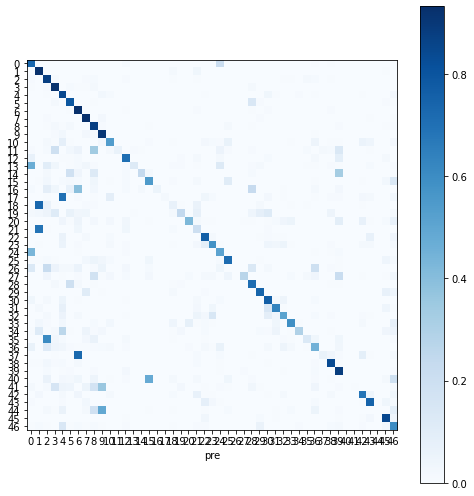

----- Epoch 22/29, lr=0.000098 -----
Time since begun: 1m 52s
Train Loss: 1.0421, Train Acc: 0.7019
Val Loss: 0.9264, val Acc: 0.7286
++++++F1+++++: 0.525603138120668
Confusion matrix


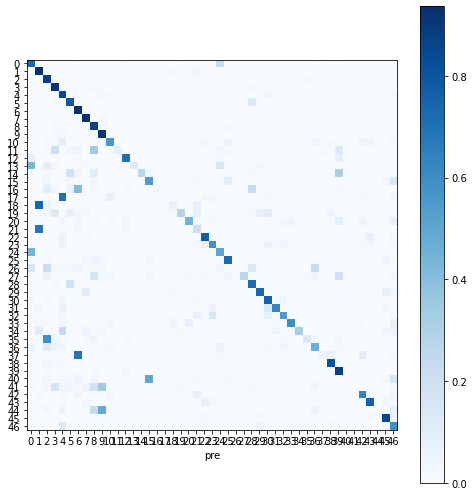

----- Epoch 23/29, lr=0.000089 -----
Time since begun: 1m 57s
Train Loss: 1.0377, Train Acc: 0.7033
Val Loss: 0.9225, val Acc: 0.7281
++++++F1+++++: 0.5270746385088356
Confusion matrix


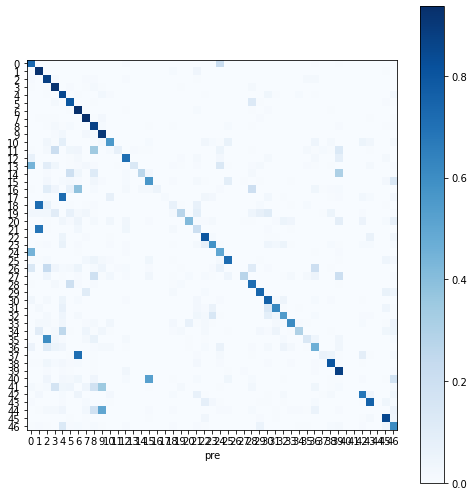

----- Epoch 24/29, lr=0.000080 -----
Time since begun: 2m 2s
Train Loss: 1.0269, Train Acc: 0.7053
Val Loss: 0.9221, val Acc: 0.7309
++++++F1+++++: 0.530350398308182
Confusion matrix


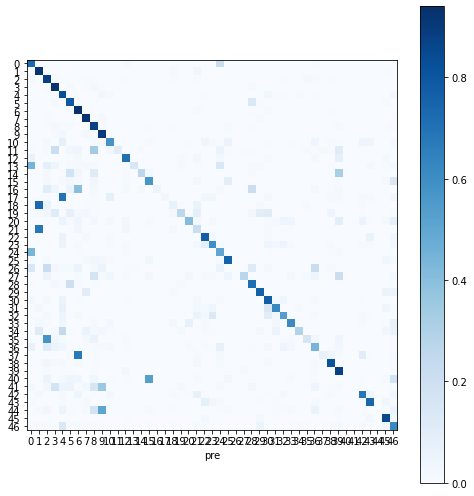

----- Epoch 25/29, lr=0.000072 -----
Time since begun: 2m 6s
Train Loss: 1.0261, Train Acc: 0.7054
Val Loss: 0.9181, val Acc: 0.7330
++++++F1+++++: 0.5318810368345842
Confusion matrix


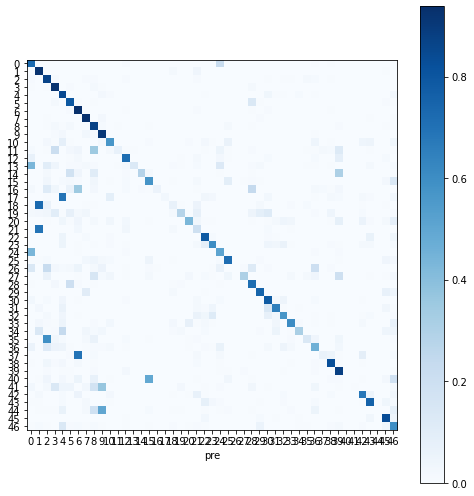

----- Epoch 26/29, lr=0.000065 -----
Time since begun: 2m 11s
Train Loss: 1.0150, Train Acc: 0.7080
Val Loss: 0.9352, val Acc: 0.7278
++++++F1+++++: 0.5330653330751417
Confusion matrix


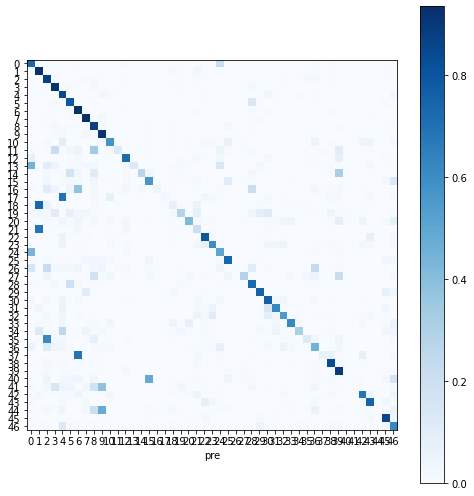

----- Epoch 27/29, lr=0.000058 -----
Time since begun: 2m 16s
Train Loss: 1.0165, Train Acc: 0.7070
Val Loss: 0.9086, val Acc: 0.7349
++++++F1+++++: 0.5341389301162618
Confusion matrix


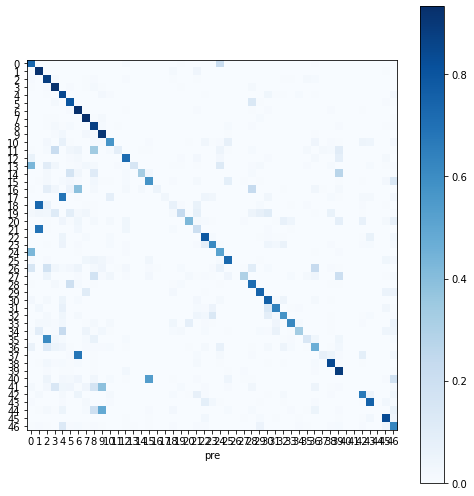

----- Epoch 28/29, lr=0.000052 -----
Time since begun: 2m 21s
Train Loss: 1.0082, Train Acc: 0.7115
Val Loss: 0.9151, val Acc: 0.7283
++++++F1+++++: 0.5383703469577812
Confusion matrix


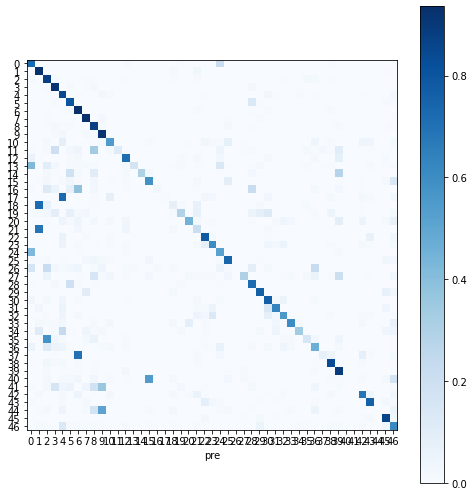

----- Epoch 29/29, lr=0.000047 -----
Time since begun: 2m 26s
Train Loss: 1.0108, Train Acc: 0.7089
Val Loss: 0.8932, val Acc: 0.7379
++++++F1+++++: 0.5375566972936396
Confusion matrix


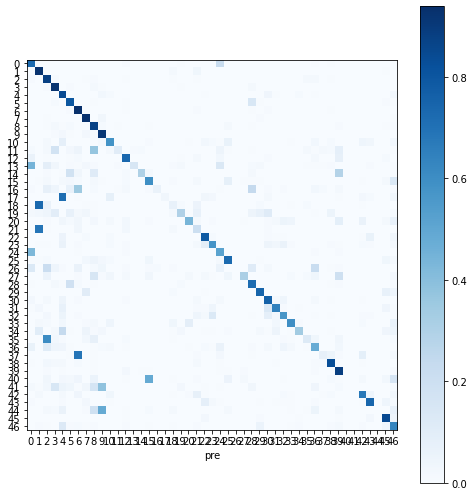

===== Best: epoch 29 =====
Train Loss: 1.0108, Train Acc: 0.7089
Val Loss: 0.8932, val Acc: 0.7379
Accuracy on test set is 73.35 %


In [69]:
cnn, train_process, acc = test_one_model(True, 0, True,torch.optim.ASGD, 0.001, lr_factor=0.9)#dropout=0,ASGD

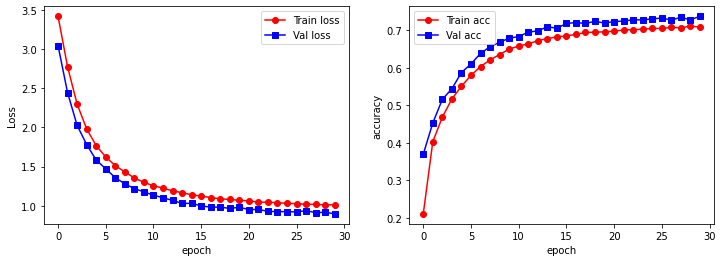

In [70]:
acc_plot(train_process)

## Test 7

----- Epoch 0/29, lr=0.000300 -----
Time since begun: 0m 5s
Train Loss: 1.1959, Train Acc: 0.6716
Val Loss: 0.5901, val Acc: 0.8083
++++++F1+++++: 0.5502947870091878
Confusion matrix


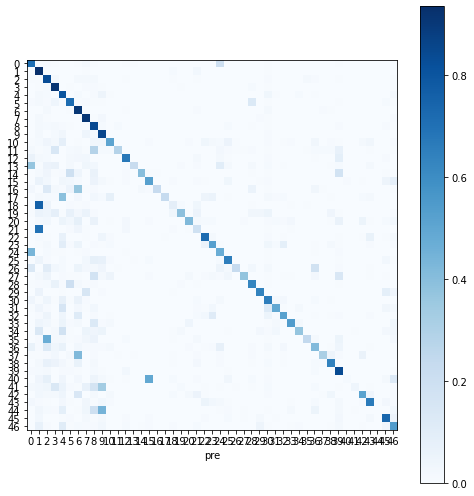

----- Epoch 1/29, lr=0.000270 -----
Time since begun: 0m 10s
Train Loss: 0.6078, Train Acc: 0.8056
Val Loss: 0.4867, val Acc: 0.8345
++++++F1+++++: 0.7380036320398109
Confusion matrix


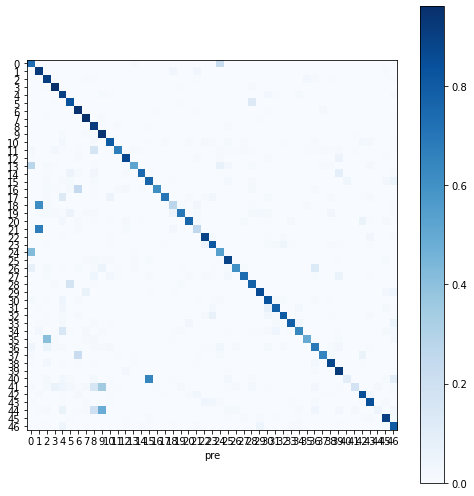

----- Epoch 2/29, lr=0.000243 -----
Time since begun: 0m 16s
Train Loss: 0.5290, Train Acc: 0.8264
Val Loss: 0.4415, val Acc: 0.8522
++++++F1+++++: 0.7700205862659553
Confusion matrix


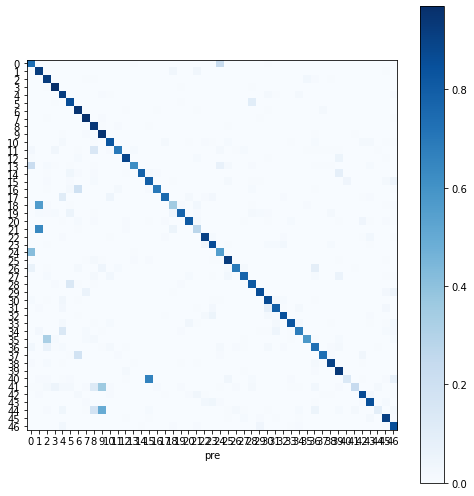

----- Epoch 3/29, lr=0.000219 -----
Time since begun: 0m 21s
Train Loss: 0.4954, Train Acc: 0.8363
Val Loss: 0.4082, val Acc: 0.8615
++++++F1+++++: 0.7841511007118983
Confusion matrix


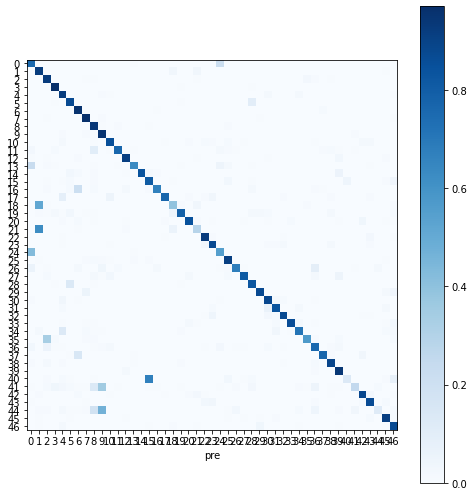

----- Epoch 4/29, lr=0.000197 -----
Time since begun: 0m 27s
Train Loss: 0.4671, Train Acc: 0.8452
Val Loss: 0.4010, val Acc: 0.8626
++++++F1+++++: 0.7979638951029788
Confusion matrix


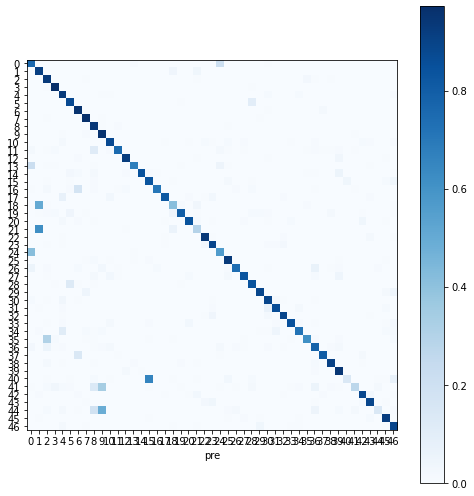

----- Epoch 5/29, lr=0.000177 -----
Time since begun: 0m 32s
Train Loss: 0.4465, Train Acc: 0.8511
Val Loss: 0.3808, val Acc: 0.8665
++++++F1+++++: 0.8047663568206257
Confusion matrix


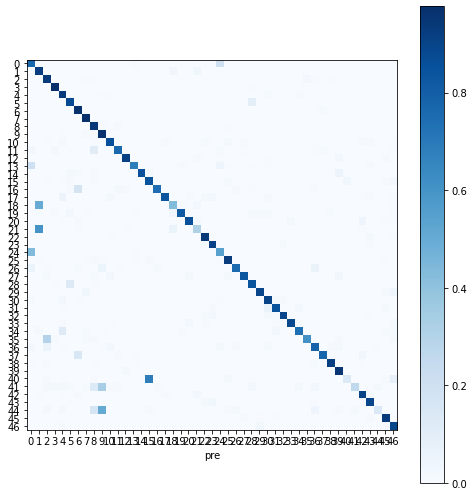

----- Epoch 6/29, lr=0.000159 -----
Time since begun: 0m 38s
Train Loss: 0.4342, Train Acc: 0.8524
Val Loss: 0.3728, val Acc: 0.8738
++++++F1+++++: 0.8089435399425365
Confusion matrix


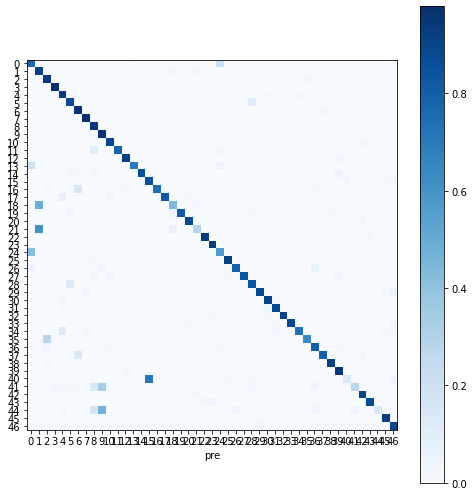

----- Epoch 7/29, lr=0.000143 -----
Time since begun: 0m 43s
Train Loss: 0.4250, Train Acc: 0.8561
Val Loss: 0.3638, val Acc: 0.8746
++++++F1+++++: 0.8113575307648315
Confusion matrix


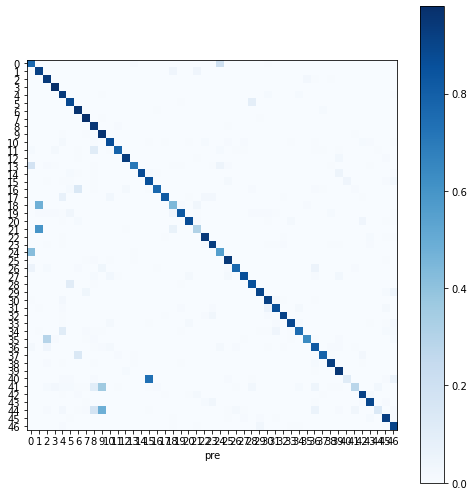

----- Epoch 8/29, lr=0.000129 -----
Time since begun: 0m 49s
Train Loss: 0.4161, Train Acc: 0.8585
Val Loss: 0.3567, val Acc: 0.8783
++++++F1+++++: 0.8184772023873796
Confusion matrix


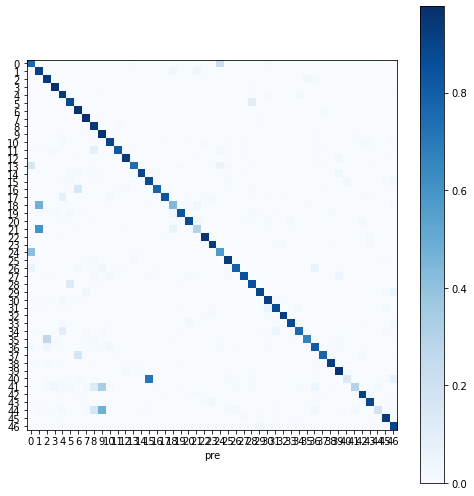

----- Epoch 9/29, lr=0.000116 -----
Time since begun: 0m 54s
Train Loss: 0.4078, Train Acc: 0.8606
Val Loss: 0.3512, val Acc: 0.8798
++++++F1+++++: 0.8193688290268918
Confusion matrix


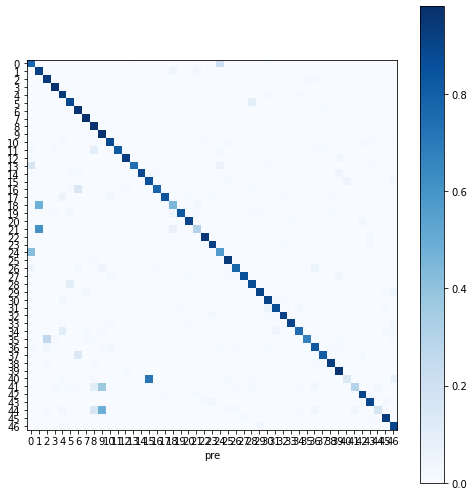

----- Epoch 10/29, lr=0.000105 -----
Time since begun: 1m 0s
Train Loss: 0.3975, Train Acc: 0.8643
Val Loss: 0.3489, val Acc: 0.8786
++++++F1+++++: 0.8247053705816203
Confusion matrix


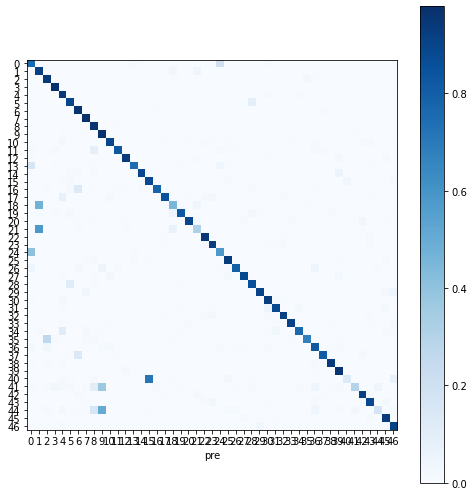

----- Epoch 11/29, lr=0.000094 -----
Time since begun: 1m 5s
Train Loss: 0.3972, Train Acc: 0.8633
Val Loss: 0.3417, val Acc: 0.8809
++++++F1+++++: 0.8248648657007037
Confusion matrix


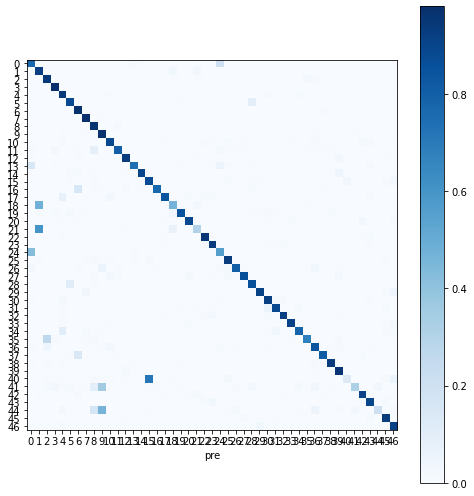

----- Epoch 12/29, lr=0.000085 -----
Time since begun: 1m 11s
Train Loss: 0.3930, Train Acc: 0.8653
Val Loss: 0.3436, val Acc: 0.8839
++++++F1+++++: 0.8282026575894694
Confusion matrix


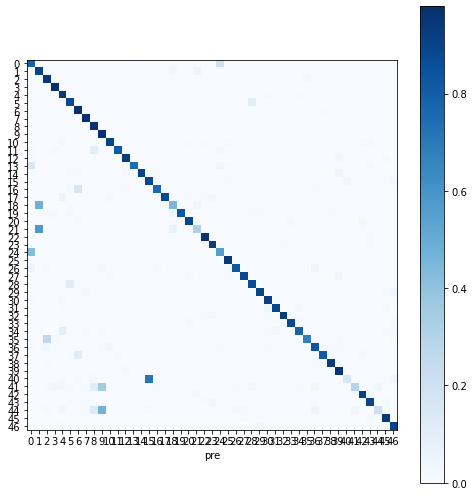

----- Epoch 13/29, lr=0.000076 -----
Time since begun: 1m 16s
Train Loss: 0.3884, Train Acc: 0.8664
Val Loss: 0.3432, val Acc: 0.8831
++++++F1+++++: 0.829180516641188
Confusion matrix


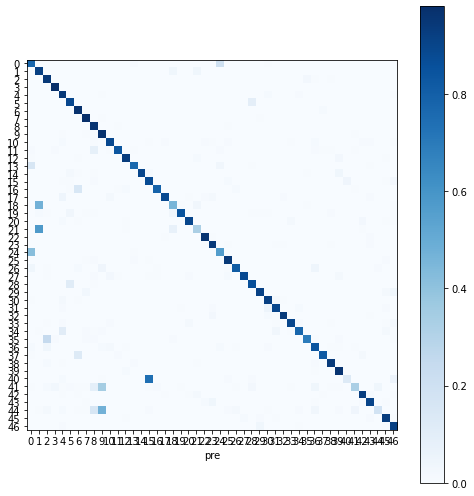

----- Epoch 14/29, lr=0.000069 -----
Time since begun: 1m 22s
Train Loss: 0.3827, Train Acc: 0.8696
Val Loss: 0.3344, val Acc: 0.8820
++++++F1+++++: 0.8302936663901743
Confusion matrix


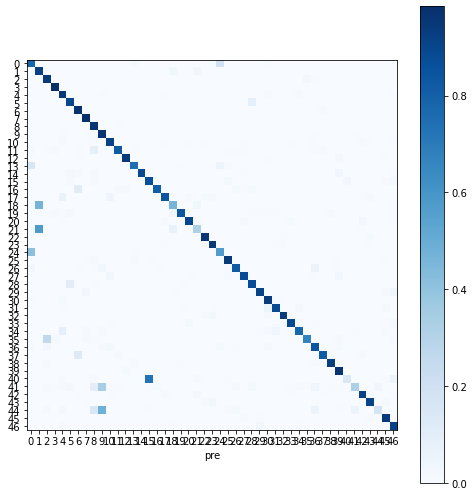

----- Epoch 15/29, lr=0.000062 -----
Time since begun: 1m 27s
Train Loss: 0.3814, Train Acc: 0.8691
Val Loss: 0.3351, val Acc: 0.8808
++++++F1+++++: 0.8320681243398901
Confusion matrix


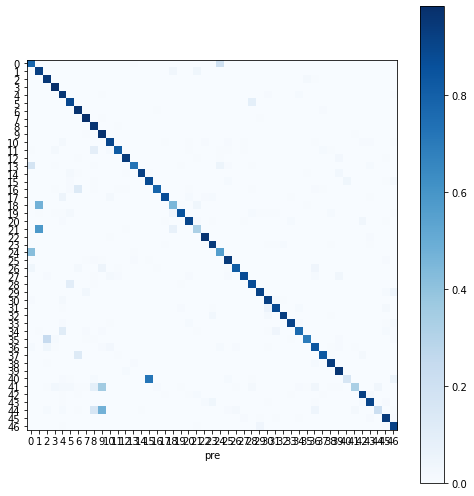

----- Epoch 16/29, lr=0.000056 -----
Time since begun: 1m 33s
Train Loss: 0.3787, Train Acc: 0.8695
Val Loss: 0.3250, val Acc: 0.8873
++++++F1+++++: 0.8363341766998084
Confusion matrix


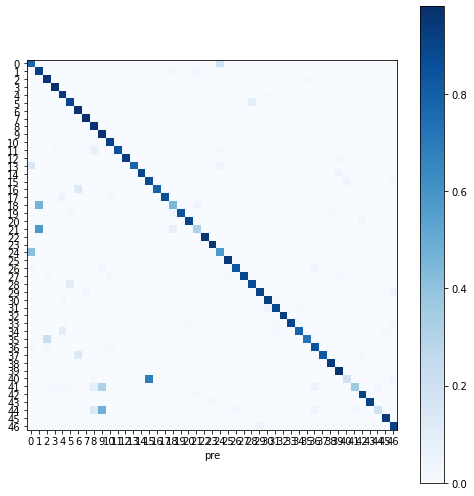

----- Epoch 17/29, lr=0.000050 -----
Time since begun: 1m 38s
Train Loss: 0.3760, Train Acc: 0.8709
Val Loss: 0.3289, val Acc: 0.8831
++++++F1+++++: 0.8345124147862276
Confusion matrix


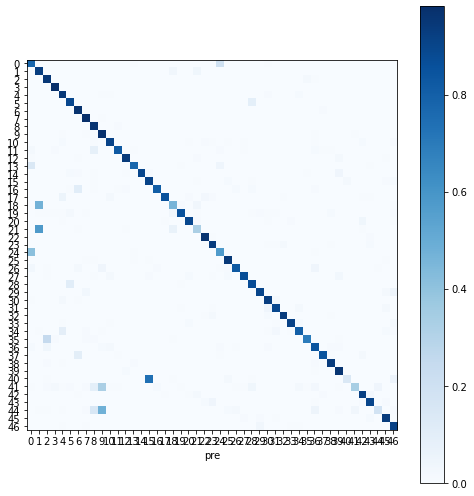

----- Epoch 18/29, lr=0.000045 -----
Time since begun: 1m 44s
Train Loss: 0.3727, Train Acc: 0.8718
Val Loss: 0.3322, val Acc: 0.8829
++++++F1+++++: 0.836124459546317
Confusion matrix


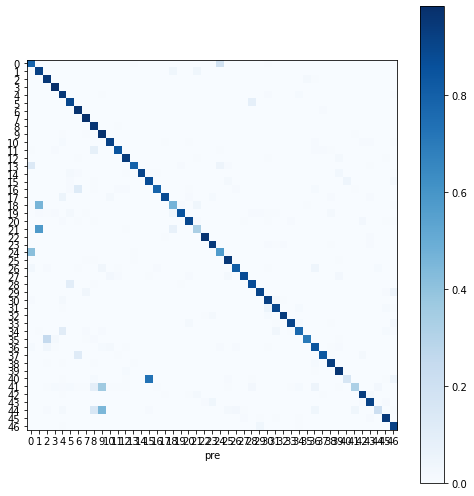

----- Epoch 19/29, lr=0.000041 -----
Time since begun: 1m 49s
Train Loss: 0.3713, Train Acc: 0.8721
Val Loss: 0.3269, val Acc: 0.8849
++++++F1+++++: 0.836912939554588
Confusion matrix


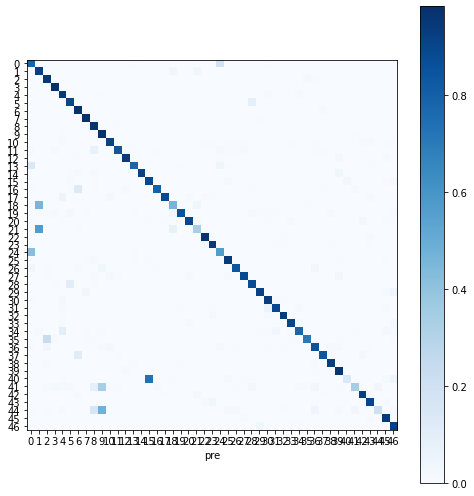

----- Epoch 20/29, lr=0.000036 -----
Time since begun: 1m 55s
Train Loss: 0.3689, Train Acc: 0.8733
Val Loss: 0.3337, val Acc: 0.8813
++++++F1+++++: 0.837261482789171
Confusion matrix


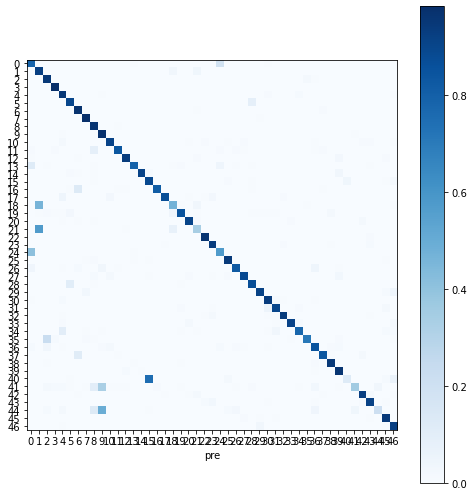

----- Epoch 21/29, lr=0.000033 -----
Time since begun: 2m 0s
Train Loss: 0.3695, Train Acc: 0.8729
Val Loss: 0.3159, val Acc: 0.8864
++++++F1+++++: 0.8382791914669027
Confusion matrix


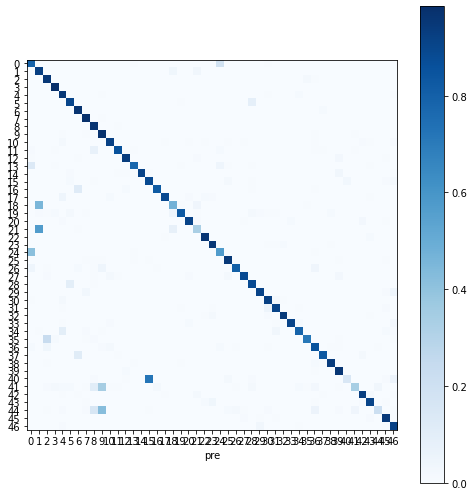

----- Epoch 22/29, lr=0.000030 -----
Time since begun: 2m 6s
Train Loss: 0.3644, Train Acc: 0.8742
Val Loss: 0.3289, val Acc: 0.8861
++++++F1+++++: 0.8413957654857711
Confusion matrix


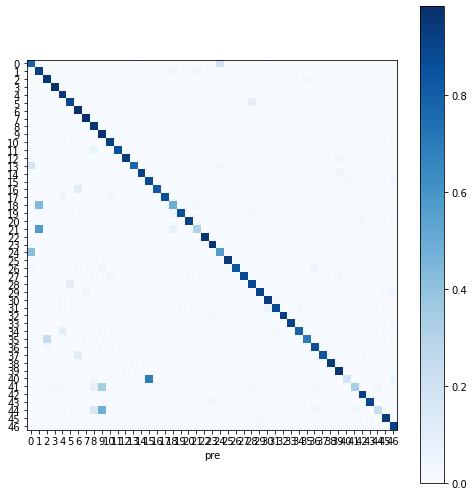

----- Epoch 23/29, lr=0.000027 -----
Time since begun: 2m 11s
Train Loss: 0.3650, Train Acc: 0.8732
Val Loss: 0.3203, val Acc: 0.8870
++++++F1+++++: 0.839938860587358
Confusion matrix


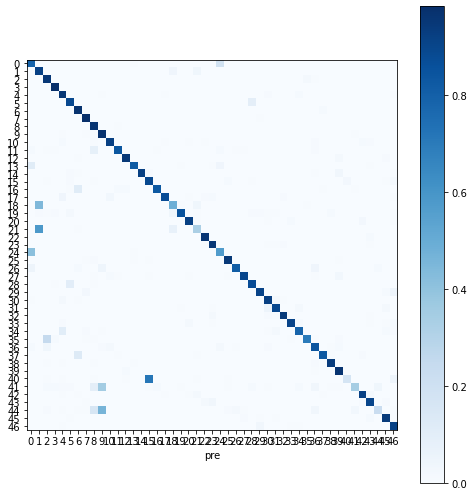

----- Epoch 24/29, lr=0.000024 -----
Time since begun: 2m 17s
Train Loss: 0.3653, Train Acc: 0.8736
Val Loss: 0.3129, val Acc: 0.8904
++++++F1+++++: 0.8396001542183057
Confusion matrix


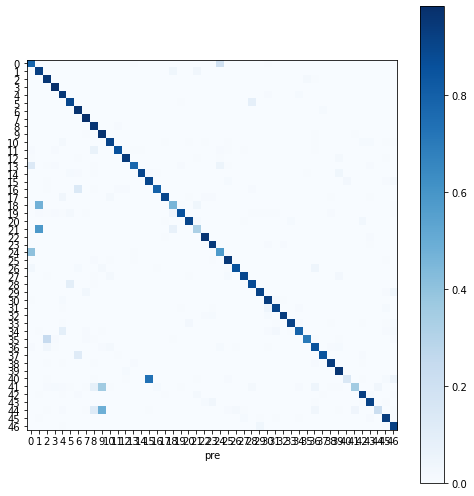

----- Epoch 25/29, lr=0.000022 -----
Time since begun: 2m 22s
Train Loss: 0.3637, Train Acc: 0.8744
Val Loss: 0.3177, val Acc: 0.8863
++++++F1+++++: 0.8411041999183209
Confusion matrix


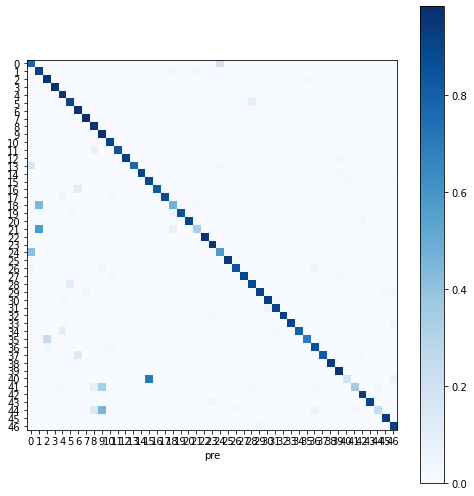

----- Epoch 26/29, lr=0.000019 -----
Time since begun: 2m 28s
Train Loss: 0.3671, Train Acc: 0.8729
Val Loss: 0.3155, val Acc: 0.8897
++++++F1+++++: 0.8363661134953884
Confusion matrix


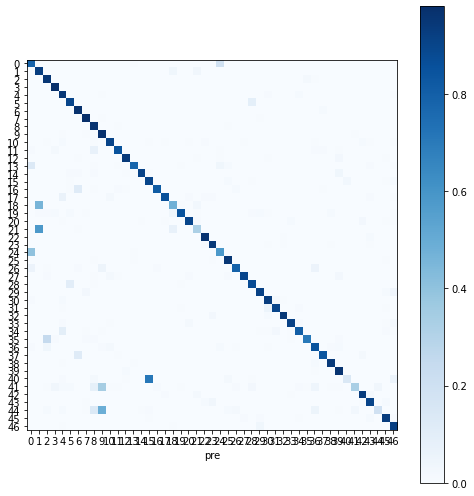

----- Epoch 27/29, lr=0.000017 -----
Time since begun: 2m 34s
Train Loss: 0.3658, Train Acc: 0.8738
Val Loss: 0.3087, val Acc: 0.8898
++++++F1+++++: 0.8388206618136559
Confusion matrix


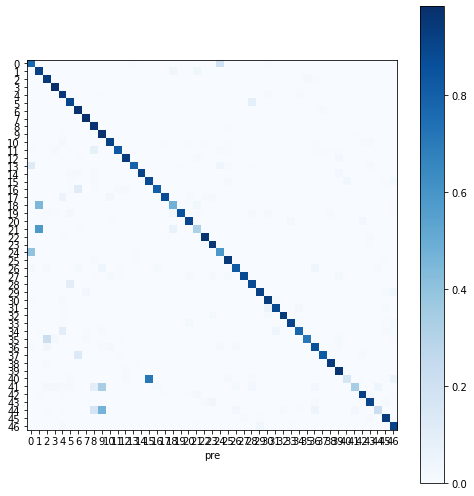

----- Epoch 28/29, lr=0.000016 -----
Time since begun: 2m 39s
Train Loss: 0.3623, Train Acc: 0.8736
Val Loss: 0.3192, val Acc: 0.8894
++++++F1+++++: 0.8414428379567486
Confusion matrix


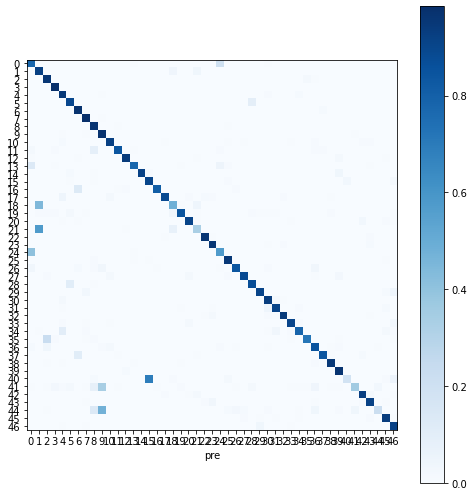

----- Epoch 29/29, lr=0.000014 -----
Time since begun: 2m 44s
Train Loss: 0.3589, Train Acc: 0.8753
Val Loss: 0.3237, val Acc: 0.8848
++++++F1+++++: 0.8405574900376437
Confusion matrix


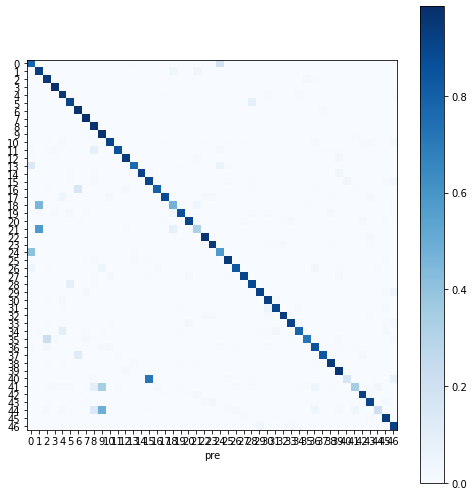

===== Best: epoch 24 =====
Train Loss: 0.3653, Train Acc: 0.8736
Val Loss: 0.3129, val Acc: 0.8904
Accuracy on test set is 87.93 %


In [71]:
cnn, train_process, acc = test_one_model(True, 0, True,torch.optim.Adam, 0.0003, lr_factor=0.9)#dropout=0,Adam,lr=0.0003

# 不用跑以下的了

In [72]:
# import os
# import numpy as np
# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Run the test set

In [74]:
test_loader = create_loader(data_test, label_test, device, shuffle=False, batch_size=64)

In [75]:
def test_model(model, data_loader):
    model.eval()
    test_corrects = 0
    test_num = 0
    for _, (x, y) in enumerate(data_loader):
        output = model(x)     
        pre_lab = torch.argmax(output, 1)

        test_corrects += torch.sum(pre_lab == y.data) 
        test_num += x.size(0)
    return test_corrects.item() / test_num

accuracy = test_model(cnn, test_loader)
print("Accuracy on test set is {:.2f} %".format(accuracy * 100))

Accuracy on test set is 87.93 %


# Save model to disk

In [76]:
torch.save(cnn, "leNet-5.pth")

# Plots

In [77]:
import matplotlib.pyplot as plt

def acc_plot(train_process):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_process.epoch, train_process.train_loss,
          "ro-", label="Train loss")
  plt.plot(train_process.epoch, train_process.val_loss,
          "bs-", label="Val loss")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("Loss")
  plt.subplot(1, 2, 2)
  plt.plot(train_process.epoch, train_process.train_acc,
          "ro-", label="Train acc")
  plt.plot(train_process.epoch, train_process.val_acc,
          "bs-", label="Val acc")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

# Clean up device

In [78]:
if device.type == "cuda":
    torch.cuda.empty_cache()